In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

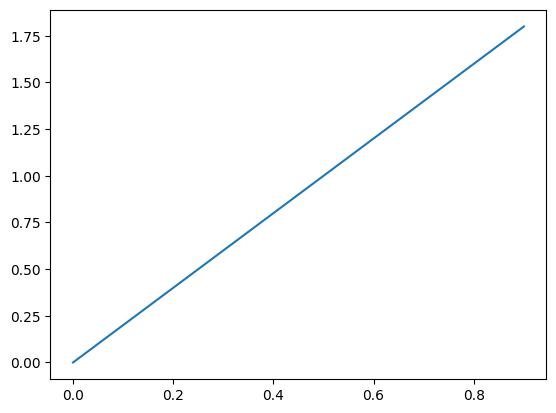

In [189]:
plt.plot(np.arange(0, 1, 0.1), 2*np.arange(0, 1, 0.1))

In [2]:
import h5py

In [3]:
from scipy.stats import norm

In [4]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
# import pandas as pd
import datetime
import os
# import readligo as rl
# from gwpy.timeseries import TimeSeries
import math
import random

import copy

In [5]:
epochs = 100
rTrain = 0.7;
rTest = 0.2;
# input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 0

### randomize bkg

In [63]:
with h5py.File("../data/Datasets/L1_bg_dataset_p1.hdf5") as f:
    print(f.keys())
    print(f["background_noise"].shape)
    print(f["background_noise_t0"][:])
    foo = f["background_noise"][:]

bkgn = np.empty((3*10**5, 200));

ind = 0;

for i in range(3000):
    for j in range(100):
        s = np.random.randint(low=4096, high=20480-200)
        bkgn[ind] = foo[i,s:s+200]
        ind = ind+1
        
bkgn = bkgn/np.array([np.linalg.norm(bkgn, axis=1)]).T

bkg2 = bkgn-np.mean([bkgn], axis=2).T
bkg2 = bkg2/np.std([bkg2], axis=2).T

<KeysViewHDF5 ['background_noise', 'background_noise_t0']>
(9915, 24576)
[1.23869024e+09 1.23869292e+09 1.23830585e+09 ... 1.23839411e+09
 1.23845594e+09 1.23839065e+09]


In [67]:
low = min(bkg2.flatten())
high = max(bkg2.flatten())

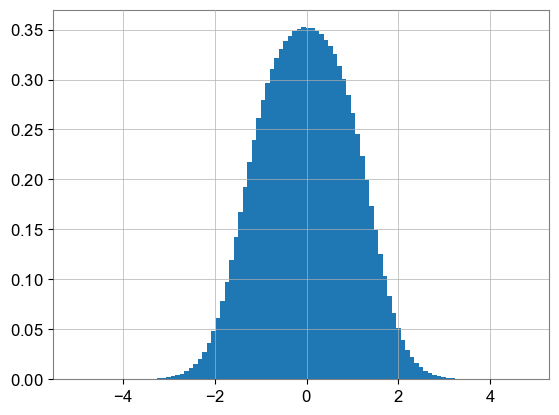

In [68]:
foo = plt.hist(bkg2.flatten(), range=(low, high), bins=100, density=True, label='Chia-Jui new noise')

In [96]:
np.digitize([-0.5, 0.5, 1.5, 2.5, 3.5], [1, 2, 3])

array([0, 0, 1, 2, 3], dtype=int64)

In [101]:
segments = np.cumsum(foo[0])*((high-low)/100);
offset = np.concatenate(([0], segments))
slope = ((high-low)/100) / (offset[1:] - offset[:-1])

C:\Users\sida_\AppData\Local\Temp\ipykernel_25796\2358731860.py:3: RuntimeWarning: divide by zero encountered in divide
  slope = ((high-low)/100) / (offset[1:] - offset[:-1])


In [103]:
strain = np.random.rand(200 * 10**5);
binIndex = np.digitize(strain, segments);
strain = strain - offset[binIndex];
strain = foo[1][binIndex] + strain*slope[binIndex]

In [104]:
strain = strain.reshape(10**5, 200)

In [117]:
strain2 = strain/np.linalg.norm([strain], axis=2).T

In [107]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(200, 40),nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(40, 200),nn.Tanh())

    def forward(self, x):
        encoded = self.layer1(x)
        decoded = self.layer2(encoded)
        return encoded, decoded

16240


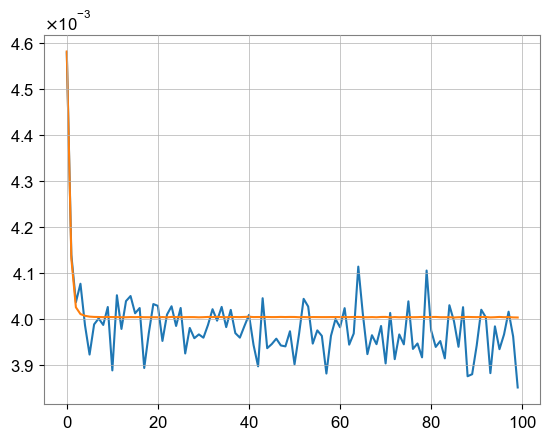

In [118]:
nTotal = len(strain2);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

perm = np.random.permutation(nTotal)

X_train = strain2[perm[:nTrain]]
X_test = strain2[perm[-nTest:]]
X_validation = strain2[perm[nTrain:-nTest]]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
print(sum(p.numel() for p in autoencoder.parameters() if p.requires_grad))

optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))
t0 = time.time()

wNorm = 0

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
#     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

plt.plot(loss_train[:, 0])
plt.plot(loss_validation[:, 0])

torch.save(autoencoder.cuda(), "../data/Datasets/my_own_random_bkg.pt")

In [120]:
with h5py.File("../data/Datasets/bbh_dataset_p1.hdf5") as f:
    print(f["L1"].shape)
    print(f["bbh_L1"].shape)
    foo = f["L1"][:]

bbh = np.empty((10**5, 200));

ind = 0;

for i in range(1000):
    for j in range(100):
        s = np.random.randint(low=4096, high=3*4096-200) # signals are mainly injected at the first half, according to Chia-Jui
        bbh[ind] = foo[i,s:s+200]
        ind = ind+1
        
bbh = bbh/np.array([np.linalg.norm(bbh, axis=1)]).T

(4505, 24576)
(4505, 24576)


In [121]:
autoencoder.cpu().eval()

AutoEncoder(
  (layer1): Sequential(
    (0): Linear(in_features=200, out_features=40, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=40, out_features=200, bias=True)
    (1): Tanh()
  )
)

In [122]:
bkg_decoded = autoencoder(torch.FloatTensor(strain2))[1].detach().numpy()
bbh_decoded = autoencoder(torch.FloatTensor(bbh))[1].detach().numpy()

In [125]:
np.linalg.norm(strain2[:10], axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [126]:
np.linalg.norm(bbh[:10], axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

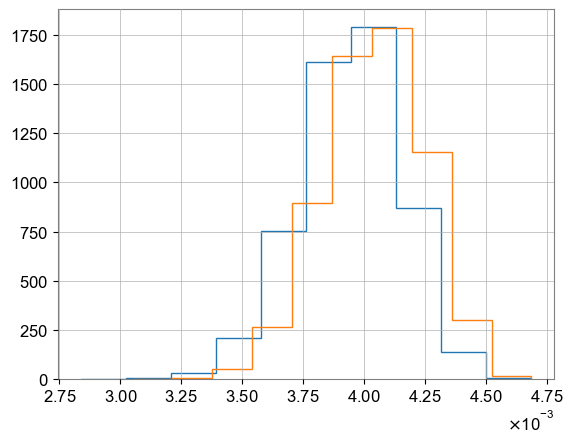

In [124]:
foo = plt.hist(np.var(strain2-bkg_decoded, axis=1), histtype="step", density=True)
foo = plt.hist(np.var(bbh - bbh_decoded, axis=1), histtype="step", density=True)

### testing the 1d CNN

In [51]:
bkg_gwak_0 = np.load("../data/Datasets/background.npz")['data'][:, 0, :];
bkg_gwak_0 = bkg_gwak_0 - np.mean([bkg_gwak_0], axis=2).T;
bkg_gwak_0 = bkg_gwak_0/np.std([bkg_gwak_0], axis=2).T;

bkg_gwak_1 = np.load("../data/Datasets/background.npz")['data'][:, 1, :];
bkg_gwak_1 = bkg_gwak_1 - np.mean([bkg_gwak_1], axis=2).T;
bkg_gwak_1 = bkg_gwak_1/np.std([bkg_gwak_1], axis=2).T;

In [14]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=50, kernel_size=3, stride=1, padding=1)# 100
        self.batch1 = nn.BatchNorm1d(num_features=50)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=4, return_indices=True)
        
        self.conv2 = nn.Conv1d(in_channels=50, out_channels=20, kernel_size=3, stride=1, padding=1)# 40
        self.batch2 = nn.BatchNorm1d(num_features=20)
        self.act2 = nn.ReLU()
#         self.pool2 = nn.MaxUnpool1d(kernel_size=4)
        
        self.conv3 = nn.Conv1d(in_channels=20, out_channels=50, kernel_size=3, stride=1, padding=1)# 100
        self.batch3 = nn.BatchNorm1d(num_features=50)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxUnpool1d(kernel_size=4)
        
        self.conv4 = nn.Conv1d(in_channels=50, out_channels=1, kernel_size=3, padding=1)
        self.final = nn.Tanh()

    def forward(self, x):
#         print(x.shape)
        x = self.conv1(x);
        x = self.batch1(x);
        x = self.act1(x);
        x, indices = self.pool1(x);
#         print(x.shape)
#         x = self.pool1(self.act1(self.batch1(self.conv1(x))))
        encoded = self.act2(self.conv2(x))
#         print(encoded.shape)
        
        x = self.conv3(encoded)
        x = self.batch3(x);
        x = self.act3(x);
#         print(x.shape)
        x = self.pool3(x, indices);

#         x = self.final(self.conv4(x))
        x = self.conv4(x)

        return encoded, x

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(
        self, 
        num_ifos: int, 
        n_channels: int = 8, 
        n_bottleneck: int = 10, 
        sequence_length: int = 200
        ):
        super(AutoEncoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=n_channels, kernel_size=2, padding=1)# 100
        self.batch1 = nn.BatchNorm1d(num_features=n_channels)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, return_indices=True)
        
        # self.conv2 = nn.Conv1d(in_channels=n_channels, out_channels=20, kernel_size=2, padding=1)# 40
        # self.batch2 = nn.BatchNorm1d(num_features=20)
        # self.act2 = nn.ReLU()
#         self.pool2 = nn.MaxUnpool1d(kernel_size=4)

        self.dnn1 = nn.Linear(sequence_length // 2, n_bottleneck)
        self.batch_dnn1 = nn.BatchNorm1d(n_bottleneck)
        self.act_dnn1 = nn.ReLU()
        
        self.dnn2 = nn.Linear(n_bottleneck, sequence_length // 2)
        self.batch_dnn2 = nn.BatchNorm1d(sequence_length // 2)
        self.act_dnn2 = nn.ReLU()

        
        # self.conv3 = nn.Conv1d(in_channels=n_channels, out_channels=n_channels, kernel_size=2, padding=1)# 100
        # self.batch3 = nn.BatchNorm1d(num_features=n_channels)
        # self.act3 = nn.ReLU()
        self.pool3 = nn.MaxUnpool1d(kernel_size=2)
        
        self.conv4 = nn.Conv1d(in_channels=n_channels, out_channels=1, kernel_size=2, padding=1)
        self.final = nn.Tanh()

    def forward(self, x):
#         print(x.shape)
        x = self.conv1(x);
        x = self.batch1(x);
        x = self.act1(x);
        x, indices = self.pool1(x);
#         print(x.shape)
#         x = self.pool1(self.act1(self.batch1(self.conv1(x))))
        # encoded = self.act2(self.conv2(x))
#         print(encoded.shape)
        
        encoded = self.act_dnn1(self.batch_dnn1(self.dnn1(x)))
        
        
        x = self.act_dnn2(self.batch_dnn2(self.dnn2(x)))
        
        # x = self.conv3(encoded)
        # x = self.batch3(x);
        # x = self.act3(x);
#         print(x.shape)
        x = self.pool3(x, indices);

#         x = self.final(self.conv4(x))
        x = self.conv4(x)
        x = self.final(x)

        return encoded, x

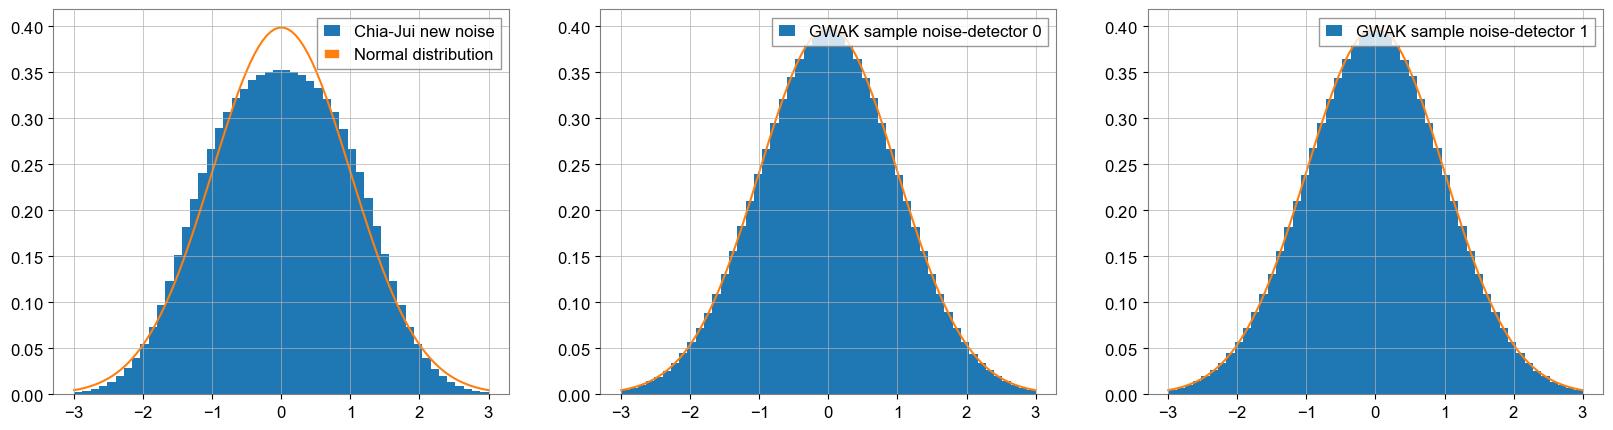

In [52]:
_, ax = plt.subplots(1, 3, figsize=(20, 5))
foo = ax[0].hist(bkg2.flatten(), range=(-3, 3), bins=50, density=True, label='Chia-Jui new noise')
ax[0].plot(np.linspace(-3, 3, 100), norm.pdf(np.linspace(-3, 3, 100)), label='Normal distribution')
ax[0].legend()

foo = ax[1].hist(bkg_gwak_0.flatten(), range=(-3, 3), bins=50, density=True, label="GWAK sample noise-detector 0")
ax[1].plot(np.linspace(-3, 3, 100), norm.pdf(np.linspace(-3, 3, 100)))
ax[1].legend()

foo = ax[2].hist(bkg_gwak_1.flatten(), range=(-3, 3), bins=50, density=True, label="GWAK sample noise-detector 1")
ax[2].plot(np.linspace(-3, 3, 100), norm.pdf(np.linspace(-3, 3, 100)))
ax[2].legend()

plt.savefig("../results/noise_amp_comparison.jpg")
plt.show()

6661
37.81891632080078
Epoch: 0001, Training loss=0.02146615, Validation loss=0.01909738
36.561570167541504
Epoch: 0002, Training loss=0.01033202, Validation loss=0.01158973
31.160659551620483
Epoch: 0003, Training loss=0.00841966, Validation loss=0.00863043
30.246778964996338
Epoch: 0004, Training loss=0.00848730, Validation loss=0.00754700
29.193392992019653
Epoch: 0005, Training loss=0.00613675, Validation loss=0.00671803
27.853121995925903
Epoch: 0006, Training loss=0.00630415, Validation loss=0.00637204
27.28664779663086
Epoch: 0007, Training loss=0.00549162, Validation loss=0.00586967
28.300755977630615
Epoch: 0008, Training loss=0.00564254, Validation loss=0.00557804
31.780978679656982
Epoch: 0009, Training loss=0.00650099, Validation loss=0.00532973
31.770010471343994
Epoch: 0010, Training loss=0.00590884, Validation loss=0.00509850
31.275696277618408
Epoch: 0011, Training loss=0.00551035, Validation loss=0.00501270
28.923948526382446
Epoch: 0012, Training loss=0.00473411, Vali

26.948599815368652
Epoch: 0098, Training loss=0.00334141, Validation loss=0.00336577
29.19945788383484
Epoch: 0099, Training loss=0.00347148, Validation loss=0.00370147
27.261006832122803
Epoch: 0100, Training loss=0.00327441, Validation loss=0.00328393


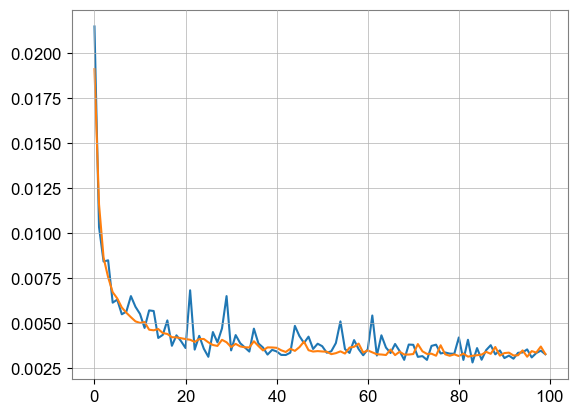

In [15]:
trainData = torch.FloatTensor(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])))
testData = torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1])))
validationData = torch.FloatTensor(X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1])))

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
print(sum(p.numel() for p in autoencoder.parameters() if p.requires_grad))

optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))
t0 = time.time()

wNorm = 0

for epoch in range(epochs):
    
    t0 = time.time()

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
    print(time.time() - t0)
    print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

plt.plot(loss_train[:, 0])
plt.plot(loss_validation[:, 0])


In [16]:
autoencoder.eval().cpu()

AutoEncoder(
  (conv1): Conv1d(1, 50, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(50, 20, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (conv3): Conv1d(20, 50, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): ReLU()
  (pool3): MaxUnpool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (conv4): Conv1d(50, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (final): Tanh()
)

In [17]:
decoded_bkgTrain = np.empty(X_train.shape)

for i in range(X_train.shape[0]//1000):
    foo = autoencoder(torch.FloatTensor(X_train[i*1000:(i+1)*1000].reshape((1000,1,X_train.shape[1]))))
    decoded_bkgTrain[i*1000:(i+1)*1000] = foo[1].detach().numpy().reshape(1000, X_train.shape[1])

In [18]:
decoded_bkgTest = np.empty(X_test.shape)

for i in range(X_test.shape[0]//1000):
    foo = autoencoder(torch.FloatTensor(X_test[i*1000:(i+1)*1000].reshape((1000,1,X_test.shape[1]))))
    decoded_bkgTest[i*1000:(i+1)*1000] = foo[1].detach().numpy().reshape(1000, X_test.shape[1])

In [19]:
decoded_bbh = np.empty(bbh2.shape)

for i in range(bbh2.shape[0]//1000):
    foo = autoencoder(torch.FloatTensor(bbh2[i*1000:(i+1)*1000].reshape((1000,1,bbh2.shape[1]))))
    decoded_bbh[i*1000:(i+1)*1000] = foo[1].detach().numpy().reshape(1000, bbh2.shape[1])

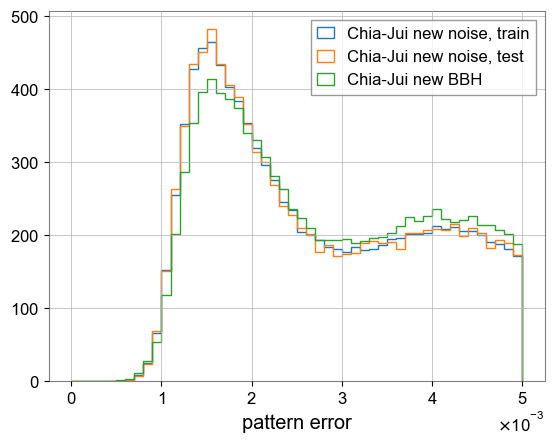

In [20]:
foo1 = plt.hist(np.mean((X_train-decoded_bkgTrain)**2, axis=1), density=True, range=(0, 0.005), bins=50, label="Chia-Jui new noise, train", histtype="step")
foo2 = plt.hist(np.mean((X_test-decoded_bkgTest)**2, axis=1), density=True, range=(0, 0.005), bins=50, label="Chia-Jui new noise, test", histtype="step")
foo3 = plt.hist(np.mean((bbh2-decoded_bbh)**2, axis=1), density=True, range=(0, 0.005), bins=50, label="Chia-Jui new BBH", histtype="step")

plt.xlabel("pattern error")
plt.legend()

In [21]:
torch.save(autoencoder.cuda(), "../data/Datasets/model_CNN_2.pt")
# np.savetxt("../data/Datasets/loss_CNN_Xcheck_ChiaJui_data.dat", [loss_train[:, 0], loss_validation[:, 0]])
    
np.savetxt("../data/Datasets/perm_CNN_2.dat", perm)

In [193]:
import json

In [205]:
dic = {"bin_boundaries":list(foo1[1]), "bin_train":list(foo1[0]), "bin_test":list(foo2[0]), "bin_bbh":list(foo3[0])};

In [206]:
with open("../data/Datasets/CNN_bins.json", "w") as f:
    json.dump(dic, f)

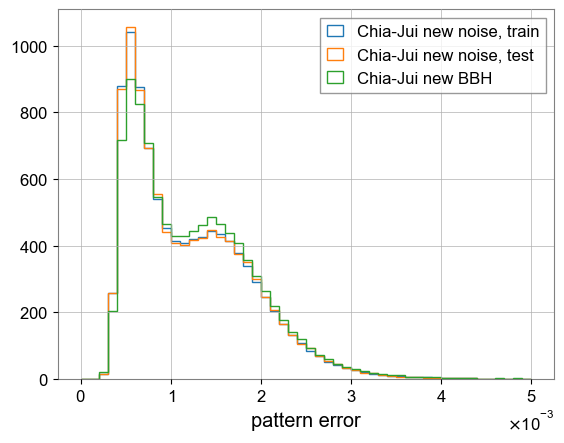

In [182]:
# foo = plt.hist(np.mean((bbh2-decoded_bbh)**2, axis=1), density=True, range=(0, 0.005), bins=50, label="Chia-Jui new BBH")
foo = plt.hist(np.mean((X_train-decoded_bkgTrain)**2, axis=1), density=True, range=(0, 0.005), bins=50, label="Chia-Jui new noise, train", histtype="step")
foo = plt.hist(np.mean((X_test-decoded_bkgTest)**2, axis=1), density=True, range=(0, 0.005), bins=50, label="Chia-Jui new noise, test", histtype="step")
foo = plt.hist(np.mean((bbh2-decoded_bbh)**2, axis=1), density=True, range=(0, 0.005), bins=50, label="Chia-Jui new BBH", histtype="step")

plt.xlabel("pattern error")
plt.legend()
plt.savefig("../results/CNN_pattern_error.jpg")

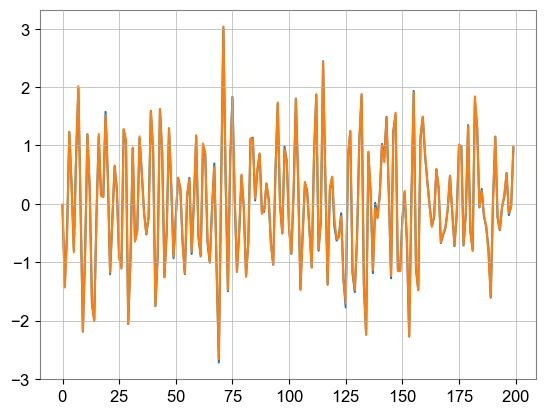

In [170]:
plt.plot(X_train[0])
plt.plot(decoded_bkgTrain[0])

### testing Chia-Jui's data

In [62]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(200, 100),nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(100, 40),nn.ReLU())
        
        self.layer3 = nn.Sequential(nn.Linear(40, 100),nn.ReLU())
        self.layer4 = nn.Sequential(nn.Linear(100, 200),nn.Tanh())

    def forward(self, x):
        encoded = self.layer2(self.layer1(x))
        decoded = self.layer4(self.layer3(encoded))
        return encoded, decoded

In [6]:
with h5py.File("../data/Datasets/L1_bg_dataset_p1.hdf5") as f:
    print(f.keys())
    print(f["background_noise"].shape)
    print(f["background_noise_t0"][:])
    foo = f["background_noise"][:]

<KeysViewHDF5 ['background_noise', 'background_noise_t0']>
(9915, 24576)
[1.23869024e+09 1.23869292e+09 1.23830585e+09 ... 1.23839411e+09
 1.23845594e+09 1.23839065e+09]


In [12]:
foo.shape

(9915, 24576)

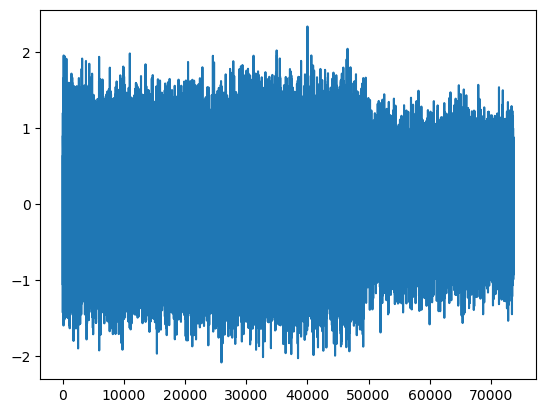

In [16]:
plt.plot(np.concatenate((foo[0], foo[1], foo[2])))

In [7]:
bkg = np.empty((3*10**5, 200));

ind = 0;

for i in range(3000):
    for j in range(100):
        s = np.random.randint(low=4096, high=20480-200)
        bkg[ind] = foo[i,s:s+200]
        ind = ind+1
        
bkg = bkg/np.array([np.linalg.norm(bkg, axis=1)]).T

In [8]:
with h5py.File("../data/Datasets/bbh_dataset_p1.hdf5") as f:
    print(f["L1"].shape)
    print(f["bbh_L1"].shape)
    foo = f["L1"][:]

(4505, 24576)
(4505, 24576)


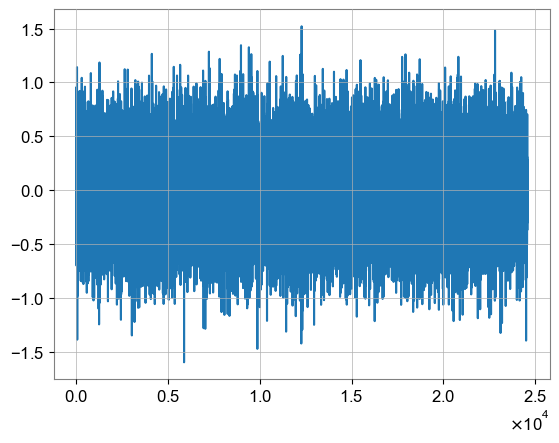

In [37]:
plt.plot(foo[0])

In [9]:
bbh = np.empty((10**5, 200));

ind = 0;

for i in range(1000):
    for j in range(100):
        s = np.random.randint(low=4096, high=3*4096-200) # signals are mainly injected at the first half, according to Chia-Jui
        bbh[ind] = foo[i,s:s+200]
        ind = ind+1
        
bbh = bbh/np.array([np.linalg.norm(bbh, axis=1)]).T

In [70]:
bbh.shape

(100000, 200)

In [10]:
bbh

array([[ 0.02304348, -0.03801842,  0.04185165, ...,
        -0.12397217,  0.02402944,  0.03023142],
       [-0.17438949, -0.10874302, -0.07639478, ...,
        -0.02280171,  0.06709912,  0.03172942],
       [-0.00482613, -0.05617971, -0.00263441, ...,
         0.04202695, -0.06844651, -0.05672267],
       ...,
       [-0.08140836, -0.01664715, -0.01376178, ...,
        -0.01742034, -0.0554502 , -0.0590132 ],
       [ 0.09182206,  0.01741503, -0.1355899 , ...,
         0.07700598, -0.01937028, -0.01032383],
       [-0.08585392, -0.02571368, -0.06190922, ...,
         0.06471734,  0.02632406, -0.03476397]])

In [11]:
bbh2 = bbh-np.mean([bbh], axis=2).T
bbh2 = bbh2/np.std([bbh2], axis=2).T

bkg2 = bkg-np.mean([bkg], axis=2).T
bkg2 = bkg2/np.std([bkg2], axis=2).T

In [12]:
# nTotal = len(bkg);
# # nTotal = len(fake_bkg);
# nTrain = int(rTrain * nTotal)
# nTest = int(rTest * nTotal)

# perm = np.random.permutation(nTotal)

# X_train = bkg[perm[:nTrain]]
# X_test = bkg[perm[-nTest:]]
# X_validation = bkg[perm[nTrain:-nTest]]

# # X_train = fake_bkg[perm[:nTrain]]
# # X_test = fake_bkg[perm[-nTest:]]
# # X_validation = fake_bkg[perm[nTrain:-nTest]]

nTotal = len(bkg2);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

perm = np.random.permutation(nTotal)

X_train = bkg2[perm[:nTrain]]
X_test = bkg2[perm[-nTest:]]
X_validation = bkg2[perm[nTrain:-nTest]]

In [13]:
epochs = 100

48440
Epoch: 0001, Training loss=0.56656837, Validation loss=0.48602720
Epoch: 0002, Training loss=0.43690217, Validation loss=0.44172252
Epoch: 0003, Training loss=0.45236853, Validation loss=0.42001011
Epoch: 0004, Training loss=0.39279816, Validation loss=0.40699871
Epoch: 0005, Training loss=0.44616362, Validation loss=0.39863662
Epoch: 0006, Training loss=0.39418554, Validation loss=0.39340850
Epoch: 0007, Training loss=0.33843970, Validation loss=0.38968708
Epoch: 0008, Training loss=0.41101265, Validation loss=0.38724034
Epoch: 0009, Training loss=0.36607322, Validation loss=0.38521878
Epoch: 0010, Training loss=0.45901656, Validation loss=0.38378148
Epoch: 0011, Training loss=0.33316016, Validation loss=0.38259282
Epoch: 0012, Training loss=0.47816730, Validation loss=0.38159287
Epoch: 0013, Training loss=0.43753508, Validation loss=0.38058565
Epoch: 0014, Training loss=0.34536299, Validation loss=0.37956624
Epoch: 0015, Training loss=0.38400596, Validation loss=0.37904435
Epoc

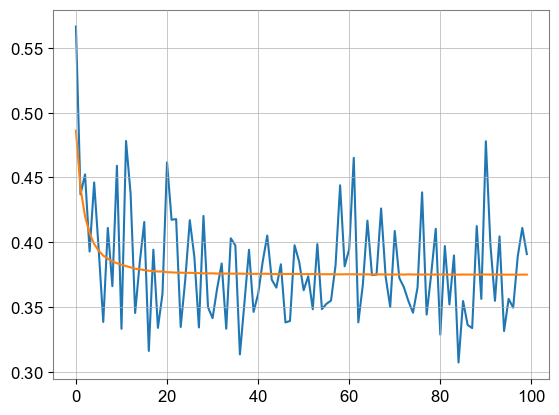

In [87]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
print(sum(p.numel() for p in autoencoder.parameters() if p.requires_grad))

optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))
t0 = time.time()

wNorm = 0

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
    print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

plt.plot(loss_train[:, 0])
plt.plot(loss_validation[:, 0])

torch.save(autoencoder.cuda(), "../data/Datasets/model_200-40_Xcheck_ChiaJui_data.pt")
np.savetxt("../data/Datasets/loss_Xcheck_ChiaJui_data.dat", [loss_train[:, 0], loss_validation[:, 0]])
    
np.savetxt("../data/Datasets/perm_Xcheck_ChiaJui_data.dat", perm)

In [88]:
autoencoder.eval().cpu()

AutoEncoder(
  (layer1): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=100, out_features=40, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=40, out_features=100, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): Tanh()
  )
)

In [94]:
_, decoded_bkgTrain = autoencoder(torch.FloatTensor(X_train))
_, decoded_bkgTest = autoencoder(torch.FloatTensor(X_test))
_, decoded_bbh = autoencoder(torch.FloatTensor(bbh2))

decoded_bkgTrain = decoded_bkgTrain.detach().numpy()
decoded_bkgTest = decoded_bkgTest.detach().numpy()
decoded_bbh = decoded_bbh.detach().numpy()

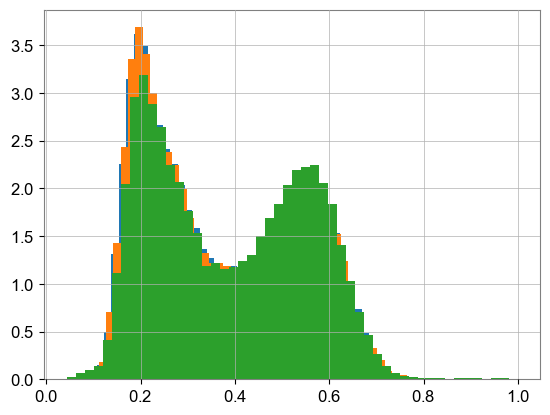

In [95]:
foo = plt.hist(np.mean((X_train-decoded_bkgTrain)**2, axis=1), density=True, bins=50)
foo = plt.hist(np.mean((X_test-decoded_bkgTest)**2, axis=1), density=True, bins=50)
foo = plt.hist(np.mean((bbh2-decoded_bbh)**2, axis=1), density=True, bins=50)

### previous 201-dim DNN

In [82]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(201, 40),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(40, 201),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [64]:
renorm_factor = 20;

In [7]:
bkg_raw = np.load("../data/Datasets/background.npz")['data'][:, 0, :];
bbh_raw = np.load("../data/Datasets/bbh_for_challenge.npy")[:, 0, :];

In [87]:
fake_bkg = np.load("../data/4000Hz25msnoisesample1e6.npy")[100:2*10**5].reshape((10**5-50, 200)) * 1e21

In [46]:
np.mean(bkg[:, -1])

0.47706871687769986

In [47]:
np.mean(bbh[:, -1])

0.4862724306077037

In [52]:
np.mean(fake_bkg[:, -1])

0.46630769353527923

In [34]:
norm = np.transpose([np.linalg.norm(bkg_raw, axis = 1)]);
bkg = np.hstack((bkg_raw/norm, norm / renorm_factor))

norm = np.transpose([np.linalg.norm(bbh_raw, axis = 1)]);
bbh = np.hstack((bbh_raw/norm, norm / renorm_factor))

In [88]:
norm = np.transpose([np.linalg.norm(fake_bkg, axis = 1)]);
fake_bkg = np.hstack((fake_bkg/norm, norm))

In [18]:
# bkg = bkg[::10]

In [90]:
# nTotal = len(bkg);
nTotal = len(fake_bkg);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

perm = np.random.permutation(nTotal)

# X_train = bkg[perm[:nTrain]]
# X_test = bkg[perm[-nTest:]]
# X_validation = bkg[perm[nTrain:-nTest]]

X_train = fake_bkg[perm[:nTrain]]
X_test = fake_bkg[perm[-nTest:]]
X_validation = fake_bkg[perm[nTrain:-nTest]]

In [92]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

for wNorm in [0, 0.1, 1, 10, 100, 1000]:

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    loss_train = np.zeros((epochs, 1))
    loss_validation = np.zeros((epochs, 1))
    t0 = time.time()

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, (x, _) in enumerate(trainDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            # weighted_lossTrain = loss_func(decoded, x)
            loss_overall = loss_func(decoded, x)
            loss_norm = loss_func(decoded[:, -1], x[:, -1])
            weighted_lossTrain = loss_overall + loss_norm * wNorm

            # output_norm = torch.norm(decoded[:, :100], dim=1) 
            # penalty_term = torch.mean((output_norm - 1) ** 2) 
            # weighted_lossTrain = lossTrain + coef_delta * penalty_term

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()

        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, _) in enumerate(validationDataLoader):
                x = x.cuda()
                encoded, decoded = autoencoder(x)
                lossVal_overall = loss_func(decoded, x)
                lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
                lossVal = lossVal_overall + lossVal_norm * wNorm
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch,0] = weighted_lossTrain.item()
        loss_validation[epoch,0] = val_loss
    #     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

    print(time.time() - t0)
    print("Norm weight %f done training" % (wNorm,))
    print(autoencoder.cuda())
    torch.save(autoencoder.cuda(), "../data/model_201-40_weight_%f_fakebkg.pt" % (wNorm,))
    np.savetxt("../data/loss_201-40_weight_%f_fakebkg.dat" % (wNorm,), [loss_train[:, 0], loss_validation[:, 0]])
    
np.savetxt("../data/perm_fakebkg.dat", perm)

1100.9891967773438
Norm weight 0.000000 done training
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=201, out_features=40, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=201, bias=True)
    (1): Tanh()
  )
)
1056.5638000965118
Norm weight 0.100000 done training
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=201, out_features=40, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=201, bias=True)
    (1): Tanh()
  )
)
1068.1610398292542
Norm weight 1.000000 done training
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=201, out_features=40, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=201, bias=True)
    (1): Tanh()
  )
)
1083.5941903591156
Norm weight 10.000000 done training
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=201, out_features=40, bias=True)
   

KeyboardInterrupt: 

# 4-AE, series, updated training

# 4-AE, series, updated training, 2 detector

#### Import the Datasample

In [7]:
renorm_factor = 20;

realbkg = np.load("../data/Datasets/background.npz")['data'] / renorm_factor;
realbbh = np.load("../data/Datasets/bbh_for_challenge.npy") / renorm_factor;

realsg = np.load("../data/Datasets/sglf_for_challenge.npy") / renorm_factor;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch = np.load("../data/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"]

# perm = np.random.permutation(len(realbkg))
perm = np.loadtxt("../data/perm_4ae_bkg.dat").astype("int");
bkg = realbkg[perm, 0][:int(len(perm)*0.7)]
bkg_reserved = realbkg[perm, 0][int(len(perm)*0.7):]
bkg = bkg/np.linalg.norm([bkg], axis=2).T
bkg_reserved = bkg_reserved/np.linalg.norm([bkg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bkg.dat", perm)

# perm = np.random.permutation(len(realbbh))
perm = np.loadtxt("../data/perm_4ae_bbh.dat").astype("int");
bbh = realbbh[perm, 0][:int(len(perm)*0.7)]
bbh_reserved = realbbh[perm, 0][int(len(perm)*0.7):]
bbh = bbh/np.linalg.norm([bbh], axis=2).T
bbh_reserved = bbh_reserved/np.linalg.norm([bbh_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bbh.dat", perm)

# perm = np.random.permutation(len(realsg))
perm = np.loadtxt("../data/perm_4ae_sg.dat").astype("int");
sg = realsg[perm, 0][:int(len(perm)*0.7)]
sg_reserved = realsg[perm, 0][int(len(perm)*0.7):]
sg = sg/np.linalg.norm([sg], axis=2).T
sg_reserved = sg_reserved/np.linalg.norm([sg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_sg.dat", perm)

# perm = np.random.permutation(len(realglitch))
perm = np.loadtxt("../data/perm_4ae_glitch.dat").astype("int");
glitch = realglitch[perm][:int(len(perm)*0.7)]
glitch_reserved = realglitch[perm][int(len(perm)*0.7):]
glitch = glitch/np.linalg.norm([glitch], axis=2).T
glitch_reserved = glitch_reserved/np.linalg.norm([glitch_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_glitch.dat", perm)

FileNotFoundError: [Errno 2] No such file or directory: '../data/Datasets/background.npz'

In [ ]:
bkg_fft = abs(np.fft.rfft(bkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T
bkg_reserved_fft = abs(np.fft.rfft(bkg_reserved))
bkg_reserved_fft = bkg_reserved_fft/np.linalg.norm([bkg_reserved_fft], axis=2).T

bbh_fft = abs(np.fft.rfft(bbh))
bbh_fft = bbh_fft/np.linalg.norm([bbh_fft], axis=2).T
bbh_reserved_fft = abs(np.fft.rfft(bbh_reserved))
bbh_reserved_fft = bbh_reserved_fft/np.linalg.norm([bbh_reserved_fft], axis=2).T

sg_fft = abs(np.fft.rfft(sg))
sg_fft = sg_fft/np.linalg.norm([sg_fft], axis=2).T
sg_reserved_fft = abs(np.fft.rfft(sg_reserved))
sg_reserved_fft = sg_reserved_fft/np.linalg.norm([sg_reserved_fft], axis=2).T

glitch_fft = abs(np.fft.rfft(glitch))
glitch_fft = glitch_fft/np.linalg.norm([glitch_fft], axis=2).T
glitch_reserved_fft = abs(np.fft.rfft(glitch_reserved))
glitch_reserved_fft = glitch_reserved_fft/np.linalg.norm([glitch_reserved_fft], axis=2).T

In [291]:
c0 = {};

In [ ]:
os.chdir('D:\OneDrive - HKUST Connect\Research\GWNMMAD\Codes')

In [6]:
renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/background.npz')['data'].reshape(-1,200) / renorm_factor_0;
realbbh = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy').reshape(-1,200) / renorm_factor_0;

realsg = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy').reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1

In [8]:
## If one is using Chia-Jui's data

renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg_L = np.load('../Data_cached/real_bkg_2202000_63917s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;
realbkg_H = np.load('../Data_cached/real_bkg_H_1466640_58803s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;

realbkg = np.concatenate((realbkg_L, realbkg_H), axis = 1).reshape(-1,200)

realbbh = np.load('../Data_cached/injected_BBH_1823_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;

realsg = np.load('../Data_cached/injected_lfsg_1835_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1

In [126]:
## If one is using Chia-Jui's data, which is for a shorter time

renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg_L = np.load('../Data_cached/real_bkg_504840_23812s_4000Hz_50ms.npy')[:150000].reshape(-1,1,200) / renorm_factor_0;
realbkg_H = np.load('../Data_cached/real_bkg_H_330600_23806s_4000Hz_50ms.npy')[:150000].reshape(-1,1,200) / renorm_factor_0;

realbkg = np.concatenate((realbkg_L, realbkg_H), axis = 1).reshape(-1,200)

realbbh = np.load('../Data_cached/injected_BBH_317_around_merger_time_23812_23806.npz')['strain'].reshape(-1,200) / renorm_factor_0;

realsg = np.load('../Data_cached/injected_lfsg_1835_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1

In [346]:
## If one is using Chia-Jui's data, which is for a much shorter time

renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg_L = np.load('../Data_cached/real_bkg_173160_4096s_4000Hz_50ms.npy')[:100000].reshape(-1,1,200) / renorm_factor_0;
realbkg_H = np.load('../Data_cached/real_bkg_H_114840_4096s_4000Hz_50ms.npy')[:100000].reshape(-1,1,200) / renorm_factor_0;

realbkg = np.concatenate((realbkg_L, realbkg_H), axis = 1).reshape(-1,200)

realbbh = np.load('../Data_cached/injected_BBH_10_around_merger_time_4096_4096.npz')['strain'].reshape(-1,200) / renorm_factor_0;

realsg = np.load('../Data_cached/injected_lfsg_10_around_merger_time_4096_4096.npz')['strain'].reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1

In [153]:
realbbh_snr = np.load('../Data_cached/injected_BBH_317_around_merger_time_23812_23806.npz')['snr']

In [154]:
realbbh_snr

array([  5.26424888,  22.46701083,  15.643536  ,  11.42783886,
        10.8054554 ,  15.34212283,  28.4074662 ,   6.36556352,
       324.90258786,  56.61855949,   6.80986059,   2.12808908,
        17.44886722,   7.09791316,  15.62207663,  33.20842359,
        42.34645081,  18.87620422,  11.2000447 ,  22.23760609,
        24.76715269,  12.23029348,  33.45239691,   9.63105678,
        23.19882668,  84.81579923,  60.24554428,  48.7645702 ,
        50.88782559,   8.65327256,  31.4171025 ,  12.26204339,
        61.2874732 ,   5.39058945,  83.95852818,   4.20870246,
         5.84754606,  22.77272346,  17.34965245, 197.76905345,
        16.51226885,   7.24305863,  31.887684  ,  27.85690443,
        91.74838213,   9.79373962,  25.0794136 ,  18.21668051,
         8.85638126,   7.48055351,  10.32426903,  44.64856159,
         8.20062693,   7.72114445,  15.46529792,  40.50407112,
       249.75049188,   2.76073952,  21.25128606,  15.45357022,
         4.77350493,   4.22155358,  16.84627607,   7.79

In [211]:
realglitch_snr = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")['snr_data'][]

In [237]:
realglitch_L_snr = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")['snr_data'][:50000]

In [347]:
realglitch_H_snr = np.load("../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz")['snr_data'][:50000]

In [219]:
np.argwhere(realglitch_snr > 8).shape

(4574, 1)

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.9446e+04, 4.2610e+03, 1.8510e+03, 1.2490e+03, 7.9100e+02,
        4.7800e+02, 3.3400e+02, 2.1400e+02, 1.4100e+02, 9.1000e+01,
        7.9000e+01, 7.5000e+01, 7.1000e+01, 5.4000e+01, 4.4000e+01,
        5.1000e+01, 4.8000e+01, 2.2000e+01, 2.8000e+01, 2.2000e+01,
        2.5000e+01, 2.1000e+01, 1.7000e+01, 7.0000e+00, 1.6000e+01,
        1.0000e+01, 1.1000e+01, 1.2000e+01, 1.0000e+01, 9.0000e+00,
        9.0000e+00, 5.0000e+00, 1.1000e+01, 1.2000e+01, 1.5000e+01,
        6.0000e+00, 6.0000e+00, 8.0000e+00, 6.0000e+00, 6.0000e+00,
        2.0000e+00, 7.0000e+00, 5.0000e+00, 2.0000e+00, 6.0000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <BarContainer object of 50 a

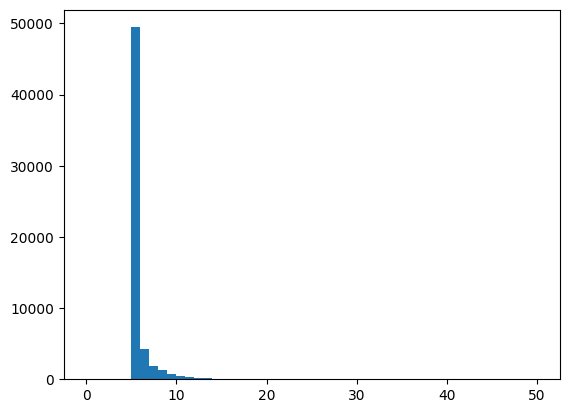

In [217]:
plt.hist(realglitch_snr, range = (0,50), bins = 50)

In [191]:
realbkg.shape

(200000, 200)

In [295]:
realglitch_L.shape

(50000, 1, 200)

In [15]:
realglitch = np.concatenate((realglitch_L, realglitch_H), axis = 1).reshape(-1,200)

In [10]:
realglitch.shape

(100000, 200)

In [11]:
perm_L = np.arange(len(realglitch_L))
np.random.shuffle(perm_L)

In [13]:
realglitch_L = realglitch_L[perm_L.flatten()]
realglitch_L_snr = realglitch_L_snr[perm_L.flatten()]

NameError: name 'realglitch_L_snr' is not defined

In [14]:
realglitch_L.shape

(50000, 1, 200)

In [350]:
perm_H = np.arange(len(realglitch_H))
np.random.shuffle(perm_H)
realglitch_H = realglitch_H[perm_H.flatten()]
realglitch_H_snr = realglitch_H_snr[perm_H.flatten()]
realglitch_H.shape

(50000, 1, 200)

#### Build the glitch datasample (Glitch event = noise event in one detector + glitch in the other)

In [175]:
noise_first50k = realbkg.reshape(-1,2,200)[:50000]

glitch_L_noise_H = np.concatenate((realglitch_L, noise_first50k[:,[1],:]), axis = 1)
glitch_H_noise_L = np.concatenate((realglitch_H, noise_first50k[:,[0],:]), axis = 1)

In [176]:
realglitch = np.vstack((glitch_L_noise_H, glitch_H_noise_L))
np.random.shuffle(realglitch)
realglitch = realglitch.reshape(-1,200)

In [177]:
realbkg = realbkg[100000:]

In [178]:
realbkg.shape

(100000, 200)

#### Package the dataset

In [17]:
# perm = np.random.permutation(len(realbkg))
# perm = np.loadtxt("../data/perm_4ae_bkg.dat").astype("int");

bkg = realbkg[:int(len(realbkg)*0.7)]
bkg_reserved = realbkg[int(len(realbkg)*0.7):]
bkg = bkg/np.linalg.norm([bkg], axis=2).T
bkg_reserved = bkg_reserved/np.linalg.norm([bkg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bkg.dat", perm)

# perm = np.random.permutation(len(realbbh))
# perm = np.loadtxt("../data/perm_4ae_bbh.dat").astype("int");
# perm = np.arange(1e5)
bbh = realbbh[:int(len(realbbh)*0.7) - int(len(realbbh)*0.7)%2]
bbh_reserved = realbbh[int(len(realbbh)*0.7) - int(len(realbbh)*0.7)%2:]
bbh = bbh/np.linalg.norm([bbh], axis=2).T
bbh_reserved = bbh_reserved/np.linalg.norm([bbh_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bbh.dat", perm)

# perm = np.random.permutation(len(realsg))
# perm = np.loadtxt("../data/perm_4ae_sg.dat").astype("int");
# perm = np.arange(1e5)
sg = realsg[:int(len(realsg)*0.7) - int(len(realsg)*0.7) % 2]
sg_reserved = realsg[int(len(realsg)*0.7) - int(len(realsg)*0.7) % 2:]
sg = sg/np.linalg.norm([sg], axis=2).T
sg_reserved = sg_reserved/np.linalg.norm([sg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_sg.dat", perm)

# perm = np.random.permutation(len(realglitch))
# perm = np.loadtxt("../data/perm_4ae_glitch.dat").astype("int");
# perm = np.arange(60132)
glitch = realglitch[:int(len(realglitch)*0.7)]
glitch_reserved = realglitch[int(len(realglitch)*0.7):]
glitch = glitch/np.linalg.norm([glitch], axis=2).T
glitch_reserved = glitch_reserved/np.linalg.norm([glitch_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_glitch.dat", perm)

In [353]:
bkg_fft = bkg
bkg_reserved_fft = bkg_reserved

bbh_fft = bbh
bbh_reserved_fft = bbh_reserved

sg_fft = sg
sg_reserved_fft = sg_reserved

glitch_fft = glitch
glitch_reserved_fft = glitch_reserved

In [18]:
bkg_fft = abs(np.fft.rfft(bkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T
bkg_reserved_fft = abs(np.fft.rfft(bkg_reserved))
bkg_reserved_fft = bkg_reserved_fft/np.linalg.norm([bkg_reserved_fft], axis=2).T

bbh_fft = abs(np.fft.rfft(bbh))
bbh_fft = bbh_fft/np.linalg.norm([bbh_fft], axis=2).T
bbh_reserved_fft = abs(np.fft.rfft(bbh_reserved))
bbh_reserved_fft = bbh_reserved_fft/np.linalg.norm([bbh_reserved_fft], axis=2).T

sg_fft = abs(np.fft.rfft(sg))
sg_fft = sg_fft/np.linalg.norm([sg_fft], axis=2).T
sg_reserved_fft = abs(np.fft.rfft(sg_reserved))
sg_reserved_fft = sg_reserved_fft/np.linalg.norm([sg_reserved_fft], axis=2).T

glitch_fft = abs(np.fft.rfft(glitch))
glitch_fft = glitch_fft/np.linalg.norm([glitch_fft], axis=2).T
glitch_reserved_fft = abs(np.fft.rfft(glitch_reserved))
glitch_reserved_fft = glitch_reserved_fft/np.linalg.norm([glitch_reserved_fft], axis=2).T

In [19]:
bkg_fft = bkg_fft.reshape(-1,202)
bkg_reserved_fft = bkg_reserved_fft.reshape(-1,202)

bbh_fft = bbh_fft.reshape(-1,202)
bbh_reserved_fft = bbh_reserved_fft.reshape(-1,202)

sg_fft = sg_fft.reshape(-1,202)
sg_reserved_fft = sg_reserved_fft.reshape(-1,202)

glitch_fft = glitch_fft.reshape(-1,202)
glitch_reserved_fft = glitch_reserved_fft.reshape(-1,202)

In [106]:
bbh_snr = realbbh_snr[:int(len(realbbh_snr)*0.7)]

NameError: name 'realbbh_snr' is not defined

In [162]:
realbbh_snr.shape

(317,)

In [163]:
bbh_snr.shape

(221,)

In [256]:
bkg_fft.shape

(70000, 202)

In [108]:
bbh_fft.shape

(7, 202)

In [109]:
bbh_fft.shape

(7, 202)

In [20]:
glitch_fft.shape

(35000, 202)

#### Define the model

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(200, 40),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(40, 200),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [21]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [60]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(202, 40),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(40, 202),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [139]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(202, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 202),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [222]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(202, 10),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 202),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [60]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(202, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 202),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [308]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(202, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 202),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [104]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(202, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 202),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

## finding a rough boundary for the stepwise filtering

In [ ]:
# Ncut = 10;

# max_glitch = 0.0026;
# min_glitch = 0.001;

In [111]:
list_datatype = ["noise", "bbh", "sg", "glitch"];

### Step 1: glitch

In [116]:
models = {};

In [200]:
t0 = time.time()
dataset = glitch_fft;

nTotal = len(dataset);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

X_train = dataset[:nTrain]
X_test = dataset[-nTest:]
X_validation = dataset[nTrain:-nTest]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros(epochs)
loss_validation = np.zeros(epochs)

wNorm = 0;

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = weighted_lossTrain.item()
    loss_validation[epoch] = val_loss
    
plt.plot(loss_train)
plt.plot(loss_validation)

print(time.time() - t0)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x202 and 101x20)

129.68903040885925


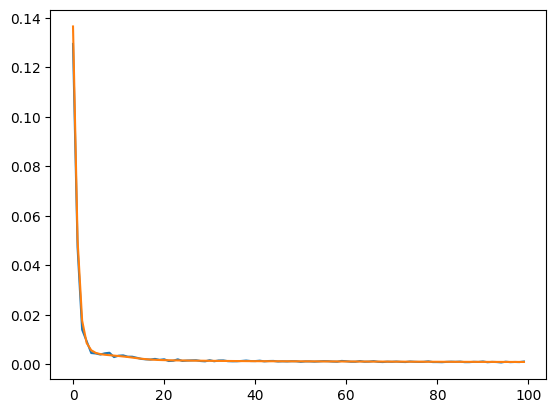

In [356]:
t0 = time.time()
dataset = glitch_fft[:,101:];

nTotal = len(dataset);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

X_train = dataset[:nTrain]
X_test = dataset[-nTest:]
X_validation = dataset[nTrain:-nTest]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros(epochs)
loss_validation = np.zeros(epochs)

wNorm = 0;

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = weighted_lossTrain.item()
    loss_validation[epoch] = val_loss
    
plt.plot(loss_train)
plt.plot(loss_validation)

print(time.time() - t0)

In [308]:
torch.save(autoencoder.cpu(), '../Model_cached/1_det_H_glitch_trained_with_permutation_1.pt')

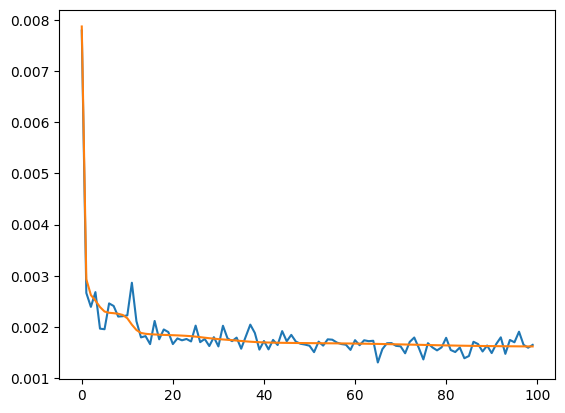

In [312]:
plt.plot(loss_train)
plt.plot(loss_validation)

In [260]:
currentStep = 'glitch'

In [261]:
autoencoder.cpu().eval();
models[currentStep] = copy.deepcopy(autoencoder);

In [120]:
c0 = {}

In [262]:
models

{'glitch': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=101, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=101, bias=True)
     (1): Sigmoid()
   )
 ),
 'noise': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=202, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=202, bias=True)
     (1): Sigmoid()
   )
 )}

In [263]:
bkg_fft.shape

(70000, 202)

In [264]:
bbh_fft.shape

(7, 202)

In [265]:
glitch_fft.shape

(35000, 202)

In [266]:
glitch_reserved_fft.shape

(15000, 202)

### Below is the draft for looking the distribution. Don't take it too seriously

In [227]:
np.argwhere(realglitch_L_snr[:35000] > 8).flatten().shape

(3459,)

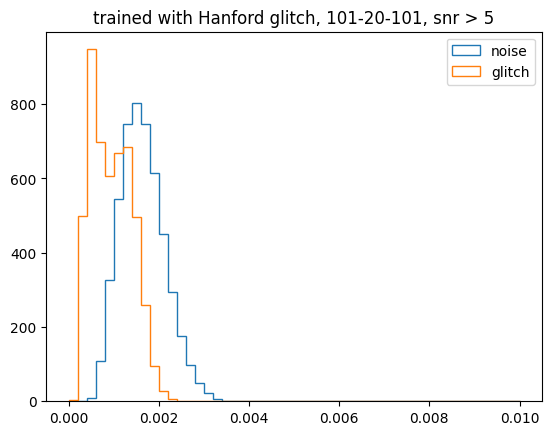

In [357]:
# How about noise from a much shorter time(4096s), also for one detector? for Hanford

model = autoencoder.cpu()

c0["glitch"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_reserved_fft[:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_reserved_fft[:,101:]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,101:]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,101:]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Hanford glitch, 101-20-101, snr > 5")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

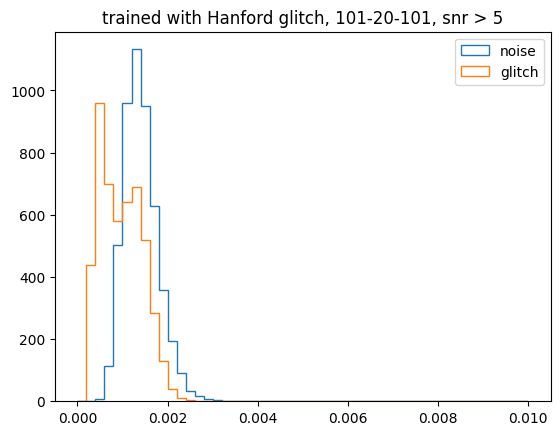

In [309]:
# How about noise from a much shorter time(4096s), also for one detector? for Hanford

model = autoencoder.cpu()

c0["glitch"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_reserved_fft[:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_reserved_fft[:,101:]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,101:]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,101:]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Hanford glitch, 101-20-101, snr > 5")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

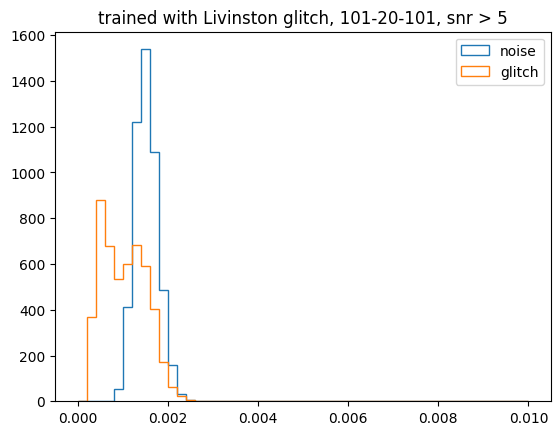

In [267]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch"]

c0["glitch"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_reserved_fft[:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_reserved_fft[:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Livinston glitch, 101-20-101, snr > 5")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

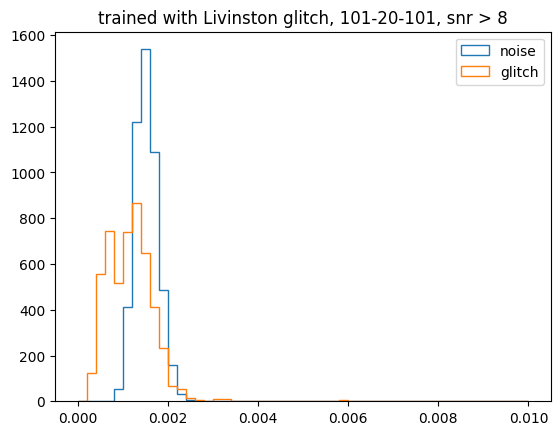

In [270]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch"]

c0["glitch"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_reserved_fft[:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_reserved_fft[:,:101][np.argwhere(realglitch_L_snr[35000:] > 8).flatten()]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,:101][np.argwhere(realglitch_L_snr[35000:] > 8).flatten()]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Livinston glitch, 101-20-101, snr > 8")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

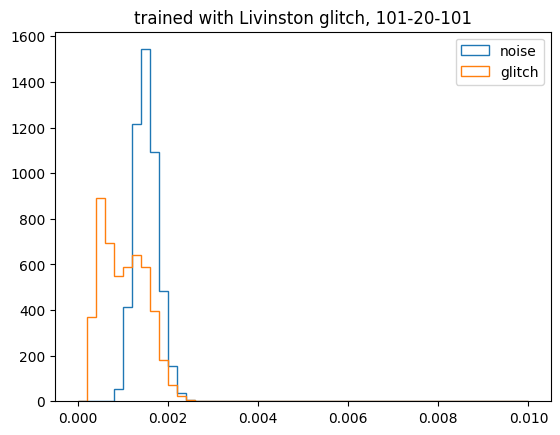

In [268]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch"]

c0["glitch"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_fft[:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft[:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft[:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft[:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Livinston glitch, 101-20-101")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

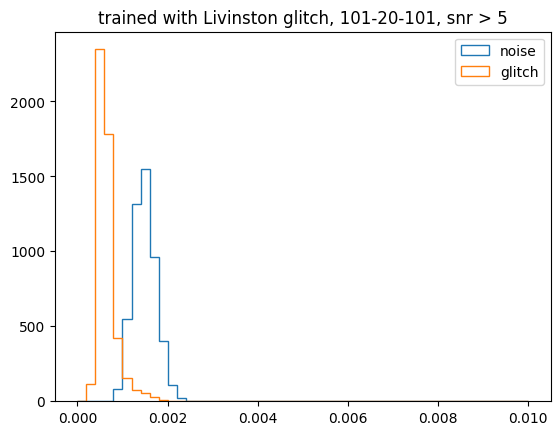

In [232]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch"]

c0["glitch"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_reserved_fft[:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_reserved_fft[:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Livinston glitch, 101-20-101, snr > 5")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

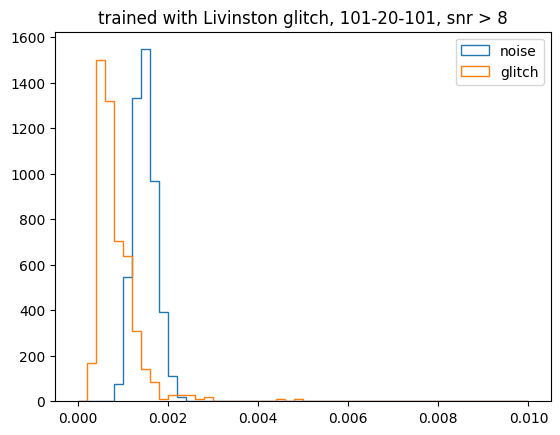

In [229]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch"]

c0["glitch"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_fft[:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_reserved_fft[:,:101][np.argwhere(realglitch_L_snr[35000:] > 8).flatten()]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft[:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,:101][np.argwhere(realglitch_L_snr[35000:] > 8).flatten()]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Livinston glitch, 101-20-101, snr > 8")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

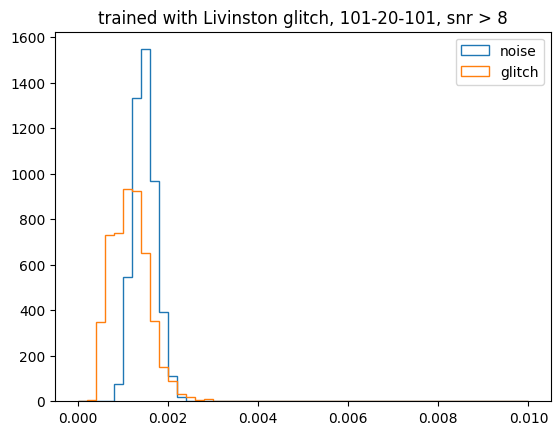

In [233]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch"]

c0["glitch"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_fft[:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft[:,:101][np.argwhere(realglitch_L_snr[:35000] > 8).flatten()]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft[:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft[:,:101][np.argwhere(realglitch_L_snr[:35000] > 8).flatten()]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Livinston glitch, 101-20-101, snr > 8")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

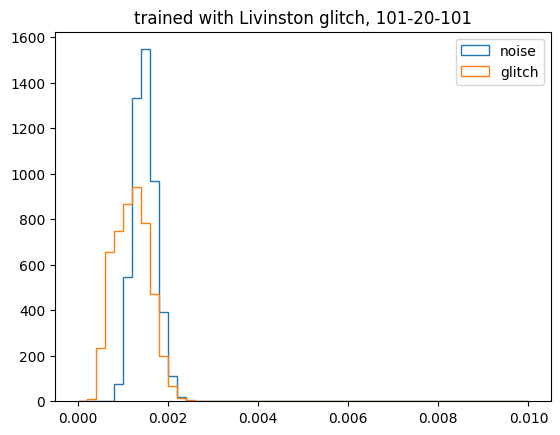

In [207]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch"]

c0["glitch"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_fft[:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft[:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft[:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft[:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Livinston glitch, 101-20-101")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

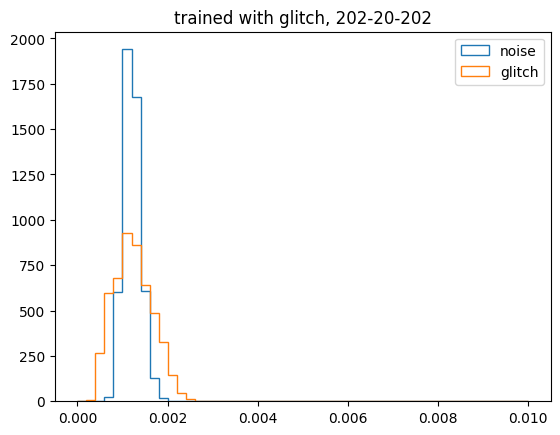

In [188]:
# How about noise from a much shorter time(4096s)?

model = models["glitch"]

c0["glitch"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch, 202-20-202")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

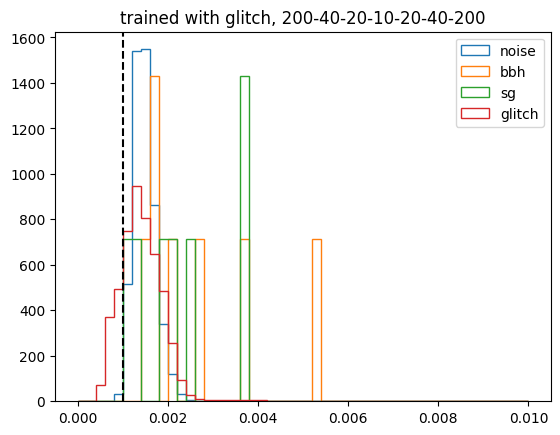

In [121]:
# How about noise from a much shorter time(4096s)?

model = models["glitch"]

c0["glitch"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch, 200-40-20-10-20-40-200")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

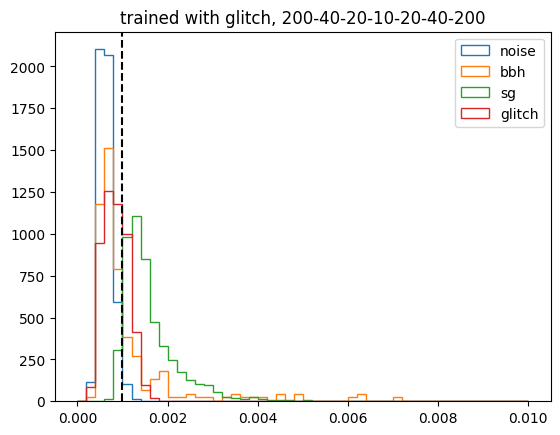

In [146]:
# How about noise from a shorter time?

model = models["glitch"]

c0["glitch"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch, 200-40-20-10-20-40-200")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

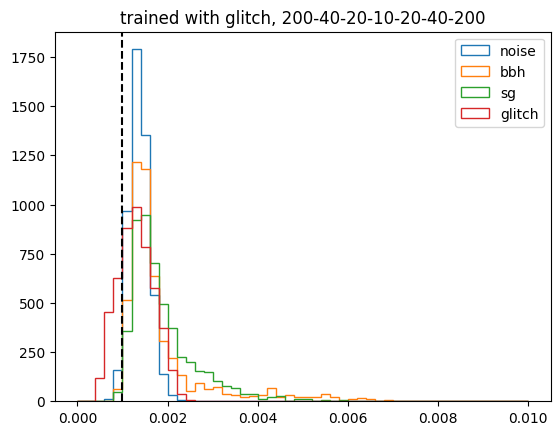

In [112]:
model = models["glitch"]

c0["glitch"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch, 200-40-20-10-20-40-200")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

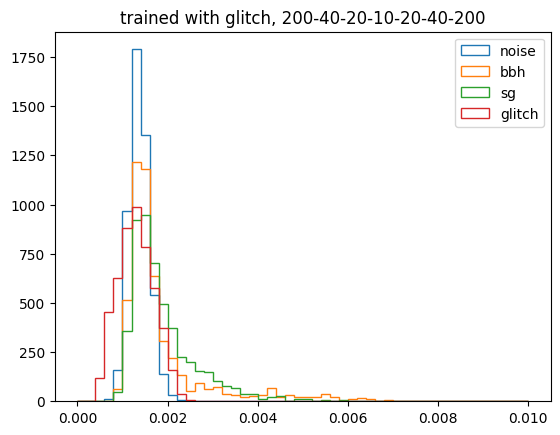

In [116]:
model = models["glitch"]

c0["glitch"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch, 200-40-20-10-20-40-200")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

In [114]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=202, bias=True)
    (5): Sigmoid()
  )
)

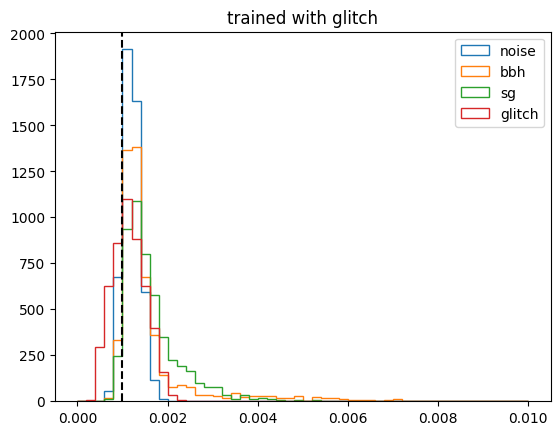

In [38]:
model = models["glitch"]

c0["glitch"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

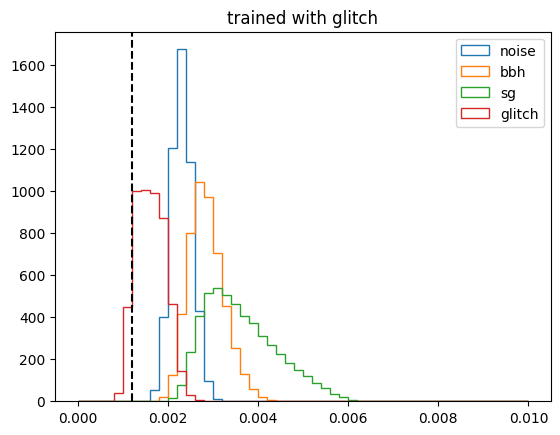

In [315]:
model = models["glitch"]

c0["glitch"] = 0.0012;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

In [24]:
bkg_filtered = bkg_fft
sg_filtered = sg_fft
bbh_filtered = bbh_fft

##### Think about 2 glitch or one noise+one glitch

2 glitches trained model, one noise+one glitch performance

result for 2 glitches glitch sample

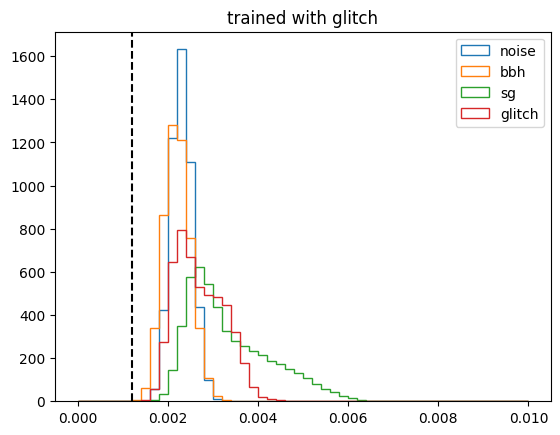

In [77]:
# This is the model for two glitch trained, noise and signal are GWAK

model = models["glitch"]

c0["glitch"] = 0.0012;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

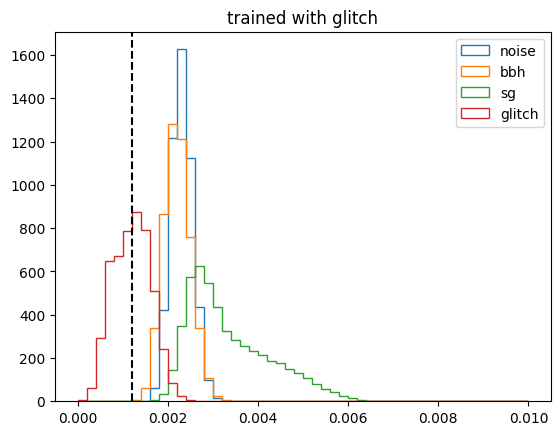

In [67]:
# This is the model for two glitch trained, noise and signal are GWAK

model = models["glitch"]

c0["glitch"] = 0.0012;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

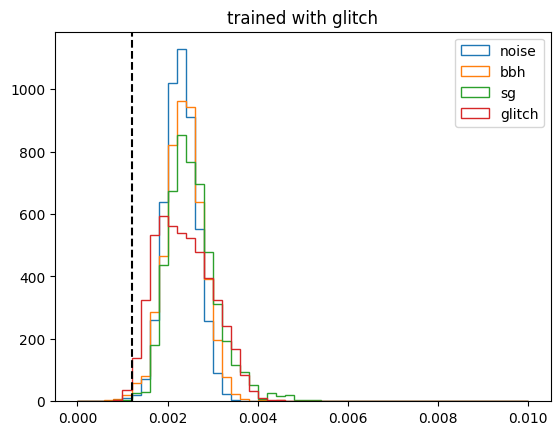

In [50]:
# This is the model for two glitch trained, noise and signal are Chia-Jui

model = models["glitch"]

c0["glitch"] = 0.0012;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

In [51]:
glitch_fft.shape

(70000, 202)

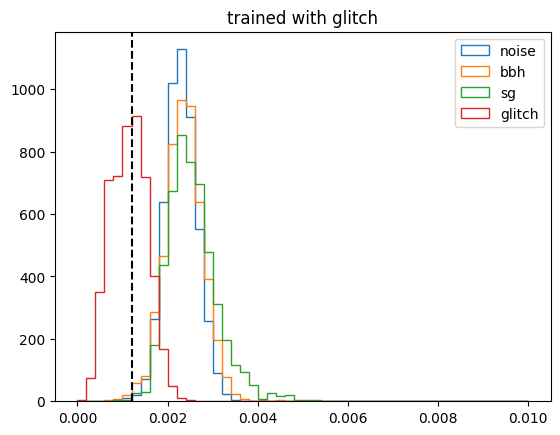

In [37]:
# This is the model for two glitch trained, noise and signal are Chia-Jui

model = models["glitch"]

c0["glitch"] = 0.0012;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

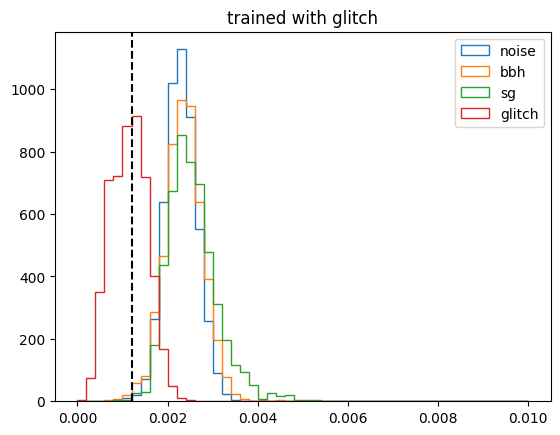

In [25]:
# This is the model for two glitch trained, noise and signal are Chia-Jui

model = models["glitch"]

c0["glitch"] = 0.0012;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

In [29]:
torch.save(model, 'model_2detDNN_two_glitch_trained.pt')

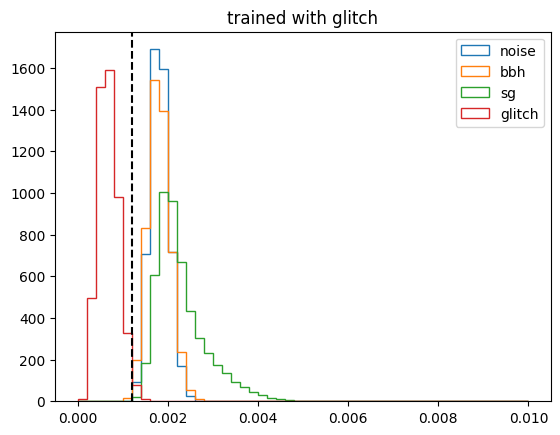

In [ ]:
model = models["glitch"]

c0["glitch"] = 0.0012;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

result for one glitch+one noise sample

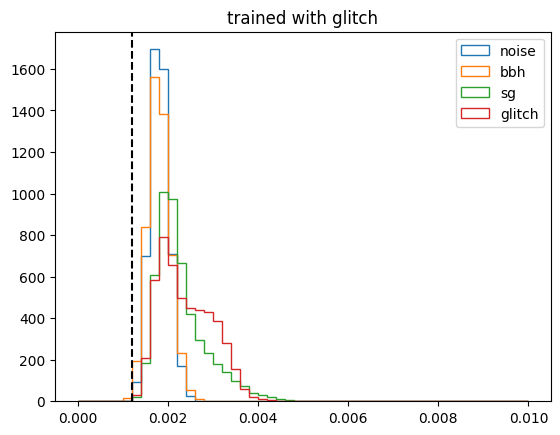

In [108]:
model = models["glitch"]

c0["glitch"] = 0.0012;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

one glitch+one noise trained model

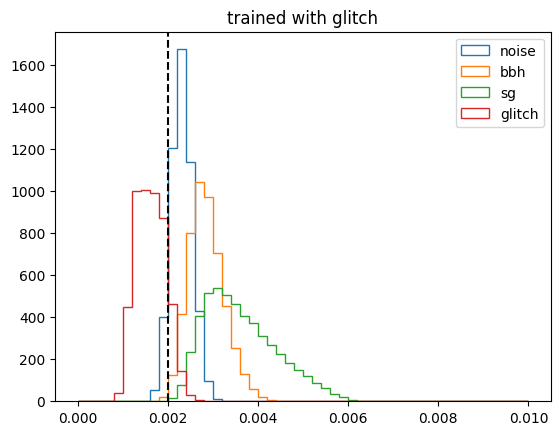

In [318]:
model = models["glitch"]

c0["glitch"] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

In [173]:
models['glitch'] = torch.load('../Model_cached/2_det_oneglitchonenoise_trained.pt')

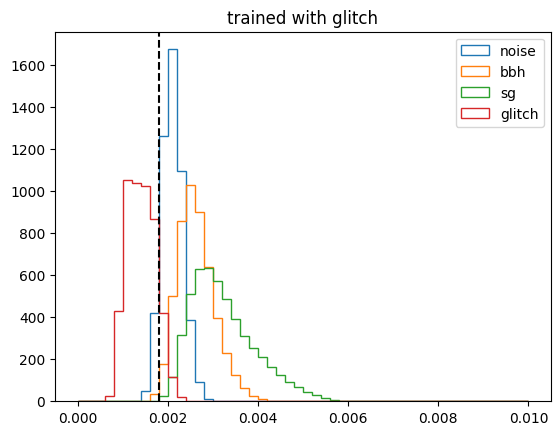

In [174]:
model = models["glitch"]

c0["glitch"] = 0.0018;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

In [175]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=20, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=202, bias=True)
    (1): Sigmoid()
  )
)

Seems pretty good and we'll use the reserved data to see its robustness

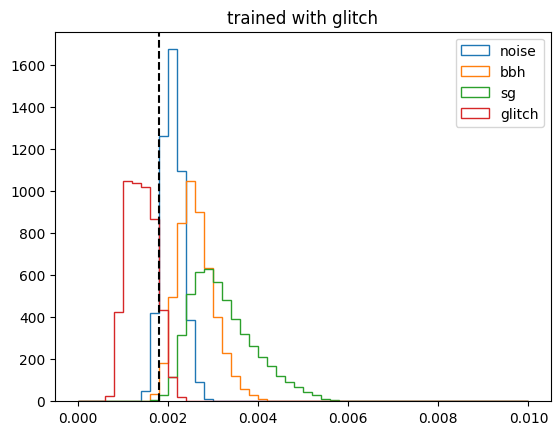

In [121]:
model = models["glitch"]

c0["glitch"] = 0.0018;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_reserved_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

using new hyperparameter 202-40-20-40-202

In [31]:
c0 = {}

In [112]:
models['glitch'] = torch.load('../Model_cached/2_det_oneglitchonenoise_trained_202-40-20-40-202.pt')

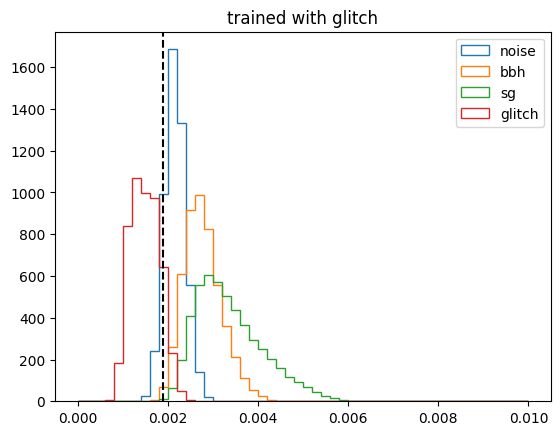

In [34]:
model = models["glitch"]

c0["glitch"] = 0.0019;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

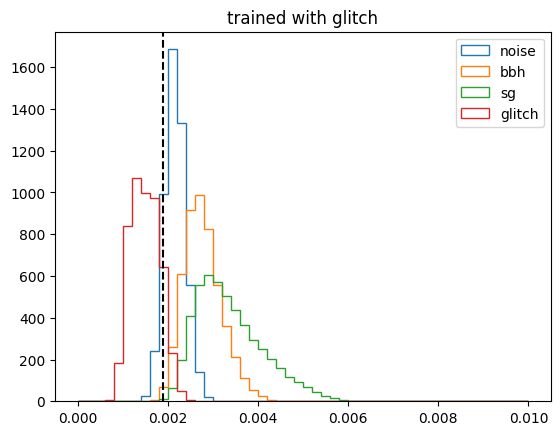

In [113]:
model = models["glitch"]

c0["glitch"] = 0.0019;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

In [35]:
model = models['glitch']
torch.save(model, '../Model_cached/2_det_oneglitchonenoise_trained_202-40-20-40-202.pt')

using new hyperparameter 202-20-10-20-202

In [153]:
models['glitch'] = torch.load('../Model_cached/2_det_oneglitchonenoise_trained_202-20-10-20-202.pt')

In [154]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=20, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=202, bias=True)
    (1): Sigmoid()
  )
)

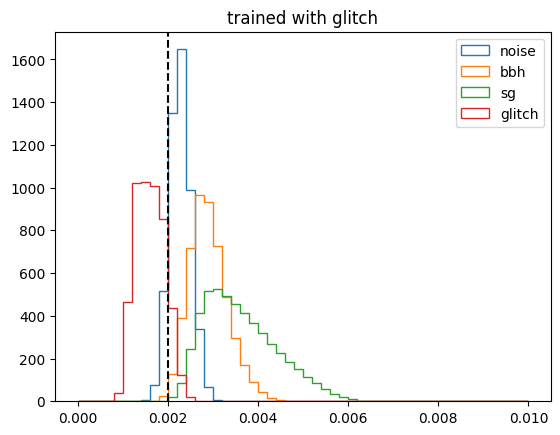

In [100]:
model = models["glitch"]

c0["glitch"] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

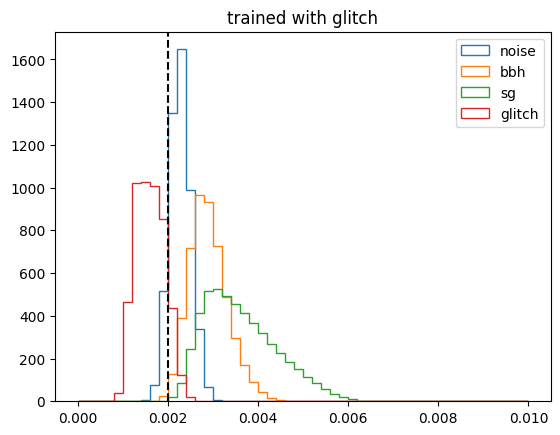

In [155]:
model = models["glitch"]

c0["glitch"] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

In [156]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=202, bias=True)
    (3): Sigmoid()
  )
)

In [113]:
model = models['glitch']
torch.save(model, '../Model_cached/2_det_oneglitchonenoise_full_Chia-Jui_set_glitch_trained_20ks_202-20-10-20-202.pt')

In [114]:
model = models['noise']
torch.save(model, '../Model_cached/2_det_oneglitchonenoise_full_Chia-Jui_set_noise_trained_20ks_202-20-10-20-202.pt')

In [115]:
models['noise']

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=202, bias=True)
    (3): Sigmoid()
  )
)

### Now we are trying to do a different thing. I'm thinking about can we just use one detector for glitch identification and do WSL later

#### Building the training sample and the reserving sample. The training sample is for each detector while the reserving sample is two-detector combined

In [284]:
## If one is using GWAK data

renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/background.npz')['data'].reshape(-1,200) / renorm_factor_0;
realbbh = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy').reshape(-1,200) / renorm_factor_0;

realsg = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy').reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1

In [261]:
## If one is using Chia-Jui's data, which is for a much shorter time

renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg_L = np.load('../Data_cached/real_bkg_173160_4096s_4000Hz_50ms.npy')[:100000].reshape(-1,1,200) / renorm_factor_0;
realbkg_H = np.load('../Data_cached/real_bkg_H_114840_4096s_4000Hz_50ms.npy')[:100000].reshape(-1,1,200) / renorm_factor_0;

realbkg = np.concatenate((realbkg_L, realbkg_H), axis = 1).reshape(-1,200)

realbbh = np.load('../Data_cached/injected_BBH_10_around_merger_time_4096_4096.npz')['strain'].reshape(-1,200) / renorm_factor_0;

realsg = np.load('../Data_cached/injected_lfsg_10_around_merger_time_4096_4096.npz')['strain'].reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1

In [285]:
realglitch_L_snr = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")['snr_data'][:50000]
realglitch_H_snr = np.load("../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz")['snr_data'][:50000]
perm_L = np.arange(len(realglitch_L))
perm_H = np.arange(len(realglitch_H))
np.random.shuffle(perm_L)
np.random.shuffle(perm_H)
realglitch_L = realglitch_L[perm_L.flatten()]
realglitch_L_snr = realglitch_L_snr[perm_L.flatten()]
realglitch_H = realglitch_H[perm_H.flatten()]
realglitch_H_snr = realglitch_H_snr[perm_H.flatten()]

In [263]:
realglitch = np.concatenate((realglitch_L, realglitch_H), axis = 1).reshape(-1,200)

In [286]:
noise_first15k = realbkg.reshape(-1,2,200)[:15000]

glitch_L_noise_H = np.concatenate((realglitch_L[-15000:], noise_first15k[:,[1],:]), axis = 1)
glitch_H_noise_L = np.concatenate((noise_first15k[:,[0],:], realglitch_H[-15000:]), axis = 1)
realglitch = np.vstack((glitch_L_noise_H, glitch_H_noise_L))
np.random.shuffle(realglitch)
realglitch = realglitch.reshape(-1,200)

realbkg = realbkg[30000:]

In [116]:
noise_first15k = realbkg.reshape(-1,2,200)[15000:30000]

glitch_L_noise_H = np.concatenate((realglitch_L[-30000:-15000], noise_first15k[:,[1],:]), axis = 1)
glitch_H_noise_L = np.concatenate((noise_first15k[:,[0],:], realglitch_H[-30000:-15000]), axis = 1)
realglitch = np.vstack((glitch_L_noise_H, glitch_H_noise_L))
np.random.shuffle(realglitch)
realglitch = realglitch.reshape(-1,200)

realbkg = realbkg[60000:]

In [287]:
realglitch_L.shape

(50000, 1, 200)

In [288]:
realglitch.shape

(60000, 200)

In [289]:
# perm = np.random.permutation(len(realbkg))
# perm = np.loadtxt("../data/perm_4ae_bkg.dat").astype("int");

bkg = realbkg[:int(len(realbkg)*0.7) - int(len(realbkg)*0.7)%2]
bkg_reserved = realbkg[int(len(realbkg)*0.7) - int(len(realbkg)*0.7)%2:]
bkg = bkg/np.linalg.norm([bkg], axis=2).T
bkg_reserved = bkg_reserved/np.linalg.norm([bkg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bkg.dat", perm)

# perm = np.random.permutation(len(realbbh))
# perm = np.loadtxt("../data/perm_4ae_bbh.dat").astype("int");
# perm = np.arange(1e5)
bbh = realbbh[:int(len(realbbh)*0.7) - int(len(realbbh)*0.7)%2]
bbh_reserved = realbbh[int(len(realbbh)*0.7) - int(len(realbbh)*0.7)%2:]
bbh = bbh/np.linalg.norm([bbh], axis=2).T
bbh_reserved = bbh_reserved/np.linalg.norm([bbh_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bbh.dat", perm)

# perm = np.random.permutation(len(realsg))
# perm = np.loadtxt("../data/perm_4ae_sg.dat").astype("int");
# perm = np.arange(1e5)
sg = realsg[:int(len(realsg)*0.7) - int(len(realsg)*0.7) % 2]
sg_reserved = realsg[int(len(realsg)*0.7) - int(len(realsg)*0.7) % 2:]
sg = sg/np.linalg.norm([sg], axis=2).T
sg_reserved = sg_reserved/np.linalg.norm([sg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_sg.dat", perm)

# perm = np.random.permutation(len(realglitch))
# perm = np.loadtxt("../data/perm_4ae_glitch.dat").astype("int");
# perm = np.arange(60132)
# glitch = realglitch[:int(len(realglitch)*0.7)]
# glitch_reserved = realglitch[int(len(realglitch)*0.7):]
# glitch = glitch/np.linalg.norm([glitch], axis=2).T
# glitch_reserved = glitch_reserved/np.linalg.norm([glitch_reserved], axis=2).T

glitch = np.concatenate((realglitch_L[:-15000], realglitch_H[:-15000]), axis = 1).reshape(-1,200)
glitch_reserved = realglitch[:60000]
glitch = glitch/np.linalg.norm([glitch], axis=2).T
glitch_reserved = glitch_reserved/np.linalg.norm([glitch_reserved], axis=2).T

In [119]:
# perm = np.random.permutation(len(realbkg))
# perm = np.loadtxt("../data/perm_4ae_bkg.dat").astype("int");

bkg = realbkg[:int(len(realbkg)*0.7) - int(len(realbkg)*0.7)%2]
bkg_reserved = realbkg[int(len(realbkg)*0.7) - int(len(realbkg)*0.7)%2:]
bkg = bkg/np.linalg.norm([bkg], axis=2).T
bkg_reserved = bkg_reserved/np.linalg.norm([bkg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bkg.dat", perm)

# perm = np.random.permutation(len(realbbh))
# perm = np.loadtxt("../data/perm_4ae_bbh.dat").astype("int");
# perm = np.arange(1e5)
bbh = realbbh[:int(len(realbbh)*0.7) - int(len(realbbh)*0.7)%2]
bbh_reserved = realbbh[int(len(realbbh)*0.7) - int(len(realbbh)*0.7)%2:]
bbh = bbh/np.linalg.norm([bbh], axis=2).T
bbh_reserved = bbh_reserved/np.linalg.norm([bbh_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bbh.dat", perm)

# perm = np.random.permutation(len(realsg))
# perm = np.loadtxt("../data/perm_4ae_sg.dat").astype("int");
# perm = np.arange(1e5)
sg = realsg[:int(len(realsg)*0.7) - int(len(realsg)*0.7) % 2]
sg_reserved = realsg[int(len(realsg)*0.7) - int(len(realsg)*0.7) % 2:]
sg = sg/np.linalg.norm([sg], axis=2).T
sg_reserved = sg_reserved/np.linalg.norm([sg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_sg.dat", perm)

# perm = np.random.permutation(len(realglitch))
# perm = np.loadtxt("../data/perm_4ae_glitch.dat").astype("int");
# perm = np.arange(60132)
# glitch = realglitch[:int(len(realglitch)*0.7)]
# glitch_reserved = realglitch[int(len(realglitch)*0.7):]
# glitch = glitch/np.linalg.norm([glitch], axis=2).T
# glitch_reserved = glitch_reserved/np.linalg.norm([glitch_reserved], axis=2).T

glitch = np.concatenate((realglitch_L[:-15000], realglitch_H[:-15000]), axis = 1).reshape(-1,200)
glitch_reserved = realglitch[:60000]
glitch = glitch/np.linalg.norm([glitch], axis=2).T
glitch_reserved = glitch_reserved/np.linalg.norm([glitch_reserved], axis=2).T


glitch_reserved_for_wsl_training = realglitch[60000:]
glitch_reserved_for_wsl_training = glitch_reserved_for_wsl_training/np.linalg.norm([glitch_reserved_for_wsl_training], axis=2).T

# np.savetxt("../data/perm_4ae_glitch.dat", perm)

In [290]:
bkg_fft = abs(np.fft.rfft(bkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T
bkg_reserved_fft = abs(np.fft.rfft(bkg_reserved))
bkg_reserved_fft = bkg_reserved_fft/np.linalg.norm([bkg_reserved_fft], axis=2).T

bbh_fft = abs(np.fft.rfft(bbh))
bbh_fft = bbh_fft/np.linalg.norm([bbh_fft], axis=2).T
bbh_reserved_fft = abs(np.fft.rfft(bbh_reserved))
bbh_reserved_fft = bbh_reserved_fft/np.linalg.norm([bbh_reserved_fft], axis=2).T

sg_fft = abs(np.fft.rfft(sg))
sg_fft = sg_fft/np.linalg.norm([sg_fft], axis=2).T
sg_reserved_fft = abs(np.fft.rfft(sg_reserved))
sg_reserved_fft = sg_reserved_fft/np.linalg.norm([sg_reserved_fft], axis=2).T

glitch_fft = abs(np.fft.rfft(glitch))
glitch_fft = glitch_fft/np.linalg.norm([glitch_fft], axis=2).T
glitch_reserved_fft = abs(np.fft.rfft(glitch_reserved))
glitch_reserved_fft = glitch_reserved_fft/np.linalg.norm([glitch_reserved_fft], axis=2).T

In [120]:
bkg_fft = abs(np.fft.rfft(bkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T
bkg_reserved_fft = abs(np.fft.rfft(bkg_reserved))
bkg_reserved_fft = bkg_reserved_fft/np.linalg.norm([bkg_reserved_fft], axis=2).T

bbh_fft = abs(np.fft.rfft(bbh))
bbh_fft = bbh_fft/np.linalg.norm([bbh_fft], axis=2).T
bbh_reserved_fft = abs(np.fft.rfft(bbh_reserved))
bbh_reserved_fft = bbh_reserved_fft/np.linalg.norm([bbh_reserved_fft], axis=2).T

sg_fft = abs(np.fft.rfft(sg))
sg_fft = sg_fft/np.linalg.norm([sg_fft], axis=2).T
sg_reserved_fft = abs(np.fft.rfft(sg_reserved))
sg_reserved_fft = sg_reserved_fft/np.linalg.norm([sg_reserved_fft], axis=2).T

glitch_fft = abs(np.fft.rfft(glitch))
glitch_fft = glitch_fft/np.linalg.norm([glitch_fft], axis=2).T
glitch_reserved_fft = abs(np.fft.rfft(glitch_reserved))
glitch_reserved_fft = glitch_reserved_fft/np.linalg.norm([glitch_reserved_fft], axis=2).T

glitch_reserved_fft_for_wsl_training = abs(np.fft.rfft(glitch_reserved_for_wsl_training))
glitch_reserved_fft_for_wsl_training = glitch_reserved_fft_for_wsl_training/np.linalg.norm([glitch_reserved_fft_for_wsl_training], axis=2).T

In [291]:
realbkg.shape

(170000, 200)

In [122]:
glitch_reserved_for_wsl_training.shape

(60000, 200)

In [124]:
glitch_reserved.shape

(60000, 200)

In [123]:
realglitch.shape

(120000, 200)

In [292]:
bkg_fft = bkg_fft.reshape(-1,202)
bkg_reserved_fft = bkg_reserved_fft.reshape(-1,202)

bbh_fft = bbh_fft.reshape(-1,202)
bbh_reserved_fft = bbh_reserved_fft.reshape(-1,202)

sg_fft = sg_fft.reshape(-1,202)
sg_reserved_fft = sg_reserved_fft.reshape(-1,202)

glitch_fft = glitch_fft.reshape(-1,202)
glitch_reserved_fft = glitch_reserved_fft.reshape(-1,202)


In [125]:
glitch_reserved_fft_for_wsl_training = glitch_reserved_fft_for_wsl_training.reshape(-1,202)

In [293]:
glitch_reserved_fft.shape

(30000, 202)

In [88]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [89]:
list_datatype = ["noise", "bbh", "sg", "glitch"];

models = {}

133.61786794662476


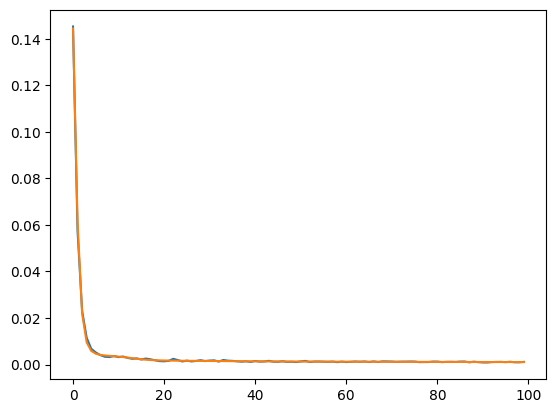

In [17]:
t0 = time.time()
dataset = glitch_fft[:,:101];

nTotal = len(dataset);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

X_train = dataset[:nTrain]
X_test = dataset[-nTest:]
X_validation = dataset[nTrain:-nTest]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros(epochs)
loss_validation = np.zeros(epochs)

wNorm = 0;

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = weighted_lossTrain.item()
    loss_validation[epoch] = val_loss
    
plt.plot(loss_train)
plt.plot(loss_validation)

print(time.time() - t0)

In [18]:
currentStep = 'glitch_L'

In [21]:
autoencoder.cpu().eval();
models[currentStep] = copy.deepcopy(autoencoder);

130.97872495651245


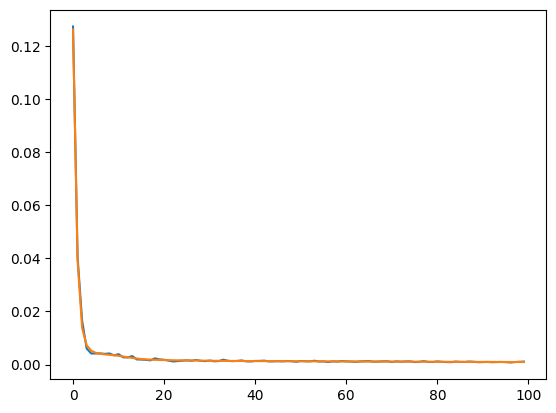

In [22]:
t0 = time.time()
dataset = glitch_fft[:,101:];

nTotal = len(dataset);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

X_train = dataset[:nTrain]
X_test = dataset[-nTest:]
X_validation = dataset[nTrain:-nTest]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros(epochs)
loss_validation = np.zeros(epochs)

wNorm = 0;

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = weighted_lossTrain.item()
    loss_validation[epoch] = val_loss
    
plt.plot(loss_train)
plt.plot(loss_validation)

print(time.time() - t0)

In [23]:
currentStep = 'glitch_H'
autoencoder.cpu().eval();
models[currentStep] = copy.deepcopy(autoencoder);

In [24]:
glitch_fft.shape

(35000, 202)

In [25]:
glitch_reserved_fft.shape

(30000, 202)

### Now, let's evaluate their performance on reserved dataset

In [194]:
models

{'glitch_L': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=101, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=101, bias=True)
     (1): Sigmoid()
   )
 ),
 'glitch_H': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=101, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=101, bias=True)
     (1): Sigmoid()
   )
 ),
 'glitch_2det_WSC_combined_two_glitches': WSClassifier(
   (fc1): Linear(in_features=202, out_features=32, bias=True)
   (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
   (sigmoid): Sigmoid()
   (fc2): Linear(in_features=32, out_features=1, bias=True)
 ),
 'glitch_2det_WSC_combined_one_glitch_one_noise': WSClassifier(
   (fc1): Linear(in_features=202, out_features=32, bias=True)
   (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1,

#### For GWAK one 

In [95]:
c0 = {}

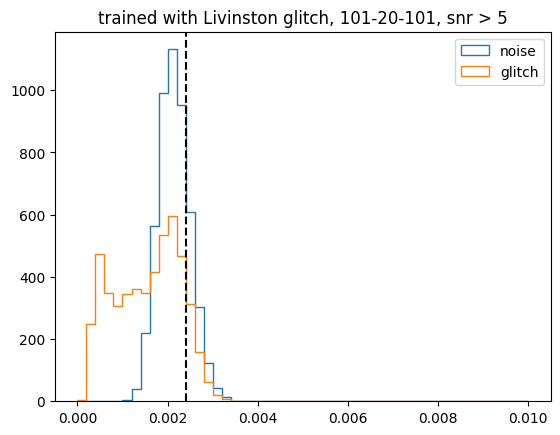

In [294]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch_L"]

c0["glitch_L"] = 0.0024;

dcd_bkg_L = model(torch.FloatTensor(bkg_reserved_fft[:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch_L = model(torch.FloatTensor(glitch_reserved_fft[:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,:101]-dcd_bkg_L, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,:101]-dcd_glitch_L, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Livinston glitch, 101-20-101, snr > 5")
plt.axvline(c0["glitch_L"], color="k", linestyle="--")
plt.legend()

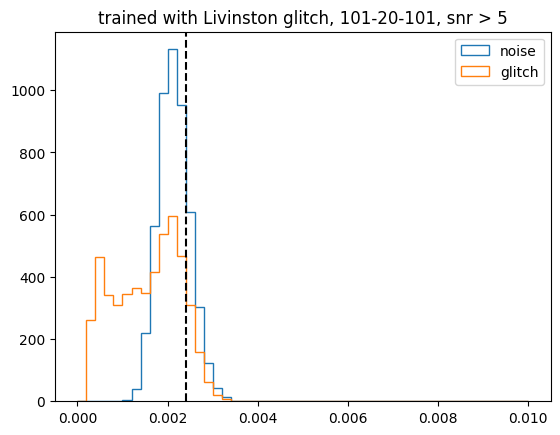

In [283]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch_L"]

c0["glitch_L"] = 0.0024;

dcd_bkg_L = model(torch.FloatTensor(bkg_reserved_fft[:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch_L = model(torch.FloatTensor(glitch_reserved_fft[:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,:101]-dcd_bkg_L, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,:101]-dcd_glitch_L, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Livinston glitch, 101-20-101, snr > 5")
plt.axvline(c0["glitch_L"], color="k", linestyle="--")
plt.legend()

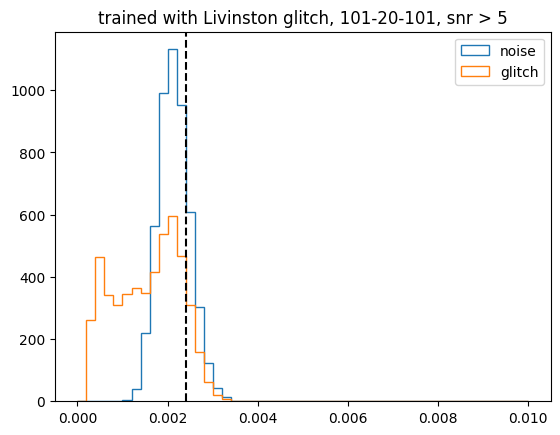

In [282]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch_L"]

c0["glitch_L"] = 0.0024;

dcd_bkg_L = model(torch.FloatTensor(bkg_reserved_fft[:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch_L = model(torch.FloatTensor(glitch_reserved_fft[:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,:101]-dcd_bkg_L, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,:101]-dcd_glitch_L, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Livinston glitch, 101-20-101, snr > 5")
plt.axvline(c0["glitch_L"], color="k", linestyle="--")
plt.legend()

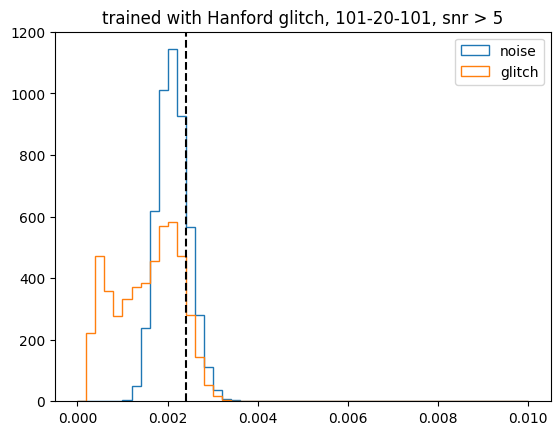

In [281]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch_H"]

c0["glitch_H"] = 0.0024;

dcd_bkg_H = model(torch.FloatTensor(bkg_reserved_fft[:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch_H = model(torch.FloatTensor(glitch_reserved_fft[:,101:]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,101:]-dcd_bkg_H, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,101:]-dcd_glitch_H, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Hanford glitch, 101-20-101, snr > 5")
plt.axvline(c0["glitch_H"], color="k", linestyle="--")
plt.legend()

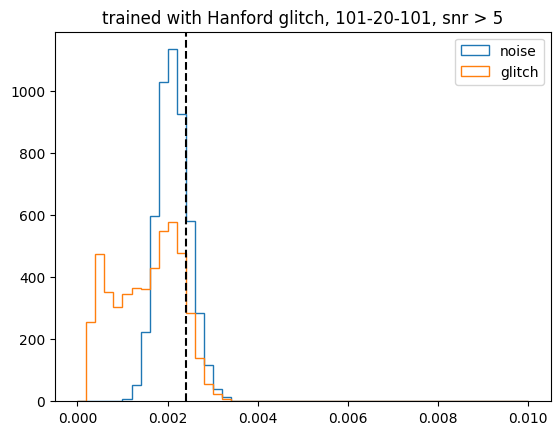

In [53]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch_H"]

c0["glitch_H"] = 0.0024;

dcd_bkg_H = model(torch.FloatTensor(bkg_reserved_fft[:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch_H = model(torch.FloatTensor(glitch_reserved_fft[:,101:]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,101:]-dcd_bkg_H, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,101:]-dcd_glitch_H, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Hanford glitch, 101-20-101, snr > 5")
# plt.axvline(c0["glitch_H"], color="k", linestyle="--")
plt.legend()

#### For Chia-Jui one

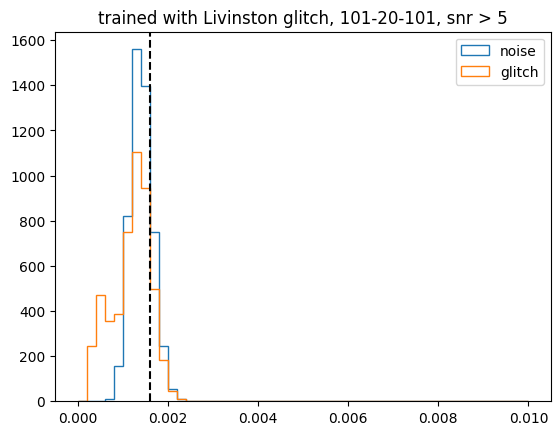

In [240]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch_L"]

c0["glitch_L"] = 0.0016;

dcd_bkg_L = model(torch.FloatTensor(bkg_reserved_fft[:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch_L = model(torch.FloatTensor(glitch_reserved_fft[:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,:101]-dcd_bkg_L, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,:101]-dcd_glitch_L, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Livinston glitch, 101-20-101, snr > 5")
plt.axvline(c0["glitch_L"], color="k", linestyle="--")
plt.legend()

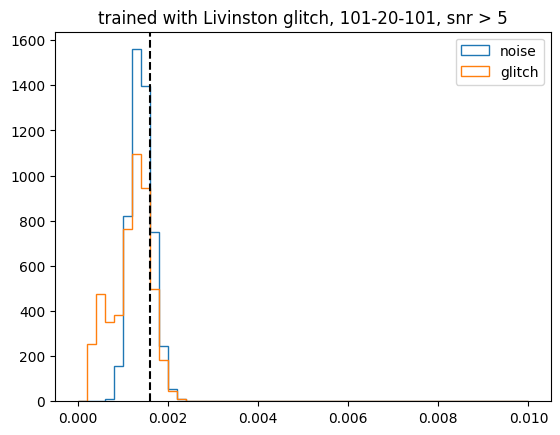

In [196]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch_L"]

c0["glitch_L"] = 0.0016;

dcd_bkg_L = model(torch.FloatTensor(bkg_reserved_fft[:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch_L = model(torch.FloatTensor(glitch_reserved_fft[:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,:101]-dcd_bkg_L, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,:101]-dcd_glitch_L, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Livinston glitch, 101-20-101, snr > 5")
plt.axvline(c0["glitch_L"], color="k", linestyle="--")
plt.legend()

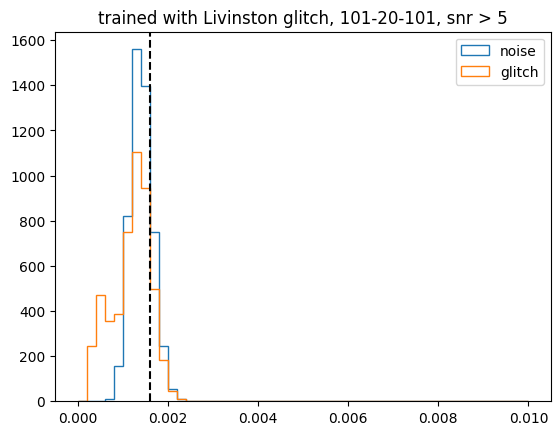

In [259]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch_L"]

c0["glitch_L"] = 0.0016;

dcd_bkg_L = model(torch.FloatTensor(bkg_reserved_fft[:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch_L = model(torch.FloatTensor(glitch_reserved_fft[:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,:101]-dcd_bkg_L, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,:101]-dcd_glitch_L, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Livinston glitch, 101-20-101, snr > 5")
plt.axvline(c0["glitch_L"], color="k", linestyle="--")
plt.legend()

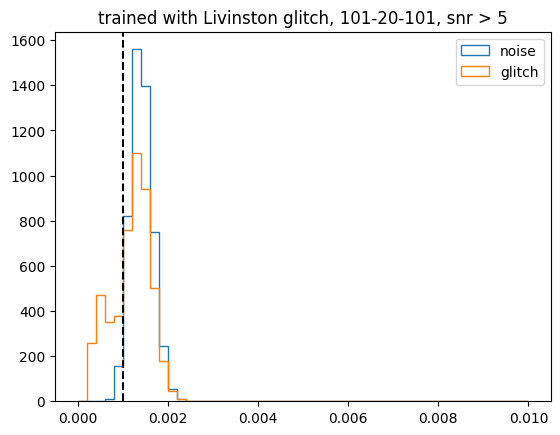

In [374]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch_L"]

c0["glitch_L"] = 0.001;

dcd_bkg_L = model(torch.FloatTensor(bkg_reserved_fft[:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch_L = model(torch.FloatTensor(glitch_reserved_fft[:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,:101]-dcd_bkg_L, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,:101]-dcd_glitch_L, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Livinston glitch, 101-20-101, snr > 5")
plt.axvline(c0["glitch_L"], color="k", linestyle="--")
plt.legend()

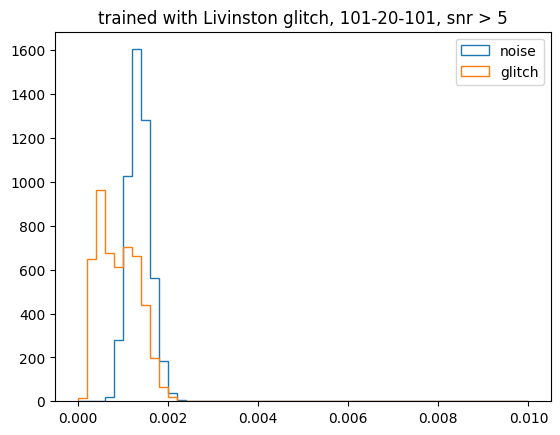

In [286]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch_L"]

c0["glitch_L"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_reserved_fft[:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_reserved_fft[:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Livinston glitch, 101-20-101, snr > 5")
plt.axvline(c0["glitch_L"], color="k", linestyle="--")
plt.legend()

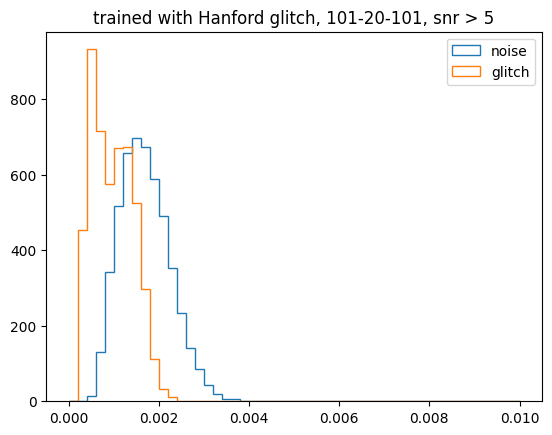

In [268]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch_H"]

c0["glitch_H"] = 0.002;

dcd_bkg_H = model(torch.FloatTensor(bkg_reserved_fft[:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch_H = model(torch.FloatTensor(glitch_reserved_fft[:,101:]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,101:]-dcd_bkg_H, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,101:]-dcd_glitch_H, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Hanford glitch, 101-20-101, snr > 5")
# plt.axvline(c0["glitch_H"], color="k", linestyle="--")
plt.legend()

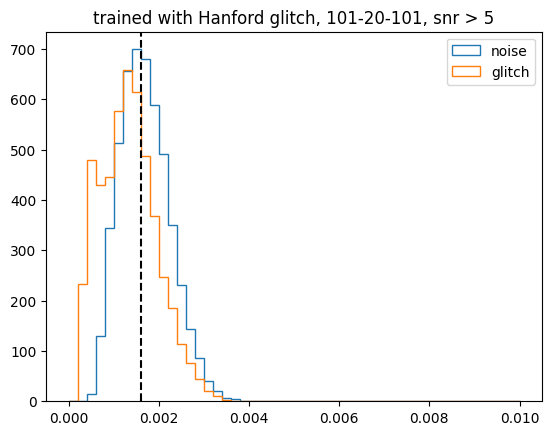

In [260]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch_H"]

c0["glitch_H"] = 0.0016;

dcd_bkg_H = model(torch.FloatTensor(bkg_reserved_fft[:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch_H = model(torch.FloatTensor(glitch_reserved_fft[:,101:]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,101:]-dcd_bkg_H, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,101:]-dcd_glitch_H, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Hanford glitch, 101-20-101, snr > 5")
plt.axvline(c0["glitch_H"], color="k", linestyle="--")
plt.legend()

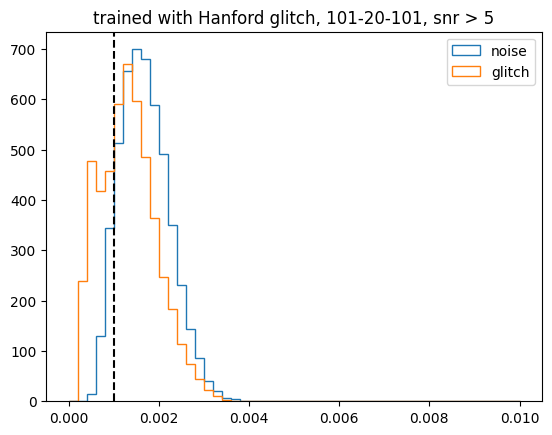

In [375]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch_H"]

c0["glitch_H"] = 0.001;

dcd_bkg_H = model(torch.FloatTensor(bkg_reserved_fft[:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch_H = model(torch.FloatTensor(glitch_reserved_fft[:,101:]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,101:]-dcd_bkg_H, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,101:]-dcd_glitch_H, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Hanford glitch, 101-20-101, snr > 5")
plt.axvline(c0["glitch_H"], color="k", linestyle="--")
plt.legend()

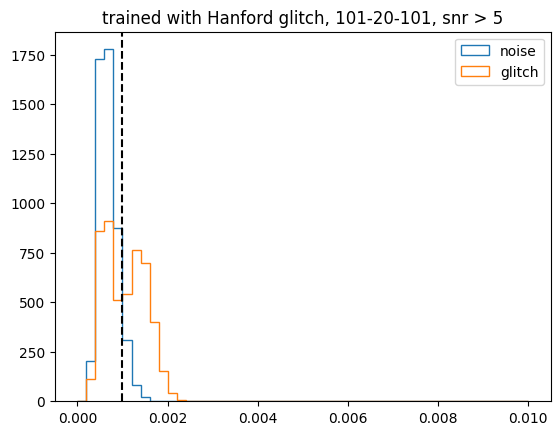

In [321]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch_H"]

c0["glitch_H"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_reserved_fft[:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_reserved_fft[:,101:]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,101:]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,101:]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Hanford glitch, 101-20-101, snr > 5")
plt.axvline(c0["glitch_H"], color="k", linestyle="--")
plt.legend()

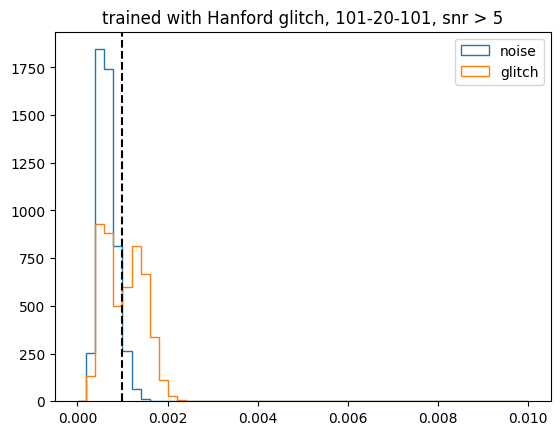

In [316]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models["glitch_H"]

c0["glitch_H"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_reserved_fft[:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_reserved_fft[:,101:]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,101:]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,101:]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Hanford glitch, 101-20-101, snr > 5")
plt.axvline(c0["glitch_H"], color="k", linestyle="--")
plt.legend()

#### After that, let's do a WSL check

In [30]:
class WSClassifier(nn.Module):
    def __init__(self):
        super(WSClassifier, self).__init__()
        self.fc1 = nn.Linear(202, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 1)
        # self.norm2 = nn.BatchNorm1d(8)
        # self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        # nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        return self.fc2(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [151]:
class WSClassifier_Onedetector(nn.Module):
    def __init__(self):
        super(WSClassifier_Onedetector, self).__init__()
        self.fc1 = nn.Linear(101, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 1)
        # self.norm2 = nn.BatchNorm1d(8)
        # self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        # nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        return self.fc2(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [31]:
def trainWSC(dataset0, dataset1, cutID=None, version=None, datatype=None):
# dataset0: bkg set from AE
# dataset1: identified signal from AE
    
    nTotal0, nTotal1 = len(dataset0), len(dataset1);
    nTrain0, nTrain1 = int(rTrain * nTotal0), int(rTrain * nTotal1)
    nTest0 , nTest1  = int(rTest * nTotal0) , int(rTest * nTotal1)

    X_train = np.concatenate((dataset0[:nTrain0], dataset1[:nTrain1]))
    X_test = np.concatenate((dataset0[-nTest0:], dataset1[-nTest1:]))
    X_validation = np.concatenate((dataset0[nTrain0:-nTest0], dataset1[nTrain1:-nTest1]))
    
    Y_train = np.concatenate((np.zeros((nTrain0, 1)), np.ones((nTrain1, 1))))
    Y_test = np.concatenate((np.zeros((nTest0, 1)), np.ones((nTest1, 1))))
    Y_validation = np.concatenate((np.zeros((dataset0[nTrain0:-nTest0].shape[0], 1)), np.ones((dataset1[nTrain1:-nTest1].shape[0], 1))))

#     trainData = torch.FloatTensor(X_train)
#     testData = torch.FloatTensor(X_test)
#     validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
    validation_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(Y_validation))
#     train_dataset = TensorDataset(torch.FloatTensor(X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))), torch.FloatTensor(Y_train.reshape((Y_train.shape[0], 1, Y_train.shape[1]))))
#     validation_dataset = TensorDataset(torch.FloatTensor(X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))), torch.FloatTensor(Y_validation.reshape((Y_validation.shape[0], 1, Y_validation.shape[1]))))

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True, drop_last=True)

    wsc = WSClassifier().cuda()
    optimizer = optim.Adam(wsc.parameters(), lr=0.00005)
    loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([nTrain0/nTrain1])).cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):
#         t0 = time.time()
        wsc.train()
        for batchidx, (x, y) in enumerate(trainDataLoader):
            x = x.cuda()
            y = y.cuda()
            yprime = wsc(x)
            loss = loss_func(yprime, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        wsc.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, y) in enumerate(validationDataLoader):
                x = x.cuda()
                y = y.cuda()
                yprime = wsc(x)
                lossVal = loss_func(yprime, y)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = loss.item()
        loss_validation[epoch] = val_loss
#         print(time.time() - t0)
        
    wsc.cpu().eval()
    
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_train))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_test ))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    
    # plt.savefig("../Pic_cached/SequentialTraining/WSL/training_WSC_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    # plt.close()
    
    return wsc.cpu().eval()

In [248]:
def trainWSC_onedetector(dataset0, dataset1, cutID=None, version=None, datatype=None):
# dataset0: bkg set from AE
# dataset1: identified signal from AE
    
    nTotal0, nTotal1 = len(dataset0), len(dataset1);
    nTrain0, nTrain1 = int(rTrain * nTotal0), int(rTrain * nTotal1)
    nTest0 , nTest1  = int(rTest * nTotal0) , int(rTest * nTotal1)

    X_train = np.concatenate((dataset0[:nTrain0], dataset1[:nTrain1]))
    X_test = np.concatenate((dataset0[-nTest0:], dataset1[-nTest1:]))
    X_validation = np.concatenate((dataset0[nTrain0:-nTest0], dataset1[nTrain1:-nTest1]))
    
    Y_train = np.concatenate((np.zeros((nTrain0, 1)), np.ones((nTrain1, 1))))
    Y_test = np.concatenate((np.zeros((nTest0, 1)), np.ones((nTest1, 1))))
    Y_validation = np.concatenate((np.zeros((dataset0[nTrain0:-nTest0].shape[0], 1)), np.ones((dataset1[nTrain1:-nTest1].shape[0], 1))))

#     trainData = torch.FloatTensor(X_train)
#     testData = torch.FloatTensor(X_test)
#     validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
    validation_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(Y_validation))
#     train_dataset = TensorDataset(torch.FloatTensor(X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))), torch.FloatTensor(Y_train.reshape((Y_train.shape[0], 1, Y_train.shape[1]))))
#     validation_dataset = TensorDataset(torch.FloatTensor(X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))), torch.FloatTensor(Y_validation.reshape((Y_validation.shape[0], 1, Y_validation.shape[1]))))

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True, drop_last=True)

    wsc = WSClassifier_Onedetector().cuda()
    optimizer = optim.Adam(wsc.parameters(), lr=0.00005)
    loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([nTrain0/nTrain1])).cuda()
    
    epochs = 100
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):
#         t0 = time.time()
        wsc.train()
        for batchidx, (x, y) in enumerate(trainDataLoader):
            x = x.cuda()
            y = y.cuda()
            yprime = wsc(x)
            loss = loss_func(yprime, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        wsc.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, y) in enumerate(validationDataLoader):
                x = x.cuda()
                y = y.cuda()
                yprime = wsc(x)
                lossVal = loss_func(yprime, y)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = loss.item()
        loss_validation[epoch] = val_loss
#         print(time.time() - t0)
        
    wsc.cpu().eval()
    
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_train))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_test ))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    
    # plt.savefig("../Pic_cached/SequentialTraining/WSL/training_WSC_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    # plt.close()
    
    return wsc.cpu().eval()

In [32]:
bkg_reserved_fft.shape

(25501, 202)

In [54]:
np.argwhere(np.logical_and(np.var(glitch_reserved_fft[:,:101]-dcd_glitch_L, axis=1) > c0['glitch_L'],np.var(glitch_reserved_fft[:,101:]-dcd_glitch_H, axis=1) > c0['glitch_H'])).flatten().shape

(16,)

In [55]:
np.argwhere(np.logical_and(np.var(bkg_reserved_fft[:,:101]-dcd_bkg_L, axis=1) > c0['glitch_L'],np.var(bkg_reserved_fft[:,101:]-dcd_bkg_H, axis=1) > c0['glitch_H'])).flatten().shape

(2332,)

In [393]:
np.argwhere(np.logical_or(np.var(glitch_reserved_fft[:,:101]-dcd_glitch_L, axis=1) > c0['glitch_L'],np.var(glitch_reserved_fft[:,101:]-dcd_glitch_H, axis=1) > c0['glitch_H'])).flatten().shape

(28899,)

In [394]:
np.argwhere(np.logical_or(np.var(bkg_reserved_fft[:,:101]-dcd_bkg_L, axis=1) > c0['glitch_L'],np.var(bkg_reserved_fft[:,101:]-dcd_bkg_H, axis=1) > c0['glitch_H'])).flatten().shape

(25407,)

In [99]:
models

{'glitch_L': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=101, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=101, bias=True)
     (1): Sigmoid()
   )
 ),
 'glitch_H': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=101, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=101, bias=True)
     (1): Sigmoid()
   )
 )}

In [295]:
dataset0 = glitch_fft
dataset1 = np.vstack((glitch_reserved_fft[np.argwhere(np.logical_and(np.var(glitch_reserved_fft[:,:101]-dcd_glitch_L, axis=1) > c0['glitch_L'],np.var(glitch_reserved_fft[:,101:]-dcd_glitch_H, axis=1) > c0['glitch_H'])).flatten()], 
                      bkg_reserved_fft[np.argwhere(np.logical_and(np.var(bkg_reserved_fft[:,:101]-dcd_bkg_L, axis=1) > c0['glitch_L'],np.var(bkg_reserved_fft[:,101:]-dcd_bkg_H, axis=1) > c0['glitch_H'])).flatten()]))

models['glitch_2det_WSC_combined_two_glitches'] = trainWSC(dataset0, dataset1)

KeyboardInterrupt: 

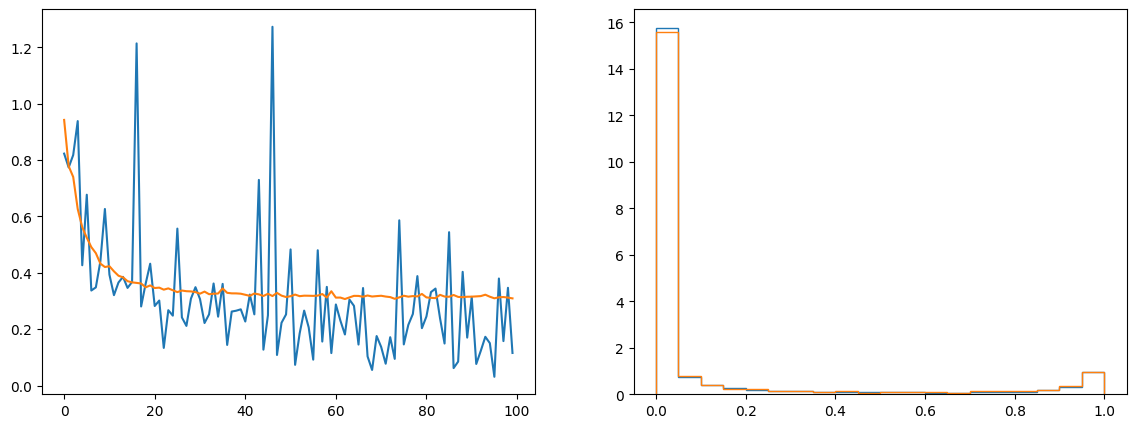

In [ ]:
dataset0 = glitch_reserved_fft_for_wsl_training
dataset1 = np.vstack((glitch_reserved_fft[np.argwhere(np.logical_and(np.var(glitch_reserved_fft[:,:101]-dcd_glitch_L, axis=1) > c0['glitch_L'],np.var(glitch_reserved_fft[:,101:]-dcd_glitch_H, axis=1) > c0['glitch_H'])).flatten()], 
                      bkg_reserved_fft[np.argwhere(np.logical_and(np.var(bkg_reserved_fft[:,:101]-dcd_bkg_L, axis=1) > c0['glitch_L'],np.var(bkg_reserved_fft[:,101:]-dcd_bkg_H, axis=1) > c0['glitch_H'])).flatten()]))

models['glitch_2det_WSC_combined_one_glitch_one_noise'] = trainWSC(dataset0, dataset1)

In [243]:
glitch_fft.shape

(35000, 202)

In [246]:
c0["glitch_L"] = 0.0018
c0["glitch_H"] = 0.0016

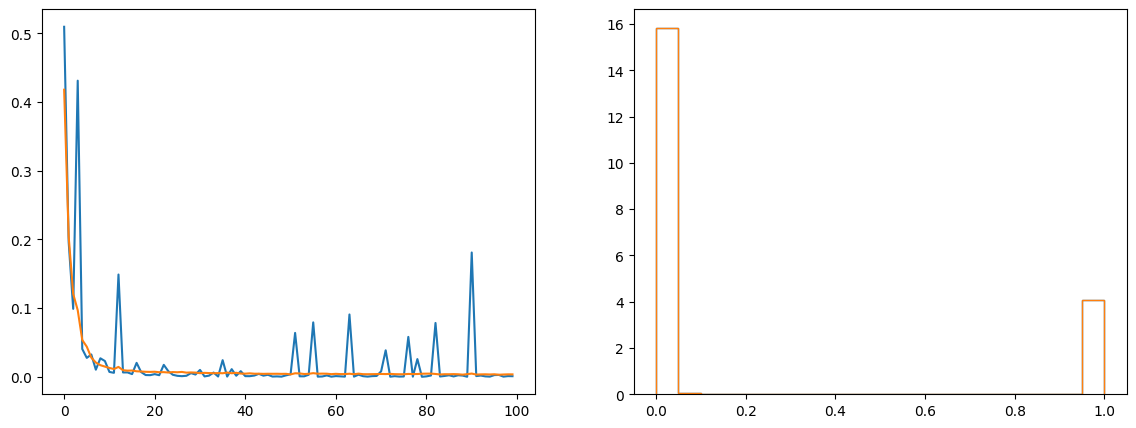

In [296]:
dataset0 = glitch_fft[:,:101]
dataset1 = np.vstack((glitch_reserved_fft[np.argwhere(np.var(glitch_reserved_fft[:,:101]-dcd_glitch_L, axis=1) > c0['glitch_L']).flatten()][:,:101], 
                      bkg_reserved_fft[np.argwhere(np.var(bkg_reserved_fft[:,:101]-dcd_bkg_L, axis=1) > c0['glitch_L']).flatten()][:,:101]))

models['glitch_1det_WSC_L'] = trainWSC_onedetector(dataset0, dataset1)

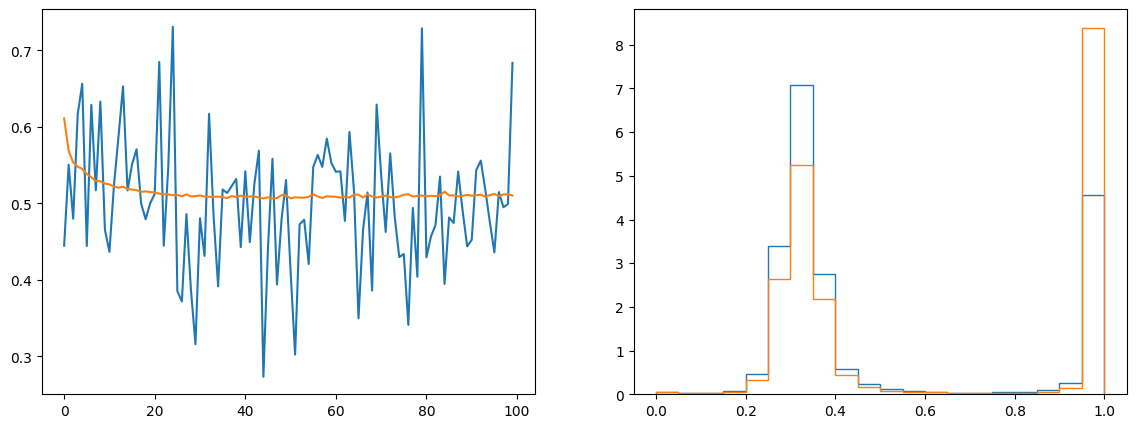

In [297]:
dataset0 = glitch_fft[:,101:]
dataset1 = np.vstack((glitch_reserved_fft[np.argwhere(np.var(glitch_reserved_fft[:,101:]-dcd_glitch_H, axis=1) > c0['glitch_H']).flatten()][:,101:], 
                      bkg_reserved_fft[np.argwhere(np.var(bkg_reserved_fft[:,101:]-dcd_bkg_H, axis=1) > c0['glitch_H']).flatten()][:,101:]))

models['glitch_1det_WSC_H'] = trainWSC_onedetector(dataset0, dataset1)

#### performance?

In [159]:
models

{'glitch_L': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=101, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=101, bias=True)
     (1): Sigmoid()
   )
 ),
 'glitch_H': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=101, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=101, bias=True)
     (1): Sigmoid()
   )
 ),
 'glitch_2det_WSC_combined_two_glitches': WSClassifier(
   (fc1): Linear(in_features=202, out_features=32, bias=True)
   (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
   (sigmoid): Sigmoid()
   (fc2): Linear(in_features=32, out_features=1, bias=True)
 ),
 'glitch_2det_WSC_combined_one_glitch_one_noise': WSClassifier(
   (fc1): Linear(in_features=202, out_features=32, bias=True)
   (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1,

In [412]:
models

{'glitch': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=101, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=101, bias=True)
     (1): Sigmoid()
   )
 ),
 'noise': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=202, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=202, bias=True)
     (1): Sigmoid()
   )
 ),
 'glitch_L': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=101, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=101, bias=True)
     (1): Sigmoid()
   )
 ),
 'glitch_H': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=101, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=101, bias=True)
     (1): Sigmoid()
  

In [39]:
torch.save(models['glitch_L'], "1_det_L_glitch_trained_with_permutation_GWAK.pt")

In [40]:
torch.save(models['glitch_H'], "1_det_H_glitch_trained_with_permutation_GWAK.pt")

In [58]:
torch.save(models['glitch_2det_WSC'], "2_det_WSL_trained_with_AE_GWAK_0.0024_0.0024.pt")

In [57]:
c0

{'glitch_L': 0.0024, 'glitch_H': 0.0024}

Draft, I want to compare the performance of different WSL schemes

In [160]:
c0

{'glitch_L': 0.0016, 'glitch_H': 0.002}

In [169]:
bkg_reserved_fft.shape

(21000, 202)

In [168]:
glitch_reserved_fft.shape

(30000, 202)

19142
12185


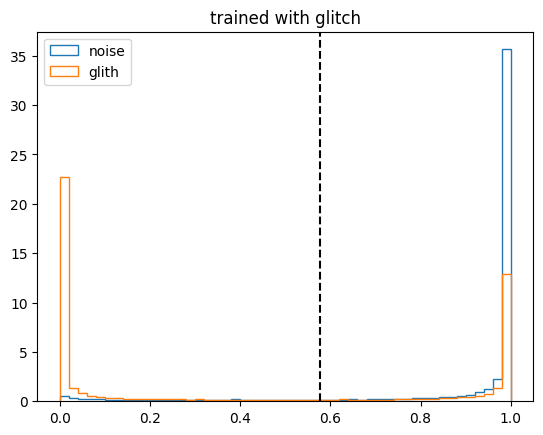

In [167]:
model = models['glitch_2det_WSC_combined_two_glitches']

bkg_filtered = bkg_reserved_fft
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_reserved_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
# foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
# foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glith")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bkg.flatten())[int(0.1 * len(dcd_bkg))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

print(np.sum(dcd_bkg>0.5))
print(np.sum(dcd_glitch>0.5))

8997
2069


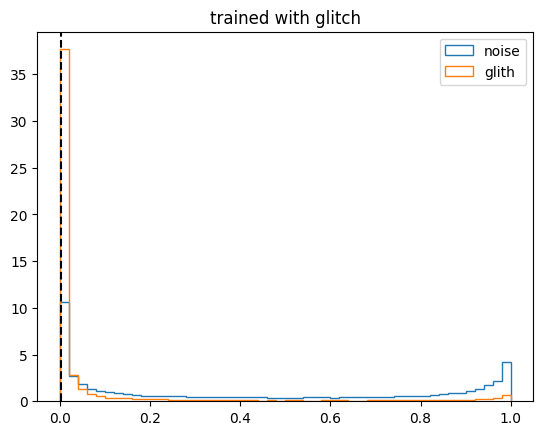

In [170]:
model = models['glitch_2det_WSC_combined_one_glitch_one_noise']

bkg_filtered = bkg_reserved_fft
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_reserved_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
# foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
# foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glith")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bkg.flatten())[int(0.1 * len(dcd_bkg))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

print(np.sum(dcd_bkg>0.5))
print(np.sum(dcd_glitch>0.5))

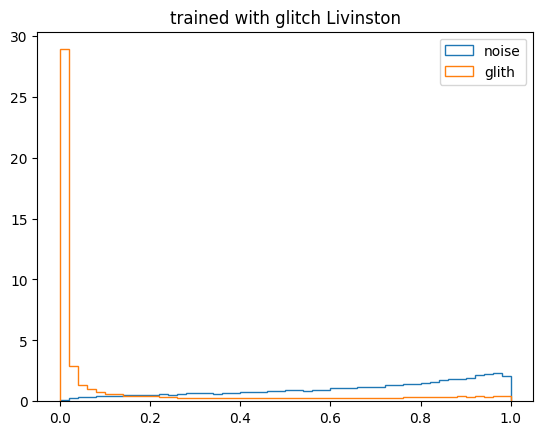

In [228]:
model = models['glitch_1det_WSC_L']

bkg_filtered = bkg_reserved_fft[:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg_L = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch_L = nn.Sigmoid()(model(torch.FloatTensor(glitch_reserved_fft[:,:101]))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg_L, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
# foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
# foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch_L, histtype="step", range=(0, 1), bins=50, density=True, label="glith")
plt.title("trained with glitch Livinston")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
# plt.axvline(np.sort(dcd_bkg_L.flatten())[int(0.1 * len(dcd_bkg_L))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

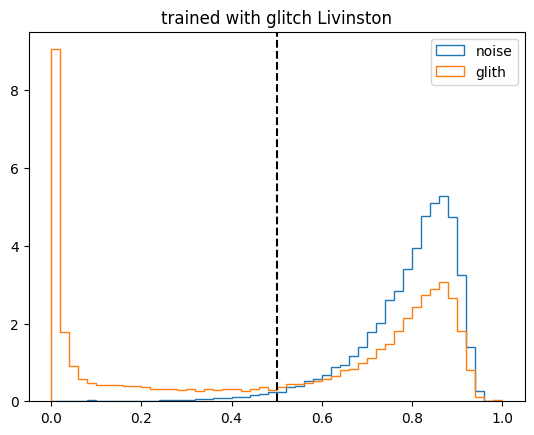

In [257]:
model = models['glitch_1det_WSC_L']

bkg_filtered = bkg_reserved_fft[:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg_L = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch_L = nn.Sigmoid()(model(torch.FloatTensor(glitch_reserved_fft[:,:101]))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg_L, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
# foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
# foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch_L, histtype="step", range=(0, 1), bins=50, density=True, label="glith")
plt.title("trained with glitch Livinston")
plt.axvline(0.5, color="k", linestyle="--")
# plt.axvline(np.sort(dcd_bkg_L.flatten())[int(0.1 * len(dcd_bkg_L))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

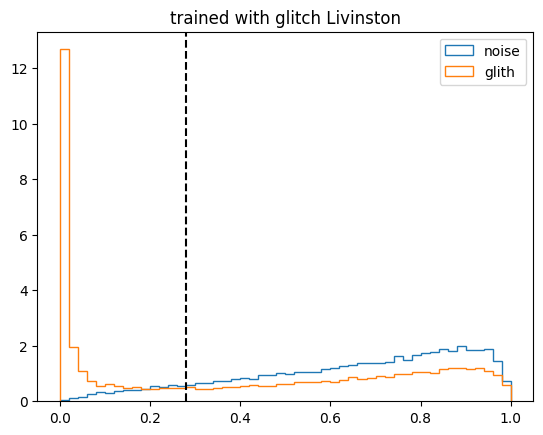

In [165]:
model = models['glitch_1det_WSC_L']

bkg_filtered = bkg_reserved_fft[:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg_L = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch_L = nn.Sigmoid()(model(torch.FloatTensor(glitch_reserved_fft[:,:101]))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg_L, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
# foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
# foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch_L, histtype="step", range=(0, 1), bins=50, density=True, label="glith")
plt.title("trained with glitch Livinston")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bkg_L.flatten())[int(0.1 * len(dcd_bkg_L))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

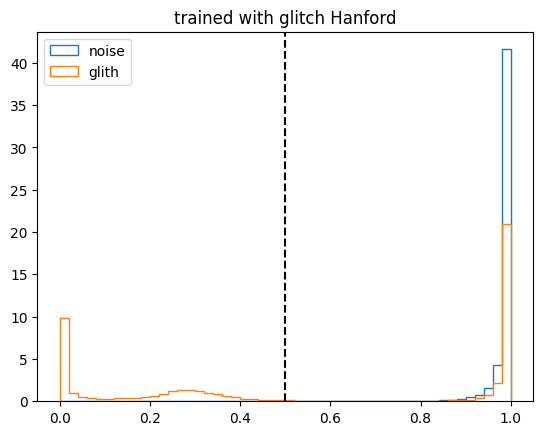

In [256]:
model = models['glitch_1det_WSC_H']

bkg_filtered = bkg_reserved_fft[:,101:]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg_H = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch_H = nn.Sigmoid()(model(torch.FloatTensor(glitch_reserved_fft[:,101:]))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg_H, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
# foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
# foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch_H, histtype="step", range=(0, 1), bins=50, density=True, label="glith")
plt.title("trained with glitch Hanford")
plt.axvline(0.5, color="k", linestyle="--")
# plt.axvline(np.sort(dcd_bkg_H.flatten())[int(0.1 * len(dcd_bkg_H))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

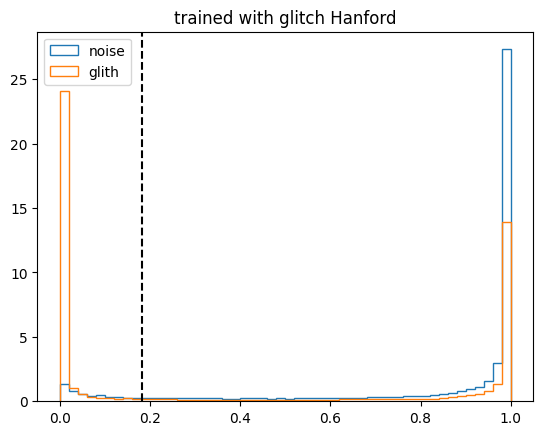

In [166]:
model = models['glitch_1det_WSC_H']

bkg_filtered = bkg_reserved_fft[:,101:]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg_H = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch_H = nn.Sigmoid()(model(torch.FloatTensor(glitch_reserved_fft[:,101:]))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg_H, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
# foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
# foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch_H, histtype="step", range=(0, 1), bins=50, density=True, label="glith")
plt.title("trained with glitch Hanford")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bkg_H.flatten())[int(0.1 * len(dcd_bkg_H))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

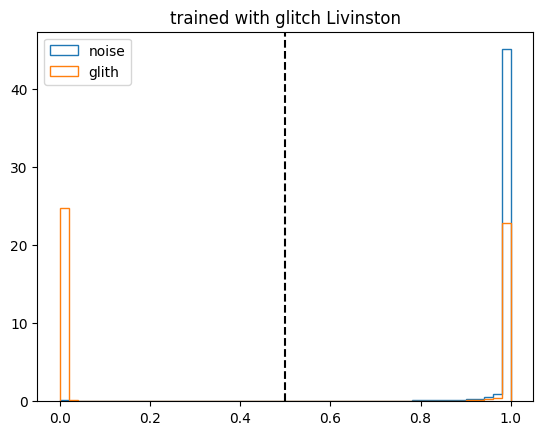

In [298]:
model = models['glitch_1det_WSC_L']

bkg_filtered = bkg_reserved_fft[:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg_L = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch_L = nn.Sigmoid()(model(torch.FloatTensor(glitch_reserved_fft[:,:101]))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg_L, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
# foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
# foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch_L, histtype="step", range=(0, 1), bins=50, density=True, label="glith")
plt.title("trained with glitch Livinston")
plt.axvline(0.5, color="k", linestyle="--")
# plt.axvline(np.sort(dcd_bkg_L.flatten())[int(0.1 * len(dcd_bkg_L))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

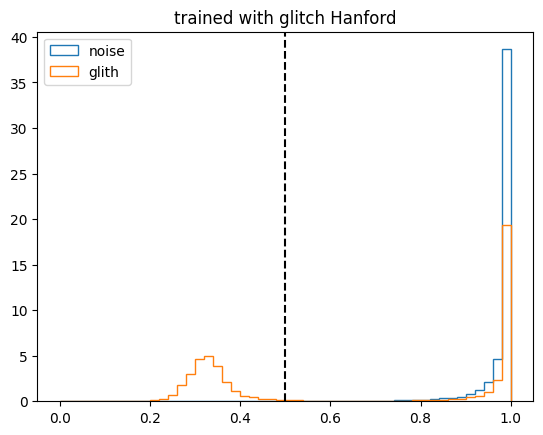

In [300]:
model = models['glitch_1det_WSC_H']

bkg_filtered = bkg_reserved_fft[:,101:]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg_H = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch_H = nn.Sigmoid()(model(torch.FloatTensor(glitch_reserved_fft[:,101:]))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg_H, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
# foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
# foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch_H, histtype="step", range=(0, 1), bins=50, density=True, label="glith")
plt.title("trained with glitch Hanford")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(0.5, color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

In [255]:
print(np.sum(np.logical_and(dcd_bkg_L>0.5,dcd_bkg_H>0.5)))
print(np.sum(np.logical_and(dcd_glitch_L>0.5,dcd_glitch_H>0.5)))

24665
3962


In [301]:
print(np.sum(np.logical_and(dcd_bkg_L>0.5,dcd_bkg_H>0.5)))
print(np.sum(np.logical_and(dcd_glitch_L>0.5,dcd_glitch_H>0.5)))

24832
394


In [269]:
glitch_reserved_fft.shape

(30000, 202)

In [270]:
bkg_reserved_fft.shape

(30000, 202)

In [171]:
print(np.sum(np.logical_and(dcd_bkg_L>0.5,dcd_bkg_H>0.5)))
print(np.sum(np.logical_and(dcd_glitch_L>0.5,dcd_glitch_H>0.5)))

12550
2190


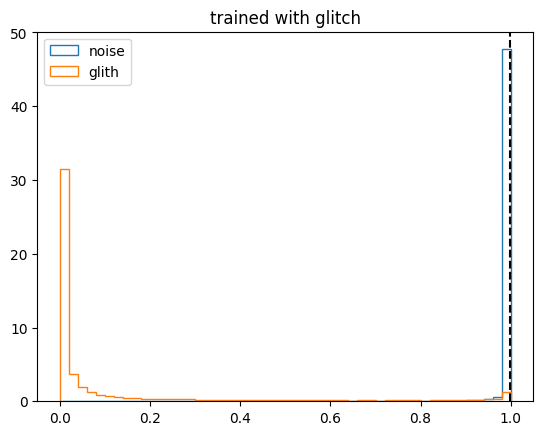

In [59]:
# GWAK one, Threshold set to 0.0024, 0.0024

model = models['glitch_2det_WSC']

bkg_filtered = bkg_reserved_fft
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_reserved_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
# foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
# foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glith")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bkg.flatten())[int(0.1 * len(dcd_bkg))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

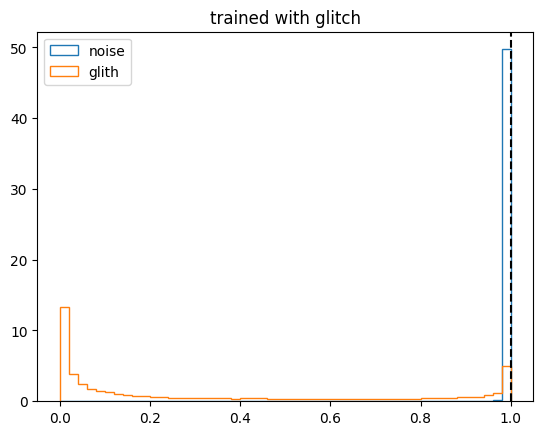

In [52]:
# GWAK one, Threshold set to 0.0024, 0.002

model = models['glitch_2det_WSC']

bkg_filtered = bkg_reserved_fft
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_reserved_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
# foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
# foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glith")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bkg.flatten())[int(0.1 * len(dcd_bkg))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

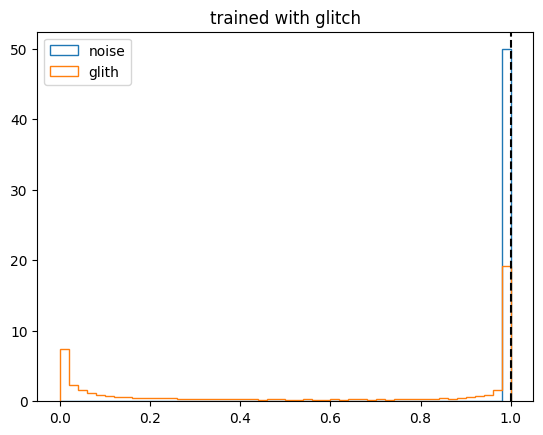

In [42]:
# GWAK one, Threshold set to 0.002, 0.0016

model = models['glitch_2det_WSC']

bkg_filtered = bkg_reserved_fft
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_reserved_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
# foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
# foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glith")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bkg.flatten())[int(0.1 * len(dcd_bkg))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

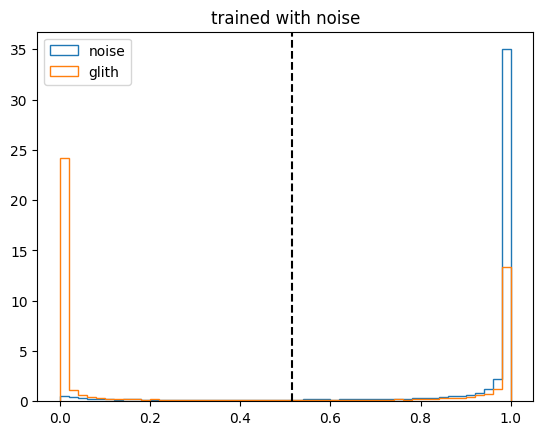

In [410]:
# Threshold set to 0.002, 0.0016

model = models['glitch_2det_WSC']

bkg_filtered = bkg_reserved_fft
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_reserved_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
# foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
# foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glith")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bkg.flatten())[int(0.1 * len(dcd_bkg))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

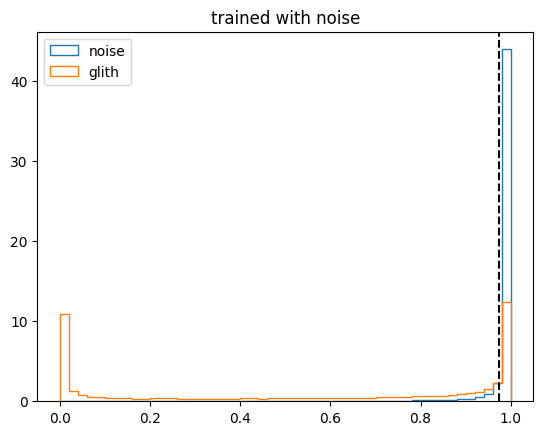

In [404]:
# Threshold set to 0.0012, 0.0014

model = models['glitch_2det_WSC']

bkg_filtered = bkg_reserved_fft
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_reserved_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
# foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
# foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glith")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bkg.flatten())[int(0.1 * len(dcd_bkg))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

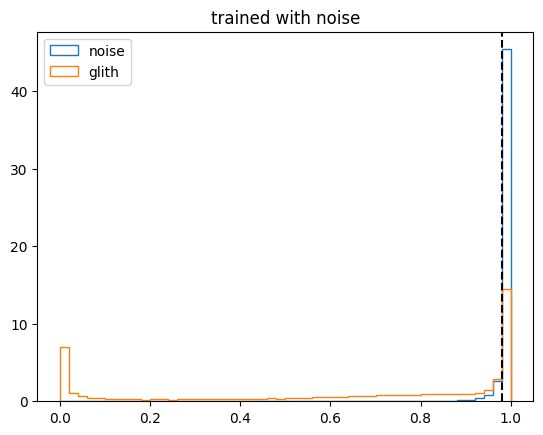

In [390]:
# Threshold set to 0.001, 0.001

model = models['glitch_2det_WSC']

bkg_filtered = bkg_reserved_fft
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_reserved_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
# foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
# foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glith")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bkg.flatten())[int(0.1 * len(dcd_bkg))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

#### Roc comparison with the CNN counterpart

##### For Livinston model

In [91]:
models = {}
c0 = {}

In [93]:
models['glitch_L'] = torch.load('../Model_cached/1_det_L_glitch_trained_with_permutation_1.pt')
models['glitch_H'] = torch.load('../Model_cached/1_det_H_glitch_trained_with_permutation_1.pt')

In [94]:
models

{'glitch_L': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=101, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=101, bias=True)
     (1): Sigmoid()
   )
 ),
 'glitch_H': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=101, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=101, bias=True)
     (1): Sigmoid()
   )
 )}

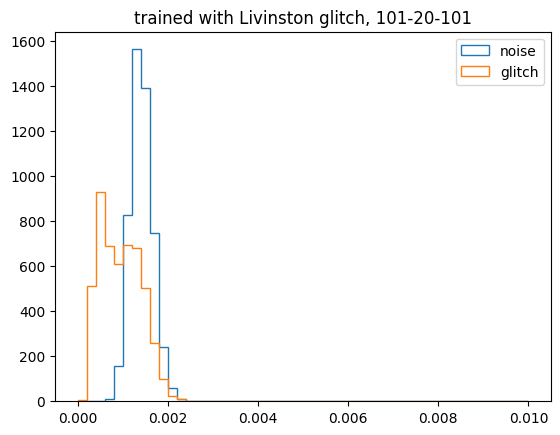

In [205]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models['glitch_L']

c0["glitch_L"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_reserved_fft[:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_reserved_fft[:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Livinston glitch, 101-20-101")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

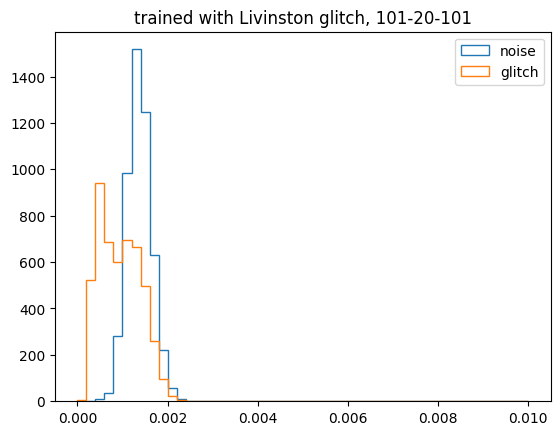

In [32]:
# How about noise from a much shorter time(4096s), also for one detector?

model = models['glitch_L']

c0["glitch_L"] = 0.001;

dcd_bkg = model(torch.FloatTensor(bkg_reserved_fft[:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_reserved_fft[:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(bkg_reserved_fft[:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_reserved_fft[:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with Livinston glitch, 101-20-101")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

In [206]:
# ROC performance for the DNNAE model

err_noise = np.var(bkg_reserved_fft[:,:101]-dcd_bkg, axis=1)
err_glitch = np.var(glitch_reserved_fft[:,:101]-dcd_glitch, axis=1)


FPR = np.arange(0.01,1,0.01)

TPR = np.arange(0.01,1,0.01)

for i in range(len(FPR)):
    
    TPR[i] = np.sum(err_noise > np.sort(err_glitch)[-int(FPR[i] * len(err_glitch))]) / len(err_noise)

In [207]:
TPR

array([0.02096667, 0.04416667, 0.07243333, 0.1023    , 0.1323    ,
       0.1607    , 0.1872    , 0.21713333, 0.2446    , 0.2729    ,
       0.30613333, 0.3313    , 0.3591    , 0.3842    , 0.41436667,
       0.4411    , 0.46803333, 0.49336667, 0.52036667, 0.54643333,
       0.5743    , 0.60213333, 0.62806667, 0.6518    , 0.6727    ,
       0.693     , 0.71486667, 0.7362    , 0.75656667, 0.77346667,
       0.7937    , 0.81053333, 0.83026667, 0.84516667, 0.86056667,
       0.875     , 0.88776667, 0.9004    , 0.9124    , 0.92233333,
       0.93213333, 0.9411    , 0.95093333, 0.95903333, 0.96556667,
       0.97183333, 0.9763    , 0.98      , 0.9838    , 0.98693333,
       0.98973333, 0.99196667, 0.99356667, 0.99526667, 0.99623333,
       0.9971    , 0.99783333, 0.9984    , 0.99906667, 0.9993    ,
       0.99953333, 0.99956667, 0.99966667, 0.99983333, 0.9999    ,
       0.99993333, 0.99996667, 0.99996667, 0.99996667, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [208]:
# Read ROC from the CNN ones

ROC_collection = torch.load('../Data_cached/roc_collection.json')

In [209]:
ROC_collection

{'c_depth-3-n_chann-4-bottleneck-10': array([[0.00997838, 0.01995676, 0.02993514, 0.03999667, 0.04997505,
         0.05995343, 0.06993181, 0.07999335, 0.08997173, 0.09995011,
         0.10992849, 0.11999002, 0.1299684 , 0.13994678, 0.14992516,
         0.1599867 , 0.16996508, 0.17994346, 0.18992184, 0.19998337,
         0.20996175, 0.21994013, 0.22991851, 0.23998004, 0.24995842,
         0.2599368 , 0.26999834, 0.27997672, 0.2899551 , 0.29993348,
         0.30999501, 0.31997339, 0.32995177, 0.33993015, 0.34999168,
         0.35997006, 0.36994845, 0.37992683, 0.38998836, 0.39996674,
         0.40994512, 0.4199235 , 0.42998503, 0.43996341, 0.44994179,
         0.45992017, 0.46998171, 0.47996009, 0.48993847, 0.5       ,
         0.50997838, 0.51995676, 0.52993514, 0.53999667, 0.54997505,
         0.55995343, 0.56993181, 0.57999335, 0.58997173, 0.59995011,
         0.60992849, 0.61999002, 0.6299684 , 0.63994678, 0.64992516,
         0.6599867 , 0.66996508, 0.67994346, 0.68992184, 0.6999833

In [213]:
len(ROC_collection.keys())

36

In [216]:
from sklearn.metrics import auc

In [222]:
auc_list = np.zeros((0,1))

for key in ROC_collection.keys():
    auc_list = np.append(auc_list, auc(ROC_collection[key][0], ROC_collection[key][1]))

In [224]:
auc_list.max()

0.7792034612506238

c_depth-6-n_chann-12-bottleneck-20


Text(0.5, 1.0, 'ROC performance for DNN and CNN architecture, for Livinston glitch')

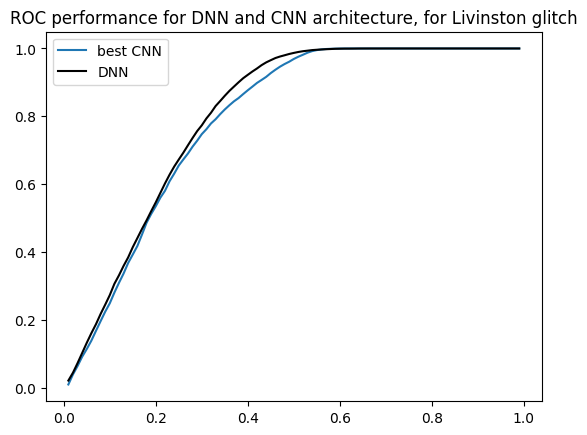

In [302]:
for key in ROC_collection.keys():
    if auc(ROC_collection[key][0], ROC_collection[key][1]) > 0.779:
        print(key)
        plt.plot(ROC_collection[key][0], ROC_collection[key][1], label = 'best CNN')
    # plt.legend()
    
plt.plot(FPR, TPR, color = 'black', label = 'DNN')
plt.legend()
plt.title('ROC performance for DNN and CNN architecture, for Livinston glitch')

Text(0.5, 1.0, 'ROC performance for DNN and CNN architecture, for Livinston glitch')

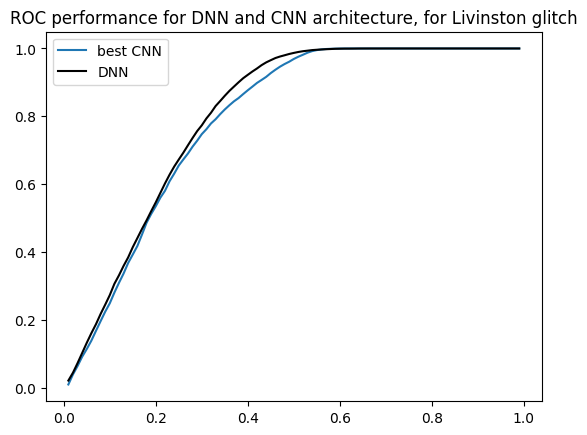

In [227]:
for key in ROC_collection.keys():
    if auc(ROC_collection[key][0], ROC_collection[key][1]) > 0.779:
        print(key)
        plt.plot(ROC_collection[key][0], ROC_collection[key][1], label = 'best CNN')
    # plt.legend()
    
plt.plot(FPR, TPR, color = 'black', label = 'DNN')
plt.legend()
plt.title('ROC performance for DNN and CNN architecture, for Livinston glitch')

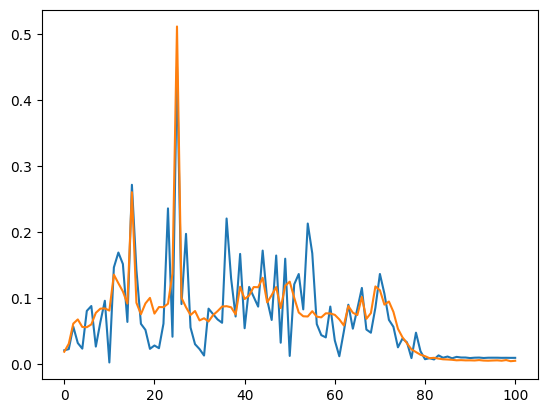

In [56]:
idx = 20

plt.plot(glitch_reserved_fft[:,:101][idx])
plt.plot(dcd_glitch[idx])

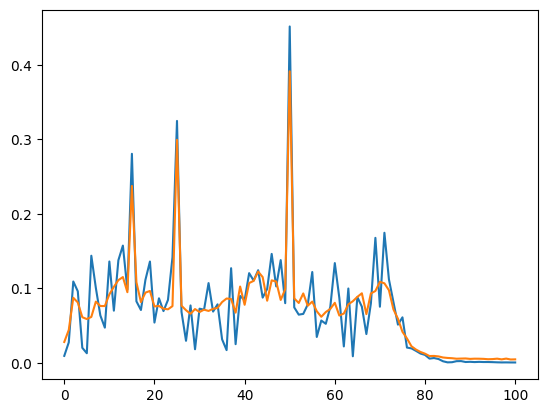

In [59]:
idx = 1000

plt.plot(bkg_reserved_fft[:,:101][idx])
plt.plot(dcd_bkg[idx])

### Step 2: noise

In [147]:
currentStep = "noise"

In [118]:
previousStep = "glitch"
bkg_filtered = bkg_fft[np.var(bkg_fft-dcd_bkg, axis=1)>=c0[previousStep]]
sg_filtered = sg_fft[np.var(sg_fft-dcd_sg, axis=1)>=c0[previousStep]]
bbh_filtered = bbh_fft[np.var(bbh_fft-dcd_bbh, axis=1)>=c0[previousStep]]

In [148]:
bkg_filtered = bkg_fft
sg_filtered = sg_fft
bbh_filtered = bbh_fft

In [149]:
bkg_filtered.shape

(70000, 202)

233.59361505508423


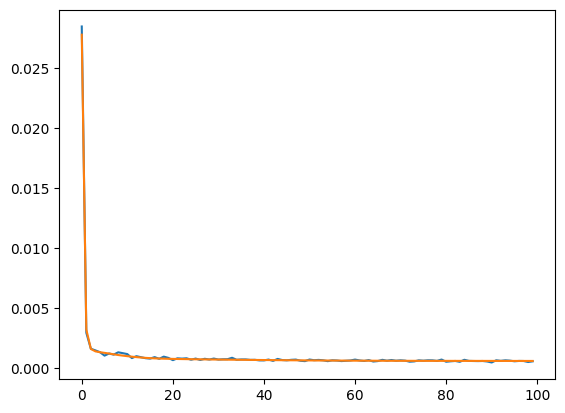

In [150]:
t0 = time.time()
dataset = bkg_filtered;

nTotal = len(dataset);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

X_train = dataset[:nTrain]
X_test = dataset[-nTest:]
X_validation = dataset[nTrain:-nTest]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros(epochs)
loss_validation = np.zeros(epochs)

wNorm = 0;

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = weighted_lossTrain.item()
    loss_validation[epoch] = val_loss
    
plt.plot(loss_train)
plt.plot(loss_validation)

print(time.time() - t0)

autoencoder.cpu().eval();
models[currentStep] = copy.deepcopy(autoencoder);

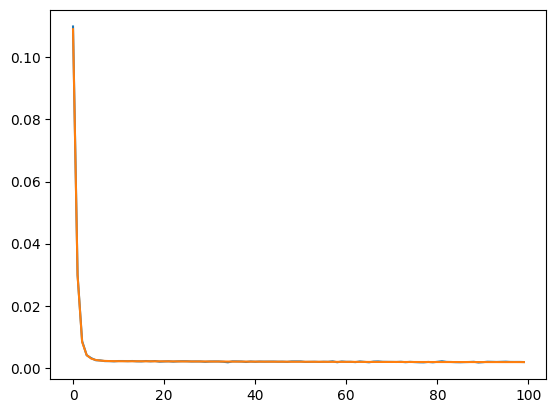

In [126]:
plt.plot(loss_train)
plt.plot(loss_validation)

In [151]:
autoencoder.cpu().eval();
models[currentStep] = copy.deepcopy(autoencoder);

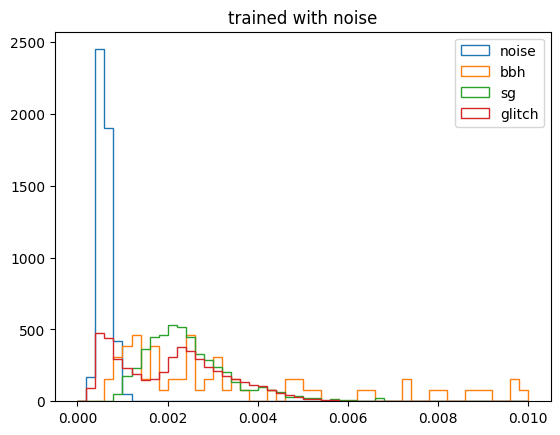

In [167]:
# Chia-Jui noise trained model + Chia-Jui dataset, Now we consider a shorter one

model = models[currentStep]

c0[currentStep] = 0.0014;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered[np.argwhere(bbh_snr > 24).flatten()]))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered[np.argwhere(bbh_snr > 24).flatten()]-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.legend()

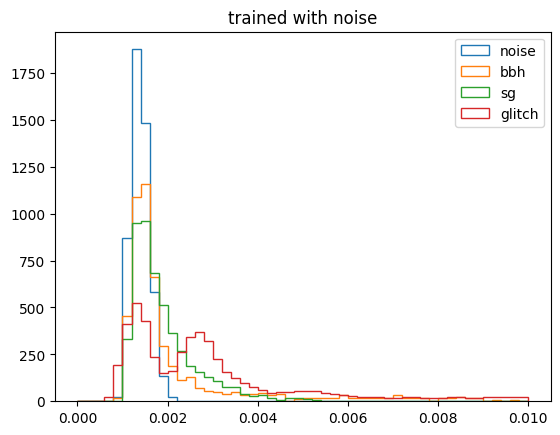

In [122]:
# Chia-Jui noise trained model + Chia-Jui dataset

model = models[currentStep]

c0[currentStep] = 0.0014;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.legend()

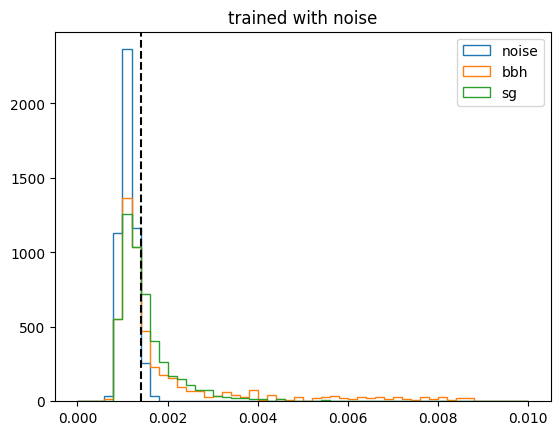

In [51]:
model = models[currentStep]

c0[currentStep] = 0.0014;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.legend()

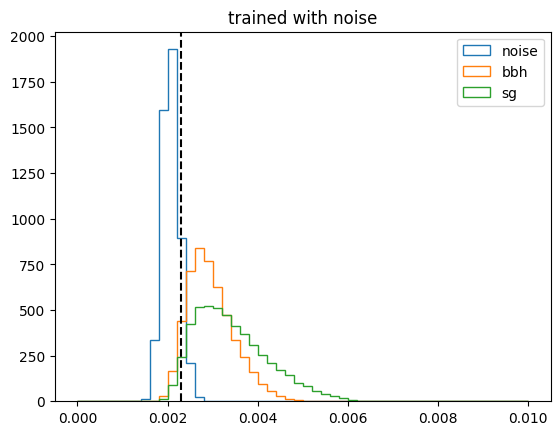

In [325]:
model = models[currentStep]

c0[currentStep] = 0.0023;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.legend()

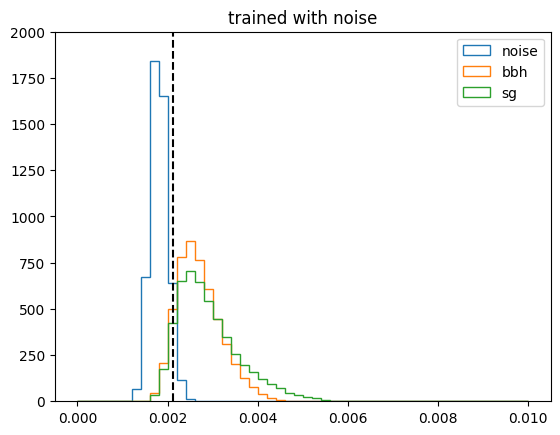

In [233]:
model = models[currentStep]

c0[currentStep] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.ylim(0,2000)
plt.legend()

In [234]:
np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))]

0.0021156612148213825

In [235]:
np.sum(np.var(bkg_filtered-dcd_bkg, axis=1) > np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))])/len(dcd_bkg)

0.058628571428571426

In [236]:
len(dcd_bkg)

35000

In [237]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=20, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=202, bias=True)
    (1): Sigmoid()
  )
)

In [193]:
torch.save(model, '../Model_cached/2_det_noise_trained_202-20-202_full_trained.pt')

In [151]:
torch.save(model, '../Model_cached/2_det_noise_trained_202-20-202.pt')

202-40-20-40-202

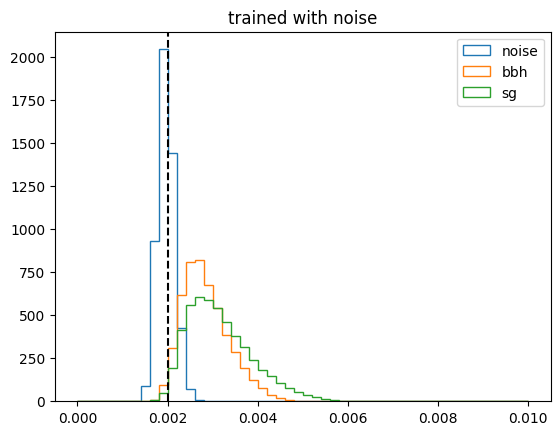

In [41]:
model = models[currentStep]

c0[currentStep] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.legend()

(0.0, 2000.0)

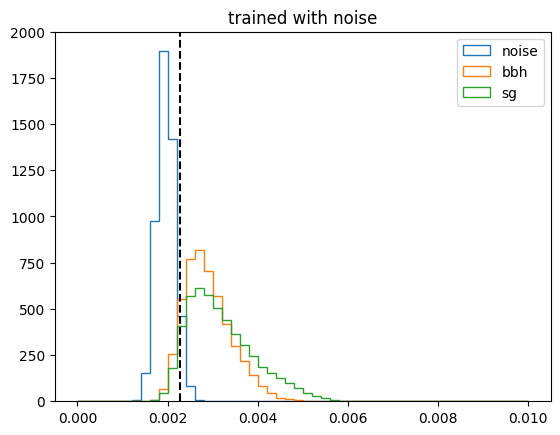

In [199]:
model = models[currentStep]

c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

In [200]:
np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))]

0.002274028343812618

In [201]:
np.sum(np.var(bkg_filtered-dcd_bkg, axis=1) > np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))])/len(dcd_bkg)

0.05828571428571429

In [202]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=202, bias=True)
    (3): Sigmoid()
  )
)

In [203]:
len(dcd_bkg)

35000

In [138]:
torch.save(model, '../Model_cached/2_det_noise_trained_202-40-20-40-202.pt')

In [204]:
torch.save(model, '../Model_cached/2_det_noise_trained_202-40-20-40-202_full_trained.pt')

In [368]:
models[currentStep] = torch.load('../Model_cached/2_det_noise_trained_202-20-10-20-202_full_trained.pt')

202-20-10-20-202

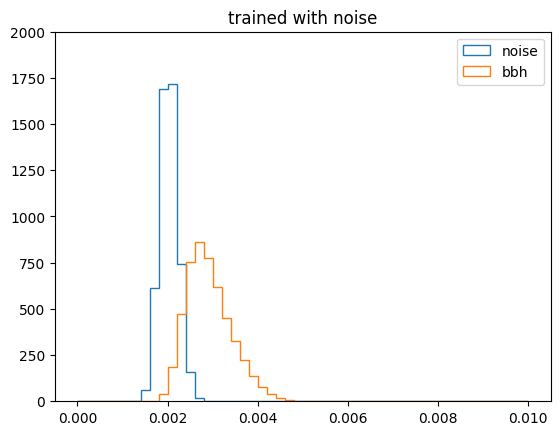

In [385]:
model = models[currentStep]

c0[currentStep] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")

# plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.ylim(0,2000)
plt.legend()

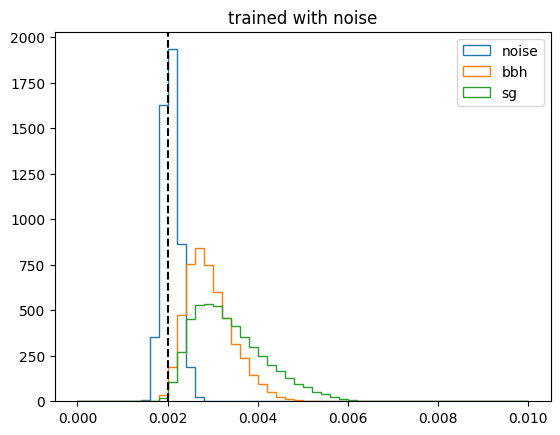

In [ ]:
model = models[currentStep]

c0[currentStep] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")

plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.ylim(0,2000)
plt.legend()

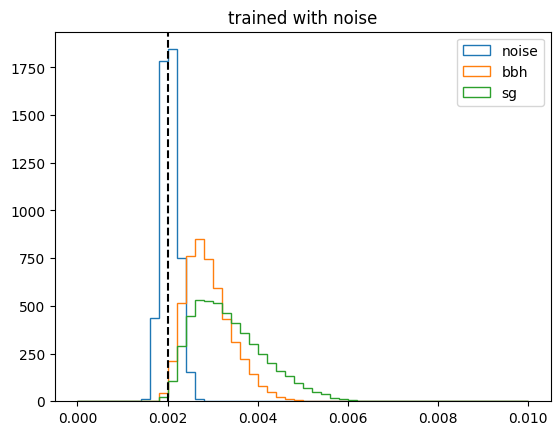

In [109]:
model = models[currentStep]

c0[currentStep] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.legend()

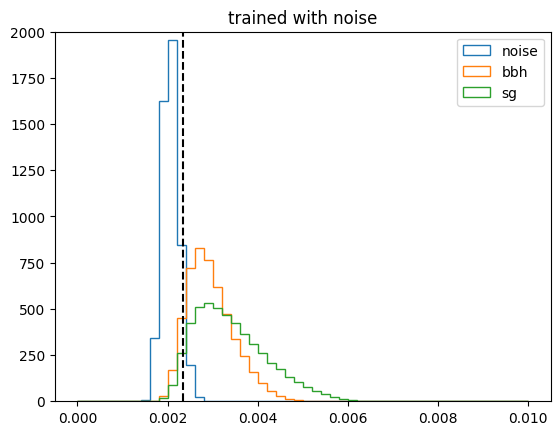

In [170]:
model = models[currentStep]

c0[currentStep] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")

plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.ylim(0,2000)
plt.legend()

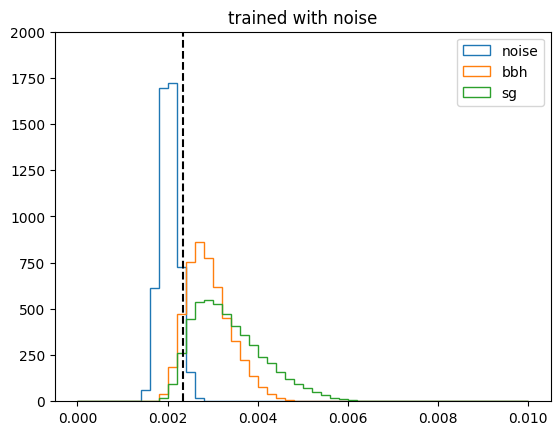

In [207]:
model = models[currentStep]

c0[currentStep] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")

plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.ylim(0,2000)
plt.legend()

In [208]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=202, bias=True)
    (3): Sigmoid()
  )
)

In [209]:
np.sum(np.var(bkg_filtered-dcd_bkg, axis=1) > np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))])/len(dcd_bkg)

0.06571428571428571

In [212]:
len(dcd_bbh)

70000

In [ ]:
torch.save(model, '../Model_cached/2_det_noise_trained_202-20-10-20-202.pt')

In [210]:
torch.save(model, '../Model_cached/2_det_noise_trained_202-20-10-20-202_full_trained.pt')

202-40-20-10-20-40-202

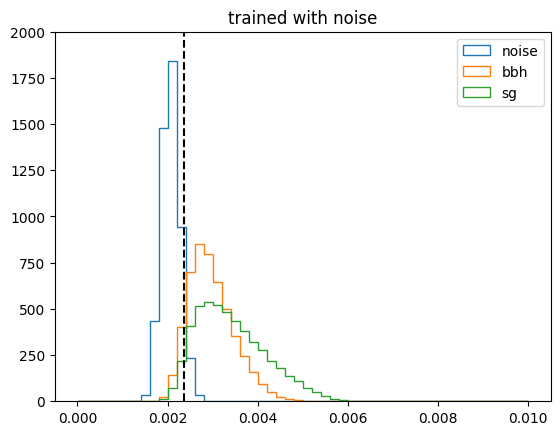

In [216]:
model = models[currentStep]

c0[currentStep] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.ylim(0,2000)
plt.legend()

In [217]:
np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))]

0.0023747607559129907

In [218]:
np.sum(np.var(bkg_filtered-dcd_bkg, axis=1) > np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))])/len(dcd_bkg)

0.06657142857142857

In [219]:
len(dcd_bkg)

35000

In [220]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=202, bias=True)
    (5): Sigmoid()
  )
)

In [221]:
torch.save(model, '../Model_cached/2_det_noise_trained_202-40-20-10-20-40-202_full_trained.pt')

202-40-20-40-202

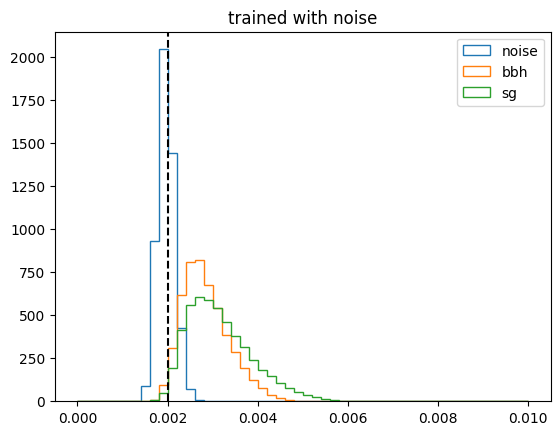

In [ ]:
model = models[currentStep]

c0[currentStep] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.legend()

(0.0, 2000.0)

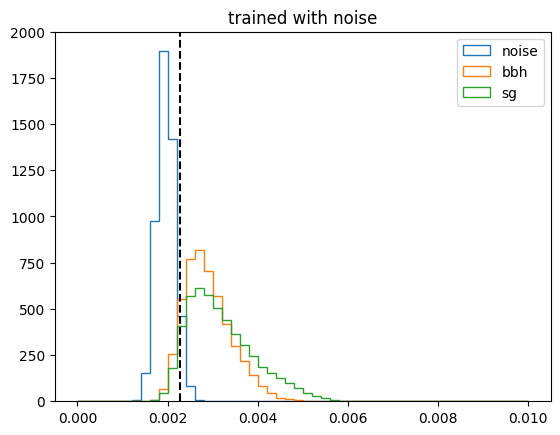

In [ ]:
model = models[currentStep]

c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

In [ ]:
np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))]

0.002274028343812618

In [ ]:
np.sum(np.var(bkg_filtered-dcd_bkg, axis=1) > np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))])/len(dcd_bkg)

0.05828571428571429

In [ ]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=202, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
len(dcd_bkg)

35000

In [ ]:
torch.save(model, '../Model_cached/2_det_noise_trained_202-40-20-40-202.pt')

In [ ]:
torch.save(model, '../Model_cached/2_det_noise_trained_202-40-20-40-202_full_trained.pt')

202-10-202

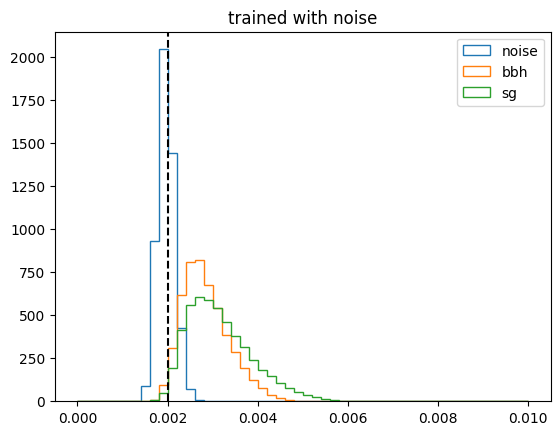

In [ ]:
model = models[currentStep]

c0[currentStep] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.legend()

(0.0, 2000.0)

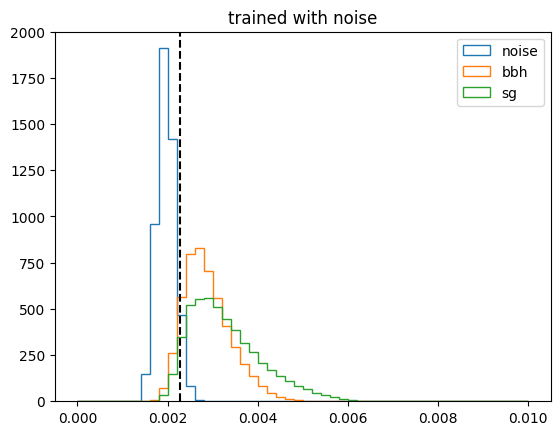

In [224]:
model = models[currentStep]

c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

In [225]:
np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))]

0.002269382944588902

In [226]:
np.sum(np.var(bkg_filtered-dcd_bkg, axis=1) > np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))])/len(dcd_bkg)

0.06362857142857142

In [227]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=10, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=202, bias=True)
    (1): Sigmoid()
  )
)

In [228]:
len(dcd_bkg)

35000

In [ ]:
torch.save(model, '../Model_cached/2_det_noise_trained_202-40-20-40-202.pt')

In [229]:
torch.save(model, '../Model_cached/2_det_noise_trained_202-10-202_full_trained.pt')

### Step 3: BBH

In [129]:
c0

{'glitch': 0.0018, 'noise': 0.002, 'bbh': 0.003}

In [130]:
previousStep = currentStep
currentStep = "bbh"
print("from "+previousStep+" to "+currentStep)

from noise to bbh


In [131]:
# bkg_filtered = bkg_fft[np.var(bkg_fft-dcd_bkg, axis=1)>=c0[previousStep]]
sg_filtered = sg_filtered[np.var(sg_filtered-dcd_sg, axis=1)>=c0[previousStep]]
bbh_filtered = bbh_filtered[np.var(bbh_filtered-dcd_bbh, axis=1)>=c0[previousStep]]

In [132]:
bbh_filtered.shape

(33152, 202)

110.8251314163208


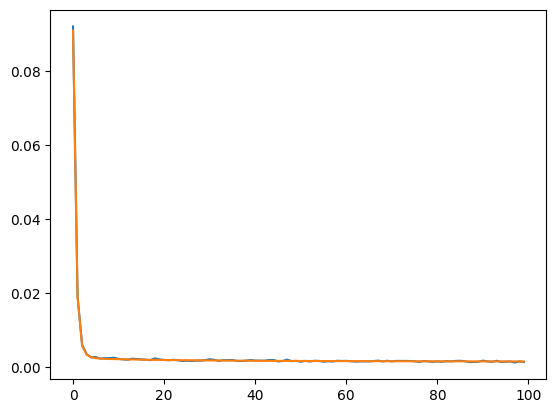

In [133]:
t0 = time.time()
dataset = bbh_filtered;

nTotal = len(dataset);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

X_train = dataset[:nTrain]
X_test = dataset[-nTest:]
X_validation = dataset[nTrain:-nTest]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros(epochs)
loss_validation = np.zeros(epochs)

wNorm = 0;

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = weighted_lossTrain.item()
    loss_validation[epoch] = val_loss
    
plt.plot(loss_train)
plt.plot(loss_validation)

print(time.time() - t0)

In [134]:
autoencoder.cpu().eval();
models[currentStep] = copy.deepcopy(autoencoder);

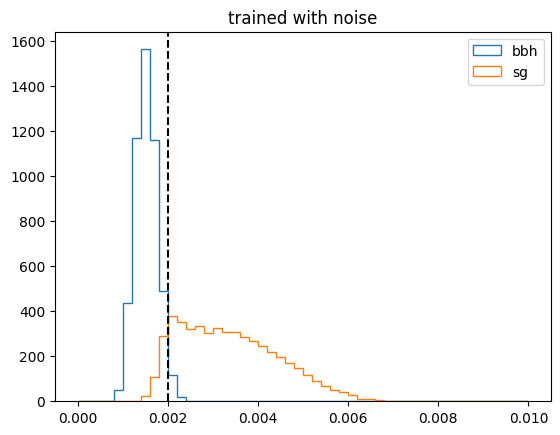

In [136]:
model = models[currentStep]

c0[currentStep] = 0.002;

# dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.legend()

### Step 4: SG

In [137]:
c0

{'glitch': 0.0018, 'noise': 0.002, 'bbh': 0.002}

In [138]:
previousStep = "bbh"
currentStep = "sg"
print("from "+previousStep+" to "+currentStep)

from bbh to sg


In [139]:
# bkg_filtered = bkg_fft[np.var(bkg_fft-dcd_bkg, axis=1)>=c0[previousStep]]
sg_filtered = sg_filtered[np.var(sg_filtered-dcd_sg, axis=1)>=c0[previousStep]]
# bbh_filtered = bbh_filtered[np.var(bbh_filtered-dcd_bbh, axis=1)>=c0[previousStep]]

In [140]:
sg_filtered.shape

(30592, 202)

50.879576444625854


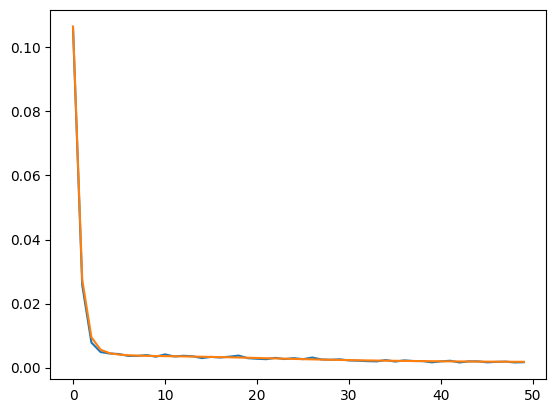

In [152]:
t0 = time.time()
dataset = sg_filtered;

nTotal = len(dataset);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

X_train = dataset[:nTrain]
X_test = dataset[-nTest:]
X_validation = dataset[nTrain:-nTest]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros(epochs)
loss_validation = np.zeros(epochs)

wNorm = 0;

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = weighted_lossTrain.item()
    loss_validation[epoch] = val_loss
    
plt.plot(loss_train)
plt.plot(loss_validation)

print(time.time() - t0)

In [153]:
autoencoder.cpu().eval();
models[currentStep] = copy.deepcopy(autoencoder);

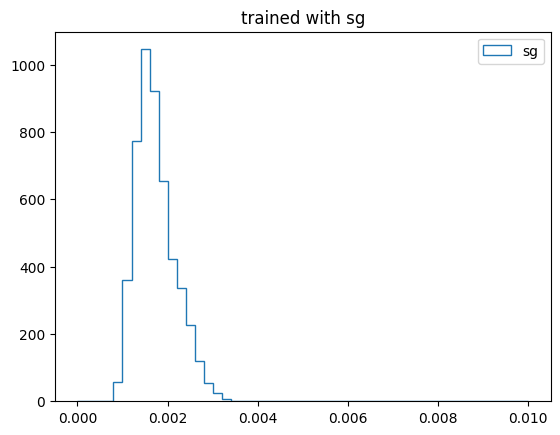

In [154]:
model = models[currentStep]

# c0[currentStep] = 0.0018;

# dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with sg")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.legend()

In [141]:
print(sum(p.numel() for p in autoencoder.parameters() if p.requires_grad))

8302


## streamline of the sequential training

In [174]:
version = "v4";

In [175]:
N_bkg = len(bkg_reserved_fft);
N_glitch = int(N_bkg/15);
N_bbh = int(N_bkg*2/15);
N_sg = int(N_bkg*2/15);

testset = np.empty((N_bkg+N_glitch+N_bbh+N_sg, len(bkg_reserved_fft[0])))

s = 0;
testset[s : s+N_glitch] = glitch_reserved_fft[np.random.permutation(len(glitch_reserved_fft))[:N_glitch]];
s += N_glitch;

testset[s : s+N_bkg] = bkg_reserved_fft[np.random.permutation(len(bkg_reserved_fft))[:N_bkg]];
s += N_bkg;

testset[s : s+N_bbh] = bbh_reserved_fft[np.random.permutation(len(bbh_reserved_fft))[:N_bbh]];
s += N_bbh;

testset[s : s+N_sg] = sg_reserved_fft[np.random.permutation(len(sg_reserved_fft))[:N_sg]];
s += N_sg;

correct_ans = np.concatenate(([0]*N_glitch, [1]*N_bkg, [2]*N_bbh, [3]*N_sg))

Nsample = {};
Nsample["glitch"] = N_glitch;
Nsample["noise"] = N_bkg;
Nsample["bbh"] = N_bbh;
Nsample["sg"] = N_sg

In [176]:
Nsample["bbh"]

2000

In [ ]:
# epochs = 50;

# datatype2ind = {"glitch":0, "noise":1, "bbh":2, "sg":3};
# ind2datatype = {};
# for key in datatype2ind.keys():
#     ind2datatype[datatype2ind[key]] = key

In [177]:
epochs = 50;

# arranging the sequences of the series
ind2datatype = {0:"glitch", 1:"noise", 2:"bbh", 3:"sg"}
datatype2ind = {};
for key in ind2datatype.keys():
    datatype2ind[ind2datatype[key]] = key
    
torch.save(ind2datatype, "../Data_cached/SequentialTraining/sequence_"+version+".json")

In [178]:
Ncut = 5;
cutList = {};

max_glitch = 0.0014;
min_glitch = 0.0024;
cutList["glitch"] = np.linspace(min_glitch, max_glitch, Ncut);

max_bkg = 0.0016;
min_bkg = 0.0026;
cutList["noise"] = np.linspace(min_bkg, max_bkg, Ncut);

max_bbh = 0.0014;
min_bbh = 0.0024;
cutList["bbh"] = np.linspace(min_bbh, max_bbh, Ncut);

max_sg = 0.0008;
min_sg = 0.0032;
cutList["sg"] = np.linspace(min_sg, max_sg, Ncut);

In [179]:
torch.save(cutList, "../Data_cached/SequentialTraining/cut_"+version+".json")

In [180]:
models = {};
models["glitch"] = torch.load("../Model_cached/2_det_oneglitchonenoise_trained.pt")
models["glitch"].cpu().eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=20, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=202, bias=True)
    (1): Sigmoid()
  )
)

In [181]:
def trainAE(dataset):
    
    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData, trainData)
    test_dataset = TensorDataset(testData, testData)
    validation_dataset = TensorDataset(validationData, validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()

    wNorm = 0;

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, (x, _) in enumerate(trainDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()
            
    return autoencoder.cpu().eval()

In [182]:
import itertools

In [184]:
cnt = 0;

ic = np.zeros(4, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
ic[3] = 0;

listResult = {};
listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1], ic[2] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):

    data_filtered = {};
    data_filtered["noise"] = bkg_fft;
    data_filtered["bbh"] = bbh_fft;
    data_filtered["sg"] = sg_fft;
    
    for iPrev in range(3):
        previousStep = ind2datatype[iPrev];
        modelPrev = models[previousStep];
        
        # filter the data
        for j in range(iPrev+1, 4):
            dt = ind2datatype[j];
            dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
            data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
            
        currentStep = ind2datatype[iPrev+1];
        model = trainAE(data_filtered[currentStep]);
        models[currentStep] = model;
        
    torch.save(models, "../Data_cached/SequentialTraining/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
    
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    for datatype in list_datatype:
        dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
        err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
    not_select = np.array([True]*len(testset));

    for iStep in range(len(list_datatype)):
        datatype = ind2datatype[iStep];
        ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
        ans[ind_pass] = iStep;
        not_select[ind_pass] = False;
        
    ans[not_select] = -1;
    
    listResult["cut"][cnt] = ic;
    listResult["ans"][cnt] = ans;
    
    acc = np.zeros(len(ind2datatype));
    
    for i in range(len(ind2datatype)):
        acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
    listResult["accuracy_4"][cnt] = acc;
    
    listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
                                     np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    
    cnt += 1;
    print(cnt)
    
listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
torch.save(listResult, "../Data_cached/SequentialTraining/training_performance_"+version+".json")

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_20492\1325254030.py:66: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]),
C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_20492\1325254030.py:67: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
65
66
67
68
69
70
71


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


In [231]:
foo = np.array([ [0.01*A, np.sum(np.all(listResult["accuracy_2"] >= 0.01*A, axis=1))/len(listResult["accuracy_2"])] for A in range(101)])

In [165]:
listResult["accuracy_4"]

array([[9.99000000e-01, 2.51333333e-02, 6.93000000e-01, 0.00000000e+00],
       [9.99000000e-01, 7.80000000e-03, 6.38000000e-01, 1.50000000e-03],
       [9.99000000e-01, 2.43333333e-02, 2.43000000e-01, 2.00000000e-03],
       [9.99000000e-01, 0.00000000e+00, 6.91000000e-01, 1.00000000e-03],
       [9.99000000e-01, 0.00000000e+00, 6.02000000e-01, 1.50000000e-03],
       [9.99000000e-01, 0.00000000e+00, 2.19000000e-01, 2.50000000e-03],
       [9.99000000e-01, 0.00000000e+00, 6.96000000e-01, 1.50000000e-03],
       [9.99000000e-01, 0.00000000e+00, 6.46000000e-01, 1.50000000e-03],
       [9.99000000e-01, 0.00000000e+00, 2.15500000e-01, 1.00000000e-03],
       [9.30000000e-01, 7.94666667e-01, 6.42000000e-01, 1.00000000e-03],
       [9.30000000e-01, 7.94133333e-01, 6.29500000e-01, 1.50000000e-03],
       [9.30000000e-01, 7.94800000e-01, 2.56000000e-01, 2.50000000e-03],
       [9.30000000e-01, 5.88733333e-01, 9.54000000e-01, 5.00000000e-04],
       [9.30000000e-01, 5.95466667e-01, 9.06500000e

In [168]:
listResult["accuracy_2"]

array([[0.086    , 0.3465   ],
       [0.06975  , 0.31975  ],
       [0.08525  , 0.1225   ],
       [0.0624375, 0.346    ],
       [0.0624375, 0.30175  ],
       [0.0624375, 0.11075  ],
       [0.0624375, 0.34875  ],
       [0.0624375, 0.32375  ],
       [0.0624375, 0.10825  ],
       [0.803125 , 0.3215   ],
       [0.802625 , 0.3155   ],
       [0.80325  , 0.12925  ],
       [0.6100625, 0.47725  ],
       [0.616375 , 0.45375  ],
       [0.6321875, 0.1815   ],
       [0.0625   , 0.49125  ],
       [0.0603125, 0.44725  ],
       [0.064375 , 0.15375  ],
       [0.9683125, 0.3075   ],
       [0.9685   , 0.2795   ],
       [0.9685   , 0.10925  ],
       [0.7964375, 0.4775   ],
       [0.8489375, 0.4425   ],
       [0.870875 , 0.149    ],
       [0.0934375, 0.4995   ],
       [0.0705   , 0.4795   ],
       [0.0769375, 0.23325  ]])

Text(0, 0.5, 'percentage')

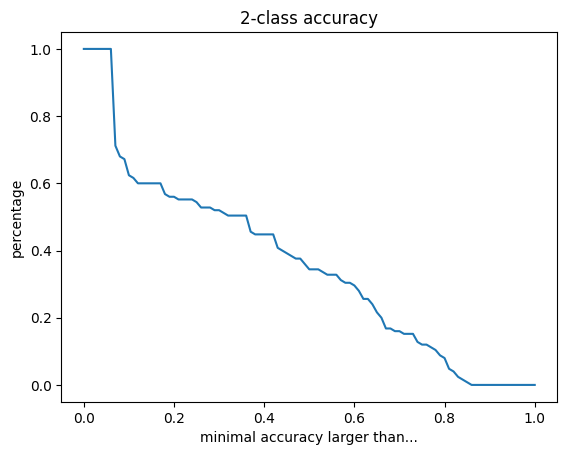

In [233]:
plt.plot(foo[:, 0], foo[:, 1])
plt.title('2-class accuracy')
plt.xlabel('minimal accuracy larger than...')
plt.ylabel('percentage')

In [164]:
cutList["glitch"]

array([0.0024, 0.0019, 0.0014])

In [172]:
cutList["noise"]

array([0.0026, 0.0021, 0.0016])

In [173]:
cutList["bbh"]

array([0.0024, 0.0019, 0.0014])

In [188]:
listResult["accuracy_4"][np.argwhere(np.all(listResult["accuracy_4"]>0.76, axis=1)).flatten()]

array([[0.941     , 0.77693333, 0.8045    , 0.809     ],
       [0.941     , 0.76986667, 0.761     , 0.88      ]])

In [198]:
listResult["accuracy_2"][np.argwhere(np.all(listResult["accuracy_2"]>0.85, axis=1)).flatten()]

array([[0.859375, 0.8515  ]])

In [298]:
listResult["accuracy_4"][np.argwhere(np.all(listResult["accuracy_2"]>0.85, axis=1)).flatten()]

array([[0.505 , 0.883 , 0.9205, 0.7825]])

In [189]:
listResult["cut"][np.argwhere(np.all(listResult["accuracy_4"]>0.76, axis=1)).flatten()]

array([[2, 1, 1, 0],
       [2, 1, 2, 0]])

In [234]:
listResult["cut"][np.argwhere(np.all(listResult["accuracy_2"]>0.85, axis=1)).flatten()]

array([[4, 2, 1, 0]])

In [239]:
listResult["cut"][np.argmax(listResult["total_accuracy"]).flatten()]

array([[4, 1, 2, 0]])

In [194]:
listResult["accuracy_4"][np.argmax(listResult['total_accuracy']).flatten()]

array([[0.505     , 0.98333333, 0.7675    , 0.8375    ]])

In [263]:
np.max(listResult['total_accuracy'])

0.92325

In [ ]:
total_accuracy_altered = 

In [201]:
np.argwhere(np.all(listResult["cut"] == np.array([2,1,1,0]), axis = 1))

array([[56]], dtype=int64)

In [287]:
np.argwhere(np.all(listResult["cut"] == np.array([4,1,2,0]), axis = 1))

array([[107]], dtype=int64)

In [207]:
listResult.keys()

dict_keys(['cut', 'ans', 'accuracy_4', 'accuracy_2', 'total_accuracy'])

In [332]:
cutList['glitch']

array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ])

In [339]:
cutList['bbh']

array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ])

In [336]:
models = torch.load('../Data_cached/SequentialTraining/trained_model421_v4.json')

In [337]:
model = models

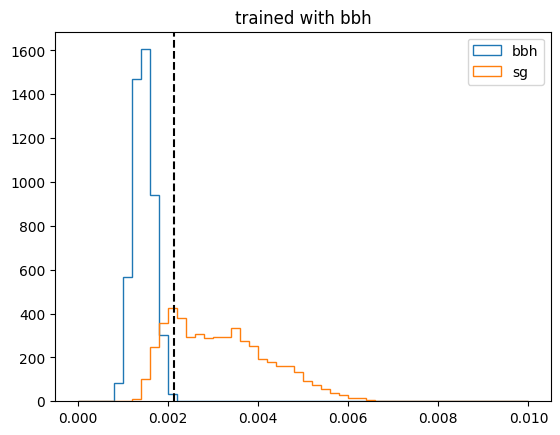

In [340]:
dcd_bkg = model['bbh'](torch.FloatTensor(testset[-(N_bbh + N_sg + N_bkg):-(N_bbh + N_sg)]))[1].detach().numpy()
# dcd_signal = model['noise'](torch.FloatTensor(testset[-(N_bbh + N_sg + N_bkg):-N_sg]))[1].detach().numpy()
dcd_bbh = model['bbh'](torch.FloatTensor(testset[-(N_bbh + N_sg):-N_sg]))[1].detach().numpy()
dcd_sg = model['bbh'](torch.FloatTensor(testset[-N_sg:]))[1].detach().numpy()
dcd_glitch = model['bbh'](torch.FloatTensor(testset[:N_glitch]))[1].detach().numpy()

# foo = plt.hist(np.var(testset[-(N_bbh + N_sg + N_bkg):-(N_bbh + N_sg)]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(testset[-(N_bbh + N_sg + N_bkg):-N_sg]-dcd_signal, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="signal")
foo = plt.hist(np.var(testset[-(N_bbh + N_sg):-N_sg]-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(testset[-N_sg:]-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(testset[:N_glitch]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")

# plt.axvline(0.019)

plt.title("trained with bbh")
plt.axvline(0.00215, color="k", linestyle="--")
plt.legend()

In [242]:
N_bbh + N_sg + N_bkg

19000

In [249]:
N_glitch

1000

In [342]:
ans = listResult["ans"][np.argmax(listResult["total_accuracy"]).flatten()]

In [346]:
np.sum(ans == 2)

1605

In [345]:
np.sum(np.logical_and(ans == 2, correct_ans == 2))

1535

## How about Chia-Jui's new dataset using same procedure? (Roburtness check) 

In [386]:
realbkg_L = np.load('../Data_cached/real_bkg_2202000_63917s_4000Hz_50ms.npy')
realbkg_H = np.load('../Data_cached/real_bkg_H_1466640_58803s_4000Hz_50ms.npy')
realbbh = np.load('../Data_cached/injected_BBH_1823_around_merger_time_63917_58803.npz')['strain']
realbbh_snr = np.load('../Data_cached/injected_BBH_1823_around_merger_time_63917_58803.npz')['snr']

In [387]:
realbbh.shape

(1823, 2, 200)

(array([  2.,  16.,  51.,  57.,  83.,  89., 109., 100.,  82.,  83.,  80.,
         72.,  61.,  59.,  65.,  37.,  47.,  30.,  34.,  30.,  31.,  39.,
         26.,  19.,  19.,  20.,  15.,  17.,  16.,  15.,   9.,  17.,  13.,
          9.,  12.,  12.,  10.,  11.,  11.,   8.,   8.,  11.,  14.,   4.,
          6.,   5.,   4.,  10.,   8.,   7.,   2.,   4.,   6.,   3.,   7.,
          2.,   2.,   3.,   0.,   2.,   8.,   4.,   6.,   3.,   3.,   4.,
          5.,   5.,   3.,   1.,   0.,   1.,   0.,   1.,   1.,   0.,   1.,
          4.,   2.,   1.,   2.,   1.,   1.,   0.,   2.,   3.,   1.,   0.,
          0.,   4.,   2.,   1.,   1.,   2.,   1.,   0.,   2.,   2.,   3.,
          1.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  4

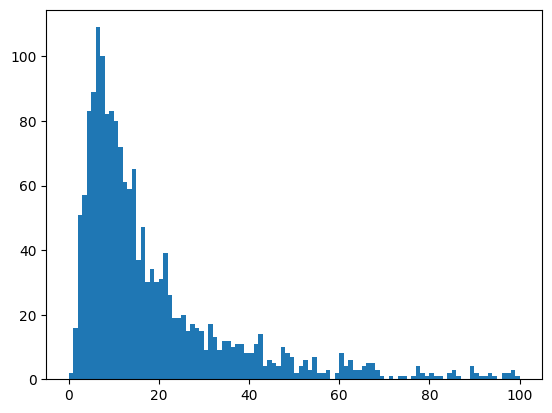

In [349]:
plt.hist(realbbh_snr,range=(0,100),bins = 100)

In [392]:
np.random.shuffle(realbkg_L)
np.random.shuffle(realbkg_H)

In [393]:
realbkg_L.shape

(2202000, 200)

In [394]:
realbkg = np.hstack((realbkg_L[:100000], realbkg_H[:100000])).reshape(-1,2,200)

In [395]:
realbkg.shape

(100000, 2, 200)

In [396]:
realbbh.shape

(1823, 2, 200)

In [397]:
realbkg = realbkg.reshape(-1,200)

In [398]:
realbbh = realbbh.reshape(-1,200)

In [399]:
# perm = np.random.permutation(len(realbkg))
# perm = np.loadtxt("../data/perm_4ae_bkg.dat").astype("int");

bkg = realbkg[:int(len(realbkg)*0.7)]
bkg_reserved = realbkg[int(len(realbkg)*0.7):]
bkg = bkg/np.linalg.norm([bkg], axis=2).T
bkg_reserved = bkg_reserved/np.linalg.norm([bkg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bkg.dat", perm)

# perm = np.random.permutation(len(realbbh))
# perm = np.loadtxt("../data/perm_4ae_bbh.dat").astype("int");
# perm = np.arange(1e5)
bbh = realbbh
# bbh_reserved = realbbh[int(len(realbbh)*0.7):]
bbh = bbh/np.linalg.norm([bbh], axis=2).T
# bbh_reserved = bbh_reserved/np.linalg.norm([bbh_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bbh.dat", perm)

# perm = np.random.permutation(len(realsg))
# perm = np.loadtxt("../data/perm_4ae_sg.dat").astype("int");
# # perm = np.arange(1e5)
# sg = realsg[:int(len(realsg)*0.7)]
# sg_reserved = realsg[int(len(realsg)*0.7):]
# sg = sg/np.linalg.norm([sg], axis=2).T
# sg_reserved = sg_reserved/np.linalg.norm([sg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_sg.dat", perm)

# perm = np.random.permutation(len(realglitch))
# perm = np.loadtxt("../data/perm_4ae_glitch.dat").astype("int");
# perm = np.arange(60132)
# glitch = realglitch[:int(len(realglitch)*0.7)]
# glitch_reserved = realglitch[int(len(realglitch)*0.7):]
# glitch = glitch/np.linalg.norm([glitch], axis=2).T
# glitch_reserved = glitch_reserved/np.linalg.norm([glitch_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_glitch.dat", perm)
# bkg_fft = bkg
# bkg_reserved_fft = bkg_reserved

# bbh_fft = bbh
# bbh_reserved_fft = bbh_reserved

# sg_fft = sg
# sg_reserved_fft = sg_reserved

# glitch_fft = glitch
# glitch_reserved_fft = glitch_reserved

bkg_fft = abs(np.fft.rfft(bkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T
bkg_reserved_fft = abs(np.fft.rfft(bkg_reserved))
bkg_reserved_fft = bkg_reserved_fft/np.linalg.norm([bkg_reserved_fft], axis=2).T

bbh_fft = abs(np.fft.rfft(bbh))
bbh_fft = bbh_fft/np.linalg.norm([bbh_fft], axis=2).T
bbh_reserved_fft = abs(np.fft.rfft(bbh_reserved))
bbh_reserved_fft = bbh_reserved_fft/np.linalg.norm([bbh_reserved_fft], axis=2).T

# sg_fft = abs(np.fft.rfft(sg))
# sg_fft = sg_fft/np.linalg.norm([sg_fft], axis=2).T
# sg_reserved_fft = abs(np.fft.rfft(sg_reserved))
# sg_reserved_fft = sg_reserved_fft/np.linalg.norm([sg_reserved_fft], axis=2).T

# glitch_fft = abs(np.fft.rfft(glitch))
# glitch_fft = glitch_fft/np.linalg.norm([glitch_fft], axis=2).T
# glitch_reserved_fft = abs(np.fft.rfft(glitch_reserved))
# glitch_reserved_fft = glitch_reserved_fft/np.linalg.norm([glitch_reserved_fft], axis=2).T


In [400]:
bbh_fft.shape

(3646, 101)

In [401]:
bkg_fft = bkg_fft.reshape(-1,202)
bkg_reserved_fft = bkg_reserved_fft.reshape(-1,202)

bbh_fft = bbh_fft.reshape(-1,202)
# bbh_reserved_fft = bbh_reserved_fft.reshape(-1,202)

# sg_fft = sg_fft.reshape(-1,202)
# sg_reserved_fft = sg_reserved_fft.reshape(-1,202)

# glitch_fft = glitch_fft.reshape(-1,202)
# glitch_reserved_fft = glitch_reserved_fft.reshape(-1,202)

In [402]:
bkg_filtered = bkg_fft
# sg_filtered = sg_fft
bbh_filtered = bbh_fft

In [403]:
bkg_filtered.shape

(70000, 202)

In [421]:
bbh_filtered.shape

(1823, 202)

In [434]:
snr_range = [[5,12],[12,24],[24,48],[48,96]]

In [435]:
realbbh_snr.shape

(1823,)

In [436]:
np.argwhere(realbbh_snr > 96).shape

(125, 1)

In [437]:
realbbh_list = {}
for i in range(4):
    realbbh_list["-".join([str(snr_range[i][0]),str(snr_range[i][1])])] = bbh_filtered[np.argwhere(np.logical_and(realbbh_snr > snr_range[i][0], realbbh_snr <= snr_range[i][1])).flatten()]

In [438]:
realbbh_list['5-12'].shape

(615, 202)

In [424]:
realbbh_list['12-24'].shape

(478, 202)

In [425]:
realbbh_list['24-48'].shape

(276, 202)

In [426]:
realbbh_list['48-96'].shape

(120, 202)

### If one is using the new dataset

In [62]:
realbkg_L = np.load('../Data_cached/real_bkg_2202000_63917s_4000Hz_50ms.npy')[:100000]
realbkg_H = np.load('../Data_cached/real_bkg_H_1466640_58803s_4000Hz_50ms.npy')[:100000]

realbkg = np.hstack((realbkg_L[:100000], realbkg_H[:100000])).reshape(-1,200)

In [63]:
bkg = realbkg[:int(len(realbkg)*0.7)]
bkg_reserved = realbkg[int(len(realbkg)*0.7):]
bkg = bkg/np.linalg.norm([bkg], axis=2).T
bkg_reserved = bkg_reserved/np.linalg.norm([bkg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bkg.dat", perm)

bkg_fft = abs(np.fft.rfft(bkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T
bkg_reserved_fft = abs(np.fft.rfft(bkg_reserved))
bkg_reserved_fft = bkg_reserved_fft/np.linalg.norm([bkg_reserved_fft], axis=2).T

In [64]:
bkg_fft.shape

(140000, 101)

In [65]:
bkg_fft = bkg_fft.reshape(-1,202)
bkg_reserved_fft = bkg_reserved_fft.reshape(-1,202)

In [67]:
np.load('../Data_cached/injected_BBH_snr5-12.npz')['strain'].shape

(1902, 2, 200)

In [68]:
snr_list = ['5-12','12-24','24-48','48-96']

realbbh_list = {}

for snr_range in snr_list:
    
    realbbh_data = np.load('../Data_cached/injected_BBH_snr' + snr_range + '.npz')['strain'].reshape(-1,200)
    realbbh_data = realbbh_data / np.linalg.norm([realbbh_data], axis=2).T
    
    realbbh_data_fft = abs(np.fft.rfft(realbbh_data))
    realbbh_data_fft = realbbh_data_fft / np.linalg.norm([realbbh_data_fft], axis=2).T
    
    realbbh_data_fft = realbbh_data_fft.reshape(-1,202)
    
    realbbh_list[snr_range] = realbbh_data_fft
    

In [69]:
bkg_filtered = bkg_reserved_fft

'glitch_H'

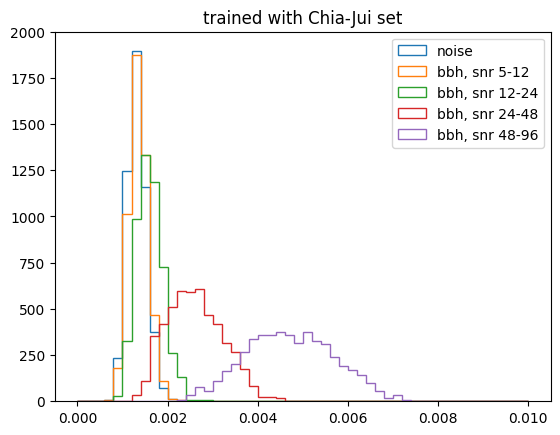

In [73]:
model = torch.load('../Model_cached/2_det_Chia-Jui_noise_trained_202-20-10-20-202_full_trained.pt')

# c0[currentStep] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")

for snr in realbbh_list.keys():
    dcd_bbh = model(torch.FloatTensor(realbbh_list[snr]))[1].detach().numpy()
    foo = plt.hist(np.var(realbbh_list[snr]-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh, snr " + snr)

plt.title("trained with Chia-Jui set")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
# plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.ylim(0,2000)
plt.legend()

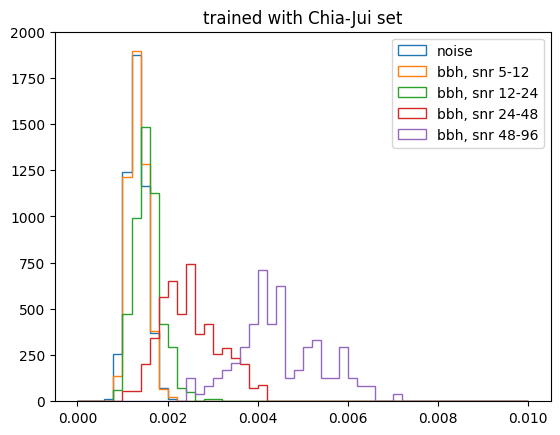

In [439]:
model = models[currentStep]

# c0[currentStep] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")

for snr in realbbh_list.keys():
    dcd_bbh = model(torch.FloatTensor(realbbh_list[snr]))[1].detach().numpy()
    foo = plt.hist(np.var(realbbh_list[snr]-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh, snr " + snr)

plt.title("trained with Chia-Jui set")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
# plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.ylim(0,2000)
plt.legend()

307.2644658088684


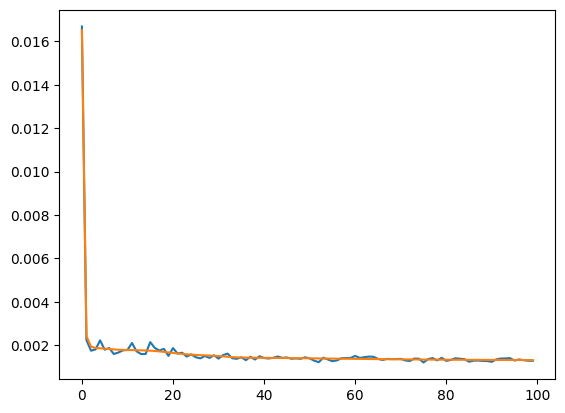

In [255]:
t0 = time.time()
dataset = bkg_filtered;

nTotal = len(dataset);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

X_train = dataset[:nTrain]
X_test = dataset[-nTest:]
X_validation = dataset[nTrain:-nTest]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros(epochs)
loss_validation = np.zeros(epochs)

wNorm = 0;

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = weighted_lossTrain.item()
    loss_validation[epoch] = val_loss
    
plt.plot(loss_train)
plt.plot(loss_validation)

print(time.time() - t0)

autoencoder.cpu().eval();
models[currentStep] = copy.deepcopy(autoencoder);

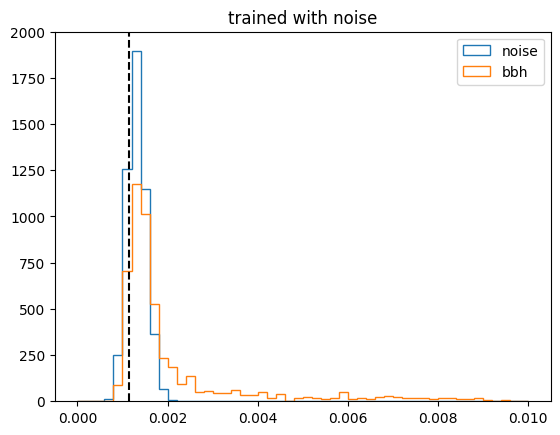

In [261]:
model = models[currentStep]

c0[currentStep] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.ylim(0,2000)
plt.legend()

In [419]:
models[currentStep] = torch.load('../Model_cached/2_det_Chia-Jui_noise_trained_202-20-10-20-202_full_trained.pt')

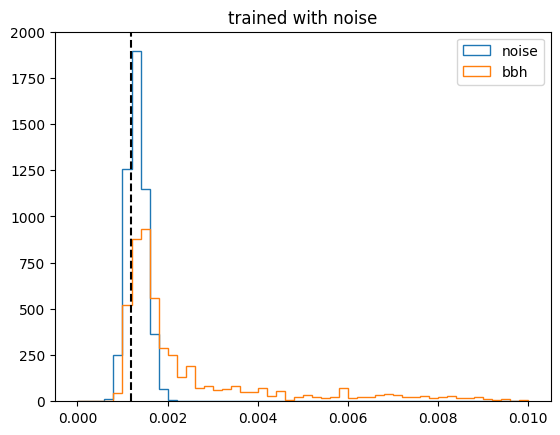

In [272]:
model = models[currentStep]

c0[currentStep] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.ylim(0,2000)
plt.legend()

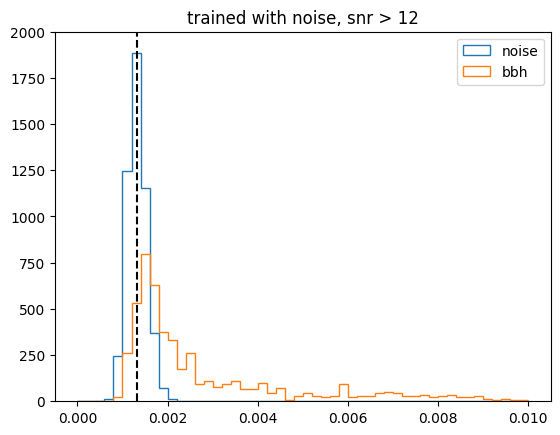

In [344]:
model = models[currentStep]

c0[currentStep] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise, snr > 12")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.ylim(0,2000)
plt.legend()

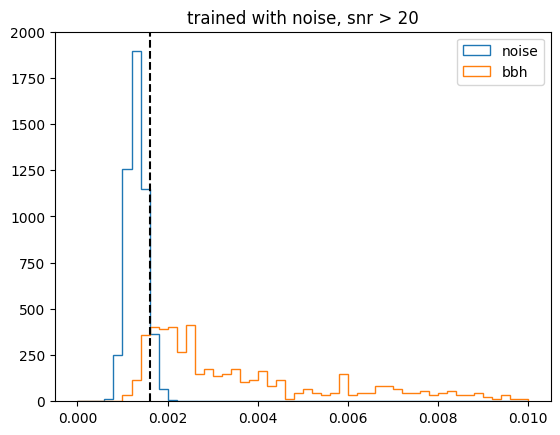

In [289]:
model = models[currentStep]

c0[currentStep] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise, snr > 20")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.ylim(0,2000)
plt.legend()

In [418]:
models[currentStep] = torch.load('../Model_cached/2_det_noise_trained_202-20-10-20-202_full_trained.pt')

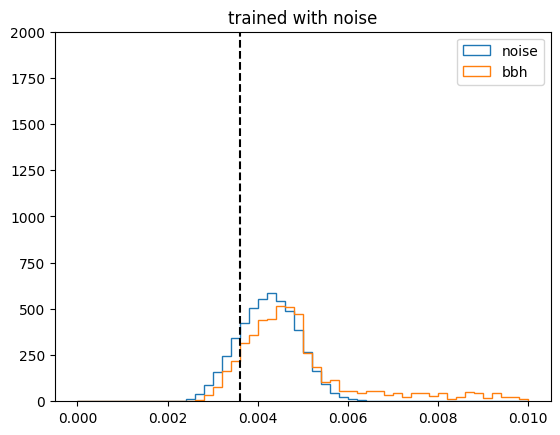

In [277]:
model = models[currentStep]

c0[currentStep] = 0.002;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.ylim(0,2000)
plt.legend()

In [257]:
np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))]

0.0011468632093249696

In [258]:
np.sum(np.var(bkg_filtered-dcd_bkg, axis=1) > np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))])/len(dcd_bkg)

0.7893428571428571

In [259]:
len(dcd_bkg)

70000

In [273]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=202, bias=True)
    (3): Sigmoid()
  )
)

In [274]:
torch.save(model, '../Model_cached/2_det_Chia-Jui_noise_trained_202-20-10-20-202_full_trained.pt')

Below are useless

In [ ]:
bkg = realbkg[:int(len(realbkg)*0.7)]
bkg_reserved = realbkg[int(len(realbkg)*0.7):]
bkg = bkg/np.linalg.norm([bkg], axis=2).T
bkg_reserved = bkg_reserved/np.linalg.norm([bkg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bkg.dat", perm)

# perm = np.random.permutation(len(realbbh))
# perm = np.loadtxt("../data/perm_4ae_bbh.dat").astype("int");
# perm = np.arange(1e5)
bbh = realbbh[:int(len(realbbh)*0.7)]
bbh_reserved = realbbh[int(len(realbbh)*0.7):]
bbh = bbh/np.linalg.norm([bbh], axis=2).T
bbh_reserved = bbh_reserved/np.linalg.norm([bbh_reserved], axis=2).T

In [7]:
renorm_factor = 20;

realbkg = np.load("../data/Datasets/background.npz")['data'] / renorm_factor;
realbbh = np.load("../data/Datasets/bbh_for_challenge.npy") / renorm_factor;

realsg = np.load("../data/Datasets/sglf_for_challenge.npy") / renorm_factor;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch = np.load("../data/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"]

# perm = np.random.permutation(len(realbkg))
perm = np.loadtxt("../data/perm_4ae_bkg.dat").astype("int");
bkg = realbkg[perm, 0][:int(len(perm)*0.7)]
bkg_reserved = realbkg[perm, 0][int(len(perm)*0.7):]
bkg = bkg/np.linalg.norm([bkg], axis=2).T
bkg_reserved = bkg_reserved/np.linalg.norm([bkg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bkg.dat", perm)

# perm = np.random.permutation(len(realbbh))
perm = np.loadtxt("../data/perm_4ae_bbh.dat").astype("int");
bbh = realbbh[perm, 0][:int(len(perm)*0.7)]
bbh_reserved = realbbh[perm, 0][int(len(perm)*0.7):]
bbh = bbh/np.linalg.norm([bbh], axis=2).T
bbh_reserved = bbh_reserved/np.linalg.norm([bbh_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bbh.dat", perm)

# perm = np.random.permutation(len(realsg))
perm = np.loadtxt("../data/perm_4ae_sg.dat").astype("int");
sg = realsg[perm, 0][:int(len(perm)*0.7)]
sg_reserved = realsg[perm, 0][int(len(perm)*0.7):]
sg = sg/np.linalg.norm([sg], axis=2).T
sg_reserved = sg_reserved/np.linalg.norm([sg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_sg.dat", perm)

# perm = np.random.permutation(len(realglitch))
perm = np.loadtxt("../data/perm_4ae_glitch.dat").astype("int");
glitch = realglitch[perm][:int(len(perm)*0.7)]
glitch_reserved = realglitch[perm][int(len(perm)*0.7):]
glitch = glitch/np.linalg.norm([glitch], axis=2).T
glitch_reserved = glitch_reserved/np.linalg.norm([glitch_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_glitch.dat", perm)

In [8]:
bkg_fft = abs(np.fft.rfft(bkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T
bkg_reserved_fft = abs(np.fft.rfft(bkg_reserved))
bkg_reserved_fft = bkg_reserved_fft/np.linalg.norm([bkg_reserved_fft], axis=2).T

bbh_fft = abs(np.fft.rfft(bbh))
bbh_fft = bbh_fft/np.linalg.norm([bbh_fft], axis=2).T
bbh_reserved_fft = abs(np.fft.rfft(bbh_reserved))
bbh_reserved_fft = bbh_reserved_fft/np.linalg.norm([bbh_reserved_fft], axis=2).T

sg_fft = abs(np.fft.rfft(sg))
sg_fft = sg_fft/np.linalg.norm([sg_fft], axis=2).T
sg_reserved_fft = abs(np.fft.rfft(sg_reserved))
sg_reserved_fft = sg_reserved_fft/np.linalg.norm([sg_reserved_fft], axis=2).T

glitch_fft = abs(np.fft.rfft(glitch))
glitch_fft = glitch_fft/np.linalg.norm([glitch_fft], axis=2).T
glitch_reserved_fft = abs(np.fft.rfft(glitch_reserved))
glitch_reserved_fft = glitch_reserved_fft/np.linalg.norm([glitch_reserved_fft], axis=2).T

In [6]:
c0 = {};

In [10]:
os.chdir('D:\OneDrive - HKUST Connect\Research\GWNMMAD\Codes')

In [7]:
renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/background.npz')['data'][:,0,:] / renorm_factor_0;
realbbh = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy')[:,0,:] / renorm_factor_0;

realsg = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy')[:,0,:] / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"] / renorm_factor_1

In [8]:
realbkg.shape

(100000, 200)

In [11]:
# perm = np.random.permutation(len(realbkg))
# perm = np.loadtxt("../data/perm_4ae_bkg.dat").astype("int");
perm = np.arange(1e5)
bkg = realbkg[:int(len(perm)*0.7)]
bkg_reserved = realbkg[int(len(perm)*0.7):]
bkg = bkg/np.linalg.norm([bkg], axis=2).T
bkg_reserved = bkg_reserved/np.linalg.norm([bkg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bkg.dat", perm)

# perm = np.random.permutation(len(realbbh))
# perm = np.loadtxt("../data/perm_4ae_bbh.dat").astype("int");
# perm = np.arange(1e5)
bbh = realbbh[:int(len(perm)*0.7)]
bbh_reserved = realbbh[int(len(perm)*0.7):]
bbh = bbh/np.linalg.norm([bbh], axis=2).T
bbh_reserved = bbh_reserved/np.linalg.norm([bbh_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bbh.dat", perm)

# perm = np.random.permutation(len(realsg))
# perm = np.loadtxt("../data/perm_4ae_sg.dat").astype("int");
# perm = np.arange(1e5)
sg = realsg[:int(len(perm)*0.7)]
sg_reserved = realsg[int(len(perm)*0.7):]
sg = sg/np.linalg.norm([sg], axis=2).T
sg_reserved = sg_reserved/np.linalg.norm([sg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_sg.dat", perm)

# perm = np.random.permutation(len(realglitch))
# perm = np.loadtxt("../data/perm_4ae_glitch.dat").astype("int");
# perm = np.arange(60132)
glitch = realglitch[:int(len(realglitch)*0.7)]
glitch_reserved = realglitch[int(len(realglitch)*0.7):]
glitch = glitch/np.linalg.norm([glitch], axis=2).T
glitch_reserved = glitch_reserved/np.linalg.norm([glitch_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_glitch.dat", perm)

In [12]:
bkg_fft = bkg
bkg_reserved_fft = bkg_reserved

bbh_fft = bbh
bbh_reserved_fft = bbh_reserved

sg_fft = sg
sg_reserved_fft = sg_reserved

glitch_fft = glitch
glitch_reserved_fft = glitch_reserved

In [13]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(200, 40),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(40, 200),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

## finding a rough boundary for the stepwise filtering

In [ ]:
# Ncut = 10;

# max_glitch = 0.0026;
# min_glitch = 0.001;

In [14]:
list_datatype = ["noise", "bbh", "sg", "glitch"];

### Step 1: glitch

In [22]:
models = {};
models["glitch"] = torch.load("../Model_cached/model_201-40-201_0_GWAK_set_glitchtrained.pt")
models["glitch"].cpu().eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=40, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=200, bias=True)
    (1): Tanh()
  )
)

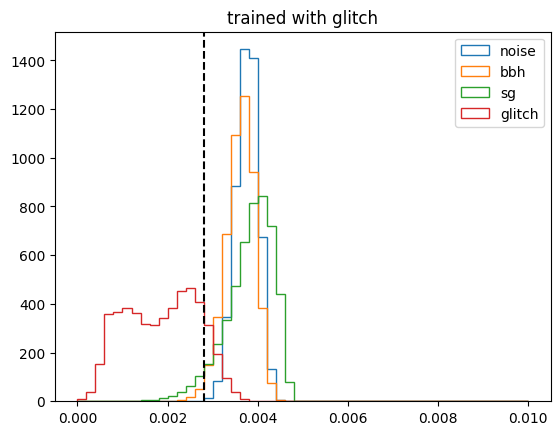

In [37]:
model = models["glitch"]

c0["glitch"] = 0.0028;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

In [34]:
bkg_filtered = bkg_fft
sg_filtered = sg_fft
bbh_filtered = bbh_fft

### Step 2: noise

In [38]:
currentStep = "noise"

In [39]:
previousStep = "glitch"
bkg_filtered = bkg_fft[np.var(bkg_fft-dcd_bkg, axis=1)>=c0[previousStep]]
sg_filtered = sg_fft[np.var(sg_fft-dcd_sg, axis=1)>=c0[previousStep]]
bbh_filtered = bbh_fft[np.var(bbh_fft-dcd_bbh, axis=1)>=c0[previousStep]]

In [40]:
bkg_filtered.shape

(69968, 200)

493.33928394317627


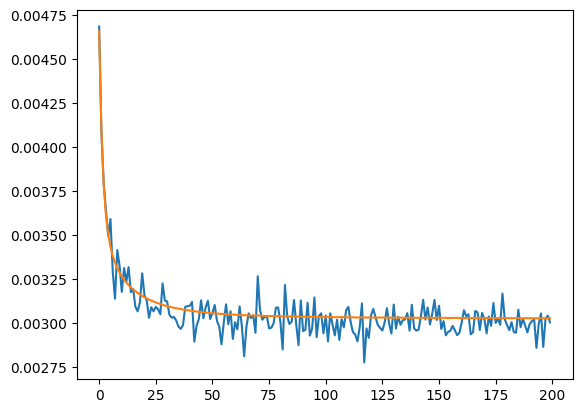

In [41]:
t0 = time.time()
dataset = bkg_filtered;

nTotal = len(dataset);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

X_train = dataset[:nTrain]
X_test = dataset[-nTest:]
X_validation = dataset[nTrain:-nTest]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros(epochs)
loss_validation = np.zeros(epochs)

wNorm = 0;

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = weighted_lossTrain.item()
    loss_validation[epoch] = val_loss
    
plt.plot(loss_train)
plt.plot(loss_validation)

print(time.time() - t0)

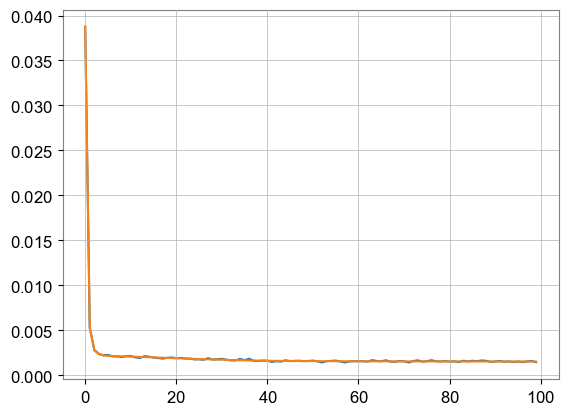

In [39]:
plt.plot(loss_train)
plt.plot(loss_validation)

In [43]:
autoencoder.cpu().eval();
models[currentStep] = copy.deepcopy(autoencoder);

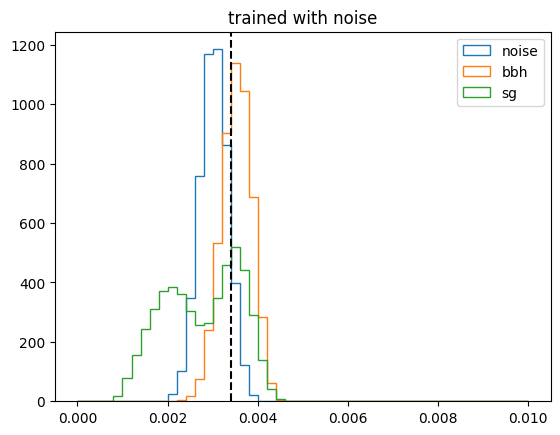

In [48]:
model = models[currentStep]

c0[currentStep] = 0.0034;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.legend()

### Step 3: BBH

In [49]:
c0

{'glitch': 0.0028, 'noise': 0.0034}

In [50]:
previousStep = currentStep
currentStep = "bbh"
print("from "+previousStep+" to "+currentStep)

from noise to bbh


In [51]:
# bkg_filtered = bkg_fft[np.var(bkg_fft-dcd_bkg, axis=1)>=c0[previousStep]]
sg_filtered = sg_filtered[np.var(sg_filtered-dcd_sg, axis=1)>=c0[previousStep]]
bbh_filtered = bbh_filtered[np.var(bbh_filtered-dcd_bbh, axis=1)>=c0[previousStep]]

In [55]:
bbh_filtered.shape

(44515, 200)

173.8483099937439


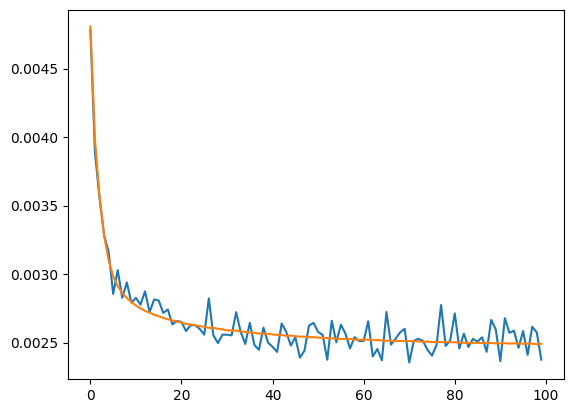

In [56]:
t0 = time.time()
dataset = bbh_filtered;

nTotal = len(dataset);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

X_train = dataset[:nTrain]
X_test = dataset[-nTest:]
X_validation = dataset[nTrain:-nTest]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros(epochs)
loss_validation = np.zeros(epochs)

wNorm = 0;

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = weighted_lossTrain.item()
    loss_validation[epoch] = val_loss
    
plt.plot(loss_train)
plt.plot(loss_validation)

print(time.time() - t0)

In [57]:
autoencoder.cpu().eval();
models[currentStep] = copy.deepcopy(autoencoder);

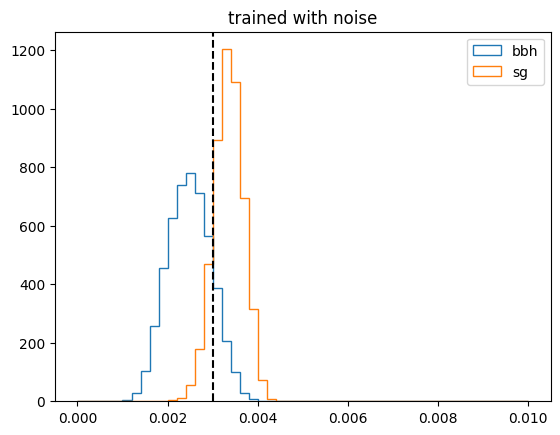

In [59]:
model = models[currentStep]

c0[currentStep] = 0.003;

# dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.legend()

### Step 4: SG

In [60]:
c0

{'glitch': 0.0028, 'noise': 0.0034, 'bbh': 0.003}

In [61]:
previousStep = "bbh"
currentStep = "sg"
print("from "+previousStep+" to "+currentStep)

from bbh to sg


In [62]:
# bkg_filtered = bkg_fft[np.var(bkg_fft-dcd_bkg, axis=1)>=c0[previousStep]]
sg_filtered = sg_filtered[np.var(sg_filtered-dcd_sg, axis=1)>=c0[previousStep]]
# bbh_filtered = bbh_filtered[np.var(bbh_filtered-dcd_bbh, axis=1)>=c0[previousStep]]

In [63]:
sg_filtered.shape

(16388, 200)

57.1900417804718


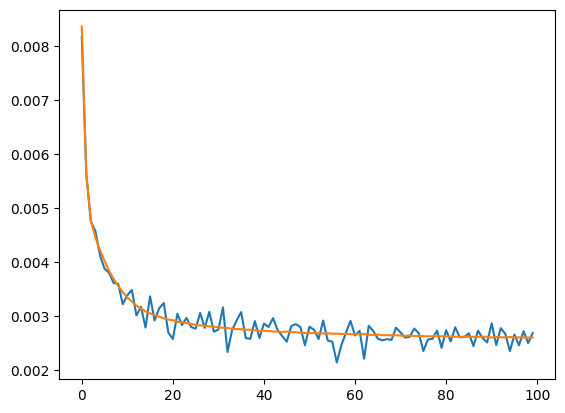

In [64]:
t0 = time.time()
dataset = sg_filtered;

nTotal = len(dataset);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

X_train = dataset[:nTrain]
X_test = dataset[-nTest:]
X_validation = dataset[nTrain:-nTest]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros(epochs)
loss_validation = np.zeros(epochs)

wNorm = 0;

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = weighted_lossTrain.item()
    loss_validation[epoch] = val_loss
    
plt.plot(loss_train)
plt.plot(loss_validation)

print(time.time() - t0)

In [65]:
autoencoder.cpu().eval();
models[currentStep] = copy.deepcopy(autoencoder);

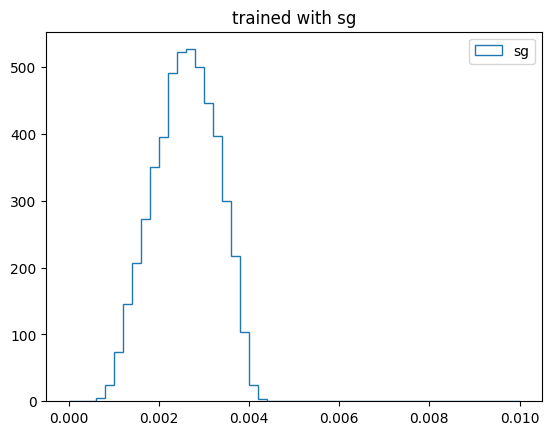

In [66]:
model = models[currentStep]

# c0[currentStep] = 0.0018;

# dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with sg")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.legend()

In [67]:
print(sum(p.numel() for p in autoencoder.parameters() if p.requires_grad))

16240


## streamline of the sequential training

In [15]:
version = "v2";

In [16]:
N_bkg = len(bkg_reserved_fft);
N_glitch = int(N_bkg/15);
N_bbh = int(N_bkg*2/15);
N_sg = int(N_bkg*2/15);

testset = np.empty((N_bkg+N_glitch+N_bbh+N_sg, len(bkg_reserved_fft[0])))

s = 0;
testset[s : s+N_glitch] = glitch_reserved_fft[np.random.permutation(len(glitch_reserved_fft))[:N_glitch]];
s += N_glitch;

testset[s : s+N_bkg] = bkg_reserved_fft[np.random.permutation(len(bkg_reserved_fft))[:N_bkg]];
s += N_bkg;

testset[s : s+N_bbh] = bbh_reserved_fft[np.random.permutation(len(bbh_reserved_fft))[:N_bbh]];
s += N_bbh;

testset[s : s+N_sg] = sg_reserved_fft[np.random.permutation(len(sg_reserved_fft))[:N_sg]];
s += N_sg;

correct_ans = np.concatenate(([0]*N_glitch, [1]*N_bkg, [2]*N_bbh, [3]*N_sg))

Nsample = {};
Nsample["glitch"] = N_glitch;
Nsample["noise"] = N_bkg;
Nsample["bbh"] = N_bbh;
Nsample["sg"] = N_sg

In [75]:
# epochs = 50;

# datatype2ind = {"glitch":0, "noise":1, "bbh":2, "sg":3};
# ind2datatype = {};
# for key in datatype2ind.keys():
#     ind2datatype[datatype2ind[key]] = key

In [23]:
epochs = 50;

# arranging the sequences of the series
ind2datatype = {0:"glitch", 1:"noise", 2:"bbh", 3:"sg"}
datatype2ind = {};
for key in ind2datatype.keys():
    datatype2ind[ind2datatype[key]] = key
    
torch.save(ind2datatype, "../Data_cached/SequentialTraining/sequence_"+version+".json")

In [17]:
Ncut = 3;
cutList = {};

max_glitch = 0.004;
min_glitch = 0.002;
cutList["glitch"] = np.linspace(min_glitch, max_glitch, Ncut);

max_bkg = 0.004;
min_bkg = 0.002;
cutList["noise"] = np.linspace(min_bkg, max_bkg, Ncut);

max_bbh = 0.004;
min_bbh = 0.002;
cutList["bbh"] = np.linspace(min_bbh, max_bbh, Ncut);

max_sg = 0.004;
min_sg = 0.001;
cutList["sg"] = np.linspace(min_sg, max_sg, Ncut);

In [18]:
torch.save(cutList, "../Data_cached/SequentialTraining/cut_"+version+".json")

In [203]:
models = torch.load('../Data_cached/SequentialTraining/trained_model211_v4.json')

In [19]:
models = {};
models["glitch"] = torch.load("../Model_cached/model_201-40-201_0_GWAK_set_glitchtrained.pt")
models["glitch"].cpu().eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=40, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=200, bias=True)
    (1): Tanh()
  )
)

In [20]:
def trainAE(dataset):
    
    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData, trainData)
    test_dataset = TensorDataset(testData, testData)
    validation_dataset = TensorDataset(validationData, validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()

    wNorm = 0;

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, (x, _) in enumerate(trainDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()
            
    return autoencoder.cpu().eval()

In [21]:
import itertools

In [24]:
cnt = 0;

ic = np.zeros(4, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
ic[3] = Ncut-1;

listResult = {};
listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1], ic[2] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):

    data_filtered = {};
    data_filtered["noise"] = bkg_fft;
    data_filtered["bbh"] = bbh_fft;
    data_filtered["sg"] = sg_fft;
    
    for iPrev in range(3):
        previousStep = ind2datatype[iPrev];
        modelPrev = models[previousStep];
        
        # filter the data
        for j in range(iPrev+1, 4):
            dt = ind2datatype[j];
            dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
            data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
            
        currentStep = ind2datatype[iPrev+1];
        model = trainAE(data_filtered[currentStep]);
        models[currentStep] = model;
        
    torch.save(models, "../Data_cached/SequentialTraining/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
    
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    for datatype in list_datatype:
        dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
        err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
    not_select = np.array([True]*len(testset));

    for iStep in range(len(list_datatype)):
        datatype = ind2datatype[iStep];
        ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
        ans[ind_pass] = iStep;
        not_select[ind_pass] = False;
        
    ans[not_select] = -1;
    
    listResult["cut"][cnt] = ic;
    listResult["ans"][cnt] = ans;
    
    acc = np.zeros(len(ind2datatype));
    
    for i in range(len(ind2datatype)):
        acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
    listResult["accuracy_4"][cnt] = acc;
    
    listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
                                     np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    
    cnt += 1;
    print(cnt)
    
listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
torch.save(listResult, "../Data_cached/SequentialTraining/training_performance_"+version+".json")

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_44420\633020723.py:66: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]),
C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_44420\633020723.py:67: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [25]:
foo = np.array([ [0.01*A, np.sum(np.all(listResult["accuracy_4"] >= 0.01*A, axis=1))/len(listResult["accuracy_4"])] for A in range(101)])

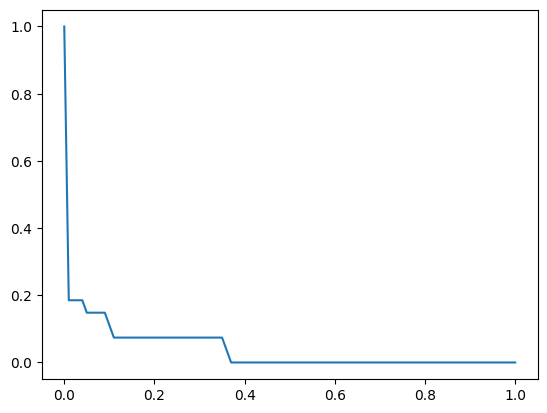

In [26]:
plt.plot(foo[:, 0], foo[:, 1])

In [135]:
cutList["glitch"]

array([0.001 , 0.0014, 0.0018, 0.0022, 0.0026])

In [29]:
listResult["accuracy_4"][np.argwhere(np.all(listResult["accuracy_4"]>0.3, axis=1)).flatten()]

array([[0.58      , 0.42013333, 0.7425    , 0.364     ],
       [0.9285    , 0.4115    , 0.722     , 0.3525    ]])

In [133]:
listResult["cut"][np.argwhere(np.all(listResult["accuracy_4"]>0.6, axis=1)).flatten()]

array([[1, 2, 3, 4],
       [2, 2, 3, 4]])

# 4-AE trained with different data

In [54]:
realglitch = np.load("../data/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"]
perm = np.random.permutation(len(realglitch))
glitch = realglitch[perm][:int(len(perm)*0.7)]
glitch_reserved = realglitch[perm][int(len(perm)*0.7):]
glitch = glitch/np.linalg.norm([glitch], axis=2).T
glitch_reserved = glitch_reserved/np.linalg.norm([glitch_reserved], axis=2).T
np.savetxt("../data/perm_4ae_glitch.dat", perm)

In [6]:
renorm_factor = 20;

realbkg = np.load("../data/Datasets/background.npz")['data'] / renorm_factor;
realbbh = np.load("../data/Datasets/bbh_for_challenge.npy") / renorm_factor;

realsg = np.load("../data/Datasets/sglf_for_challenge.npy") / renorm_factor;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch = np.load("../data/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"]

perm = np.random.permutation(len(realbkg))
bkg = realbkg[perm, 0][:int(len(perm)*0.7)]
bkg_reserved = realbkg[perm, 0][int(len(perm)*0.7):]
bkg = bkg/np.linalg.norm([bkg], axis=2).T
bkg_reserved = bkg_reserved/np.linalg.norm([bkg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bkg.dat", perm)

perm = np.random.permutation(len(realbbh))
bbh = realbbh[perm, 0][:int(len(perm)*0.7)]
bbh_reserved = realbbh[perm, 0][int(len(perm)*0.7):]
bbh = bbh/np.linalg.norm([bbh], axis=2).T
bbh_reserved = bbh_reserved/np.linalg.norm([bbh_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bbh.dat", perm)

perm = np.random.permutation(len(realsg))
sg = realsg[perm, 0][:int(len(perm)*0.7)]
sg_reserved = realsg[perm, 0][int(len(perm)*0.7):]
sg = sg/np.linalg.norm([sg], axis=2).T
sg_reserved = sg_reserved/np.linalg.norm([sg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_sg.dat", perm)

perm = np.random.permutation(len(realglitch))
glitch = realglitch[perm][:int(len(perm)*0.7)]
glitch_reserved = realglitch[perm][int(len(perm)*0.7):]
glitch = glitch/np.linalg.norm([glitch], axis=2).T
glitch_reserved = glitch_reserved/np.linalg.norm([glitch_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_glitch.dat", perm)

In [7]:
bkg_fft = abs(np.fft.rfft(bkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T

bbh_fft = abs(np.fft.rfft(bbh))
bbh_fft = bbh_fft/np.linalg.norm([bbh_fft], axis=2).T

sg_fft = abs(np.fft.rfft(sg))
sg_fft = sg_fft/np.linalg.norm([sg_fft], axis=2).T

glitch_fft = abs(np.fft.rfft(glitch))
glitch_fft = glitch_fft/np.linalg.norm([glitch_fft], axis=2).T

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

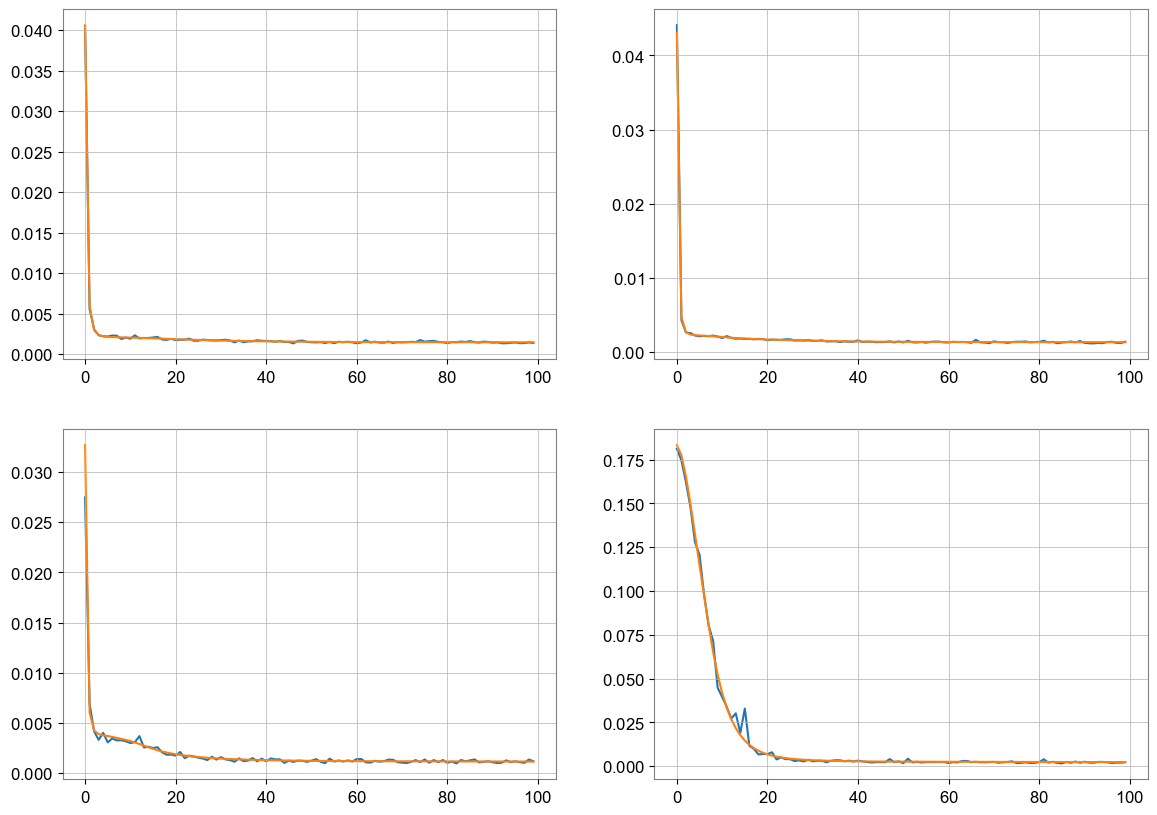

In [27]:
_, ax = plt.subplots(2, 2, figsize=(14, 10))

for index, dataset in enumerate([bkg_fft, bbh_fft, sg_fft, glitch_fft]):
    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData, trainData)
    test_dataset = TensorDataset(testData, testData)
    validation_dataset = TensorDataset(validationData, validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    loss_train = np.zeros((epochs, 1))
    loss_validation = np.zeros((epochs, 1))

    wNorm = 0;

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, (x, _) in enumerate(trainDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            # weighted_lossTrain = loss_func(decoded, x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            # output_norm = torch.norm(decoded[:, :100], dim=1) 
            # penalty_term = torch.mean((output_norm - 1) ** 2) 
            # weighted_lossTrain = lossTrain + coef_delta * penalty_term

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()

        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, _) in enumerate(validationDataLoader):
                x = x.cuda()
                encoded, decoded = autoencoder(x)
                lossVal_overall = loss_func(decoded, x)
                lossVal = lossVal_overall
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch,0] = weighted_lossTrain.item()
        loss_validation[epoch,0] = val_loss
    #     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

    torch.save(autoencoder.cuda(), "../data/4ae_%d.pt" % (index,))
    ax[index//2, index%2].plot(loss_train[:, 0])
    ax[index//2, index%2].plot(loss_validation[:, 0])
    
plt.show()

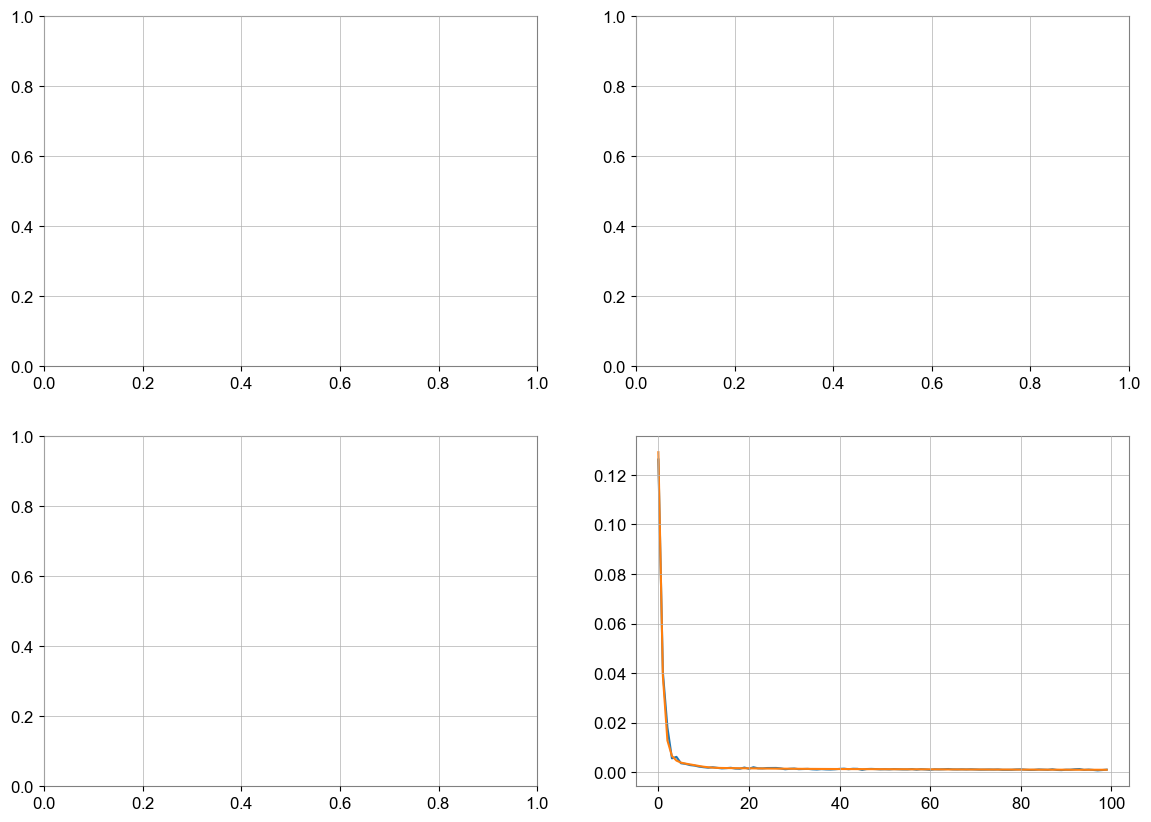

In [59]:
_, ax = plt.subplots(2, 2, figsize=(14, 10))

for index, dataset in enumerate([bkg_fft, bbh_fft, sg_fft, glitch_fft]):
    if index<3:
        continue;
    
    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData, trainData)
    test_dataset = TensorDataset(testData, testData)
    validation_dataset = TensorDataset(validationData, validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    loss_train = np.zeros((epochs, 1))
    loss_validation = np.zeros((epochs, 1))

    wNorm = 0;

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, (x, _) in enumerate(trainDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            # weighted_lossTrain = loss_func(decoded, x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            # output_norm = torch.norm(decoded[:, :100], dim=1) 
            # penalty_term = torch.mean((output_norm - 1) ** 2) 
            # weighted_lossTrain = lossTrain + coef_delta * penalty_term

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()

        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, _) in enumerate(validationDataLoader):
                x = x.cuda()
                encoded, decoded = autoencoder(x)
                lossVal_overall = loss_func(decoded, x)
                lossVal = lossVal_overall
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch,0] = weighted_lossTrain.item()
        loss_validation[epoch,0] = val_loss
    #     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

    torch.save(autoencoder.cuda(), "../data/4ae_%d.pt" % (index,))
    ax[index//2, index%2].plot(loss_train[:, 0])
    ax[index//2, index%2].plot(loss_validation[:, 0])
    
plt.show()

(0.0, 0.01)

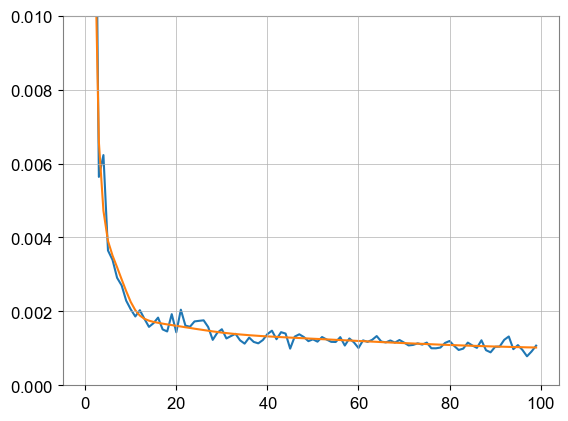

In [62]:
plt.plot(loss_train[:, 0])
plt.plot(loss_validation[:, 0])
plt.ylim(0, 0.01)

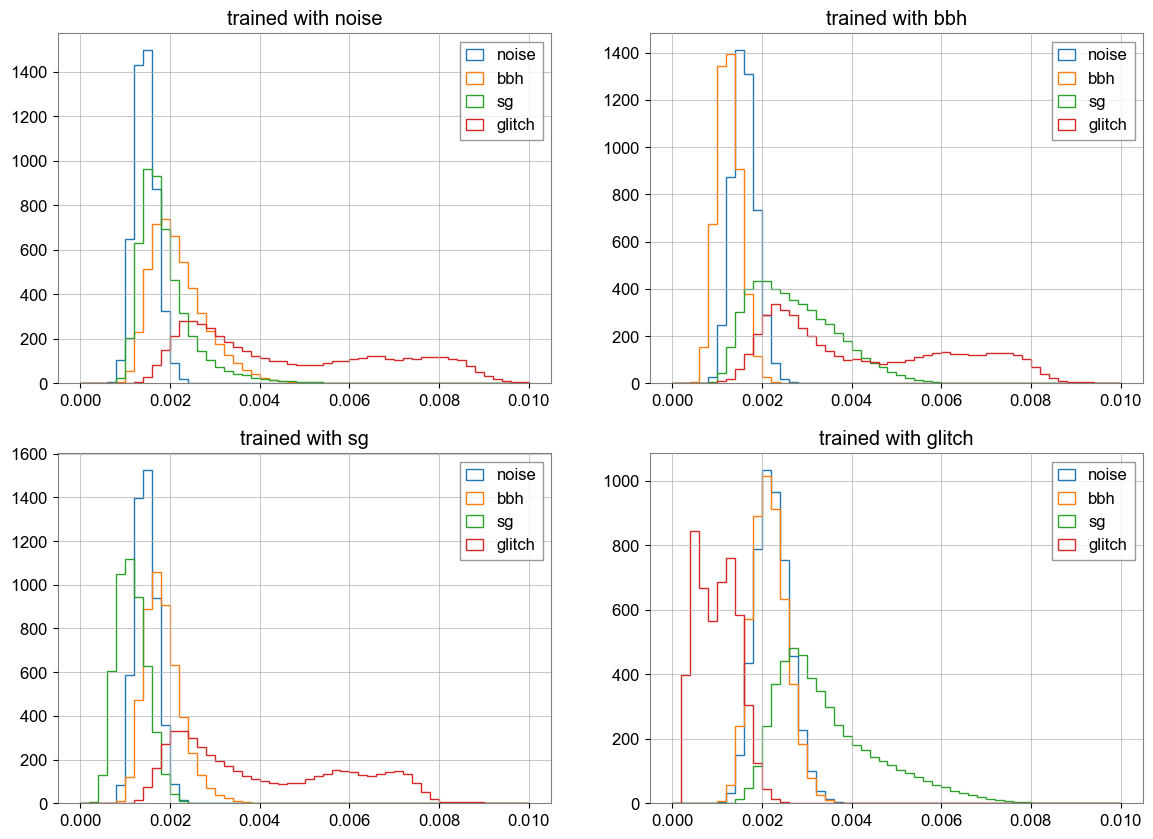

In [10]:
_, ax = plt.subplots(2, 2, figsize=(14, 10))

for index, datatype in enumerate(["noise", "bbh", "sg", "glitch"]):
    model = torch.load("../data/4ae_%d.pt" % (index,))
    model = model.cpu()
    model.eval()

    dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
    dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
    dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
    dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()
    
    foo = ax[index//2, index%2].hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    foo = ax[index//2, index%2].hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    foo = ax[index//2, index%2].hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    foo = ax[index//2, index%2].hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    ax[index//2, index%2].set_title("trained with "+datatype)
    ax[index//2, index%2].legend()

In [48]:
list_datatype = ["noise", "bbh", "sg", "glitch"];

In [20]:
Ncut = 10;

max_glitch = 0.0026;
min_glitch = 0.001;
cutList_glitch = np.linspace(min_glitch, max_glitch, Ncut);

max_sg = 0.0024;
min_sg = 0.0008;
cutList_sg = np.linspace(min_sg, max_sg, Ncut);

max_bbh = 0.0024;
min_bbh = 0.0008;
cutList_bbh = np.linspace(min_bbh, max_bbh, Ncut);

max_bkg = 0.0024;
min_bkg = 0.0006;
cutList_bkg = np.linspace(min_bkg, max_bkg, Ncut);

In [62]:
cutList = {};

cutList["glitch"] = cutList_glitch;
cutList["noise"] = cutList_bkg;
cutList["bbh"] = cutList_bbh;
cutList["sg"] = cutList_sg;

In [35]:
# preparing the dataset
# temporarily using 75% noise, 5% glitch, 10% bbh and 10% sg

perm = np.loadtxt("../data/perm_4ae_bkg.dat").astype("int");
bkg_reserved = realbkg[perm, 0][int(len(perm)*0.7):]
bkg_reserved = bkg_reserved/np.linalg.norm([bkg_reserved], axis=2).T
bkg_reserved_fft = abs(np.fft.rfft(bkg_reserved))
bkg_reserved_fft = bkg_reserved_fft/np.linalg.norm([bkg_reserved_fft], axis=2).T

perm = np.loadtxt("../data/perm_4ae_bbh.dat").astype("int");
bbh_reserved = realbbh[perm, 0][int(len(perm)*0.7):]
bbh_reserved = bbh_reserved/np.linalg.norm([bbh_reserved], axis=2).T
bbh_reserved_fft = abs(np.fft.rfft(bbh_reserved))
bbh_reserved_fft = bbh_reserved_fft/np.linalg.norm([bbh_reserved_fft], axis=2).T

perm = np.loadtxt("../data/perm_4ae_sg.dat").astype("int");
sg_reserved = realsg[perm, 0][int(len(perm)*0.7):]
sg_reserved = sg_reserved/np.linalg.norm([sg_reserved], axis=2).T
sg_reserved_fft = abs(np.fft.rfft(sg_reserved))
sg_reserved_fft = sg_reserved_fft/np.linalg.norm([sg_reserved_fft], axis=2).T

perm = np.loadtxt("../data/perm_4ae_glitch.dat").astype("int");
glitch_reserved = realglitch[perm][int(len(perm)*0.7):]
glitch_reserved = glitch_reserved/np.linalg.norm([glitch_reserved], axis=2).T
glitch_reserved_fft = abs(np.fft.rfft(glitch_reserved))
glitch_reserved_fft = glitch_reserved_fft/np.linalg.norm([glitch_reserved_fft], axis=2).T

N_bkg = len(bkg_reserved_fft);
N_glitch = int(N_bkg/25);
N_bbh = int(N_bkg*2/15);
N_sg = int(N_bkg*2/15);

testset = np.empty((N_bkg+N_glitch+N_bbh+N_sg, len(bkg_reserved_fft[0])))

s = 0;
testset[s : s+N_glitch] = glitch_reserved_fft[np.random.permutation(len(glitch_reserved_fft))[:N_glitch]];
s += N_glitch;

testset[s : s+N_bkg] = bkg_reserved_fft[np.random.permutation(len(bkg_reserved_fft))[:N_bkg]];
s += N_bkg;

testset[s : s+N_bbh] = bbh_reserved_fft[np.random.permutation(len(bbh_reserved_fft))[:N_bbh]];
s += N_bbh;

testset[s : s+N_sg] = sg_reserved_fft[np.random.permutation(len(sg_reserved_fft))[:N_sg]];
s += N_sg;

cut_points = np.cumsum([0, N_glitch, N_bkg, N_bbh, N_sg])

In [88]:
correct_ans = np.concatenate(([0]*N_glitch, [1]*N_bkg, [2]*N_bbh, [3]*N_sg))

In [41]:
models = {};
for index, datatype in enumerate(["noise", "bbh", "sg", "glitch"]): # !!!do NOT change the sequence!!!
    model = torch.load("../data/4ae_%d.pt" % (index,))
    model = model.cpu()
    model.eval()
    models[datatype] = model

In [38]:
import itertools

In [78]:
# try the series glitch-noise-bbh-sg-unknown
# the indexing below is determined by the sequence of the series network
datatype2ind = {"glitch":0, "noise":1, "bbh":2, "sg":3};
ind2datatype = {};
for key in datatype2ind.keys():
    ind2datatype[datatype2ind[key]] = key

t0 = time.time()

listResult = {};
listResult["cut"] = np.empty((Ncut**len(list_datatype), len(list_datatype)));
listResult["ans"] = np.empty((Ncut**len(list_datatype), len(testset)), dtype="int");

cnt = 0;

ic = np.zeros(4, dtype="int")

for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    for datatype in list_datatype:
        dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
        err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
    not_select = np.array([True]*len(testset));

    for i_datatype in range(len(list_datatype)):
        datatype = ind2datatype[i_datatype];
        ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[i_datatype]]);
        ans[ind_pass] = i_datatype;
        not_select[ind_pass] = False;
        
    ans[not_select] = -1;
    
    listResult["cut"][cnt] = np.array([cutList[ind2datatype[i]][ic[i]] for i in range(len(list_datatype))])
    listResult["ans"][cnt] = ans;
    cnt += 1;
    
    if (cnt+1)%100==0:
        print(time.time() - t0)
        t0 = time.time()

10.7540442943573
10.737537145614624
10.84455418586731
10.51443862915039
10.57808804512024
10.536635637283325
10.561345100402832
10.515532970428467
10.545176029205322
10.469477415084839
10.544865608215332
10.536304950714111
10.528775930404663
10.590201139450073
10.569525241851807
10.554279565811157
10.523267984390259
10.640617370605469
10.482626914978027
10.53813886642456
10.542979717254639
10.504028558731079
10.569152116775513
10.544652700424194
10.57406234741211
10.591615438461304
10.573631763458252
10.55340576171875
10.543986320495605
10.536674976348877
10.592308521270752
10.507396936416626
10.478560209274292
10.50638198852539
10.49535059928894
10.45194387435913
10.600637197494507
10.472503185272217
10.464442253112793
10.499344825744629
10.567439794540405
10.485870599746704
10.55011534690857
10.541829347610474
10.51195764541626
10.604342222213745
10.511751890182495
10.477017164230347
10.51522970199585
10.48652458190918
10.481410503387451
10.561721086502075
10.553131341934204
10.50059

In [83]:
listResult["ans"].shape

(10000, 39200)

In [94]:
listResult["accuracy_4"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);

In [167]:
np.logical_and(listResult["ans"]>-1, listResult["ans"]<2)==np.logical_and(correct_ans>-1, correct_ans<2)

array([[False,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True, False],
       [ True,  True,  True, ..., False,  True, False],
       [ True,  True,  True, ..., False,  True, False]])

In [168]:
listResult["accuracy_2"] = np.sum(np.logical_and(listResult["ans"]>-1, listResult["ans"]<2)==np.logical_and(correct_ans>-1, correct_ans<2), axis=1)/len(testset);

In [169]:
listResult["accuracy_bkg"] = np.sum(np.logical_and(listResult["ans"]>-1, listResult["ans"]<2)[:, np.logical_and(correct_ans>-1, correct_ans<2)], axis=1)/(N_glitch+N_bkg);
listResult["accuracy_sig"] = np.sum(np.logical_or(listResult["ans"]<0, listResult["ans"]>=2)[:, np.logical_or(correct_ans<0, correct_ans>=2)], axis=1)/(N_sg+N_bbh);

In [175]:
max(listResult["accuracy_2"])

0.8616836734693878

In [109]:
max(listResult["accuracy_4"])

0.8504336734693878

In [176]:
max(listResult["accuracy_bkg"])

0.9996153846153846

In [177]:
max(listResult["accuracy_sig"])

0.99975

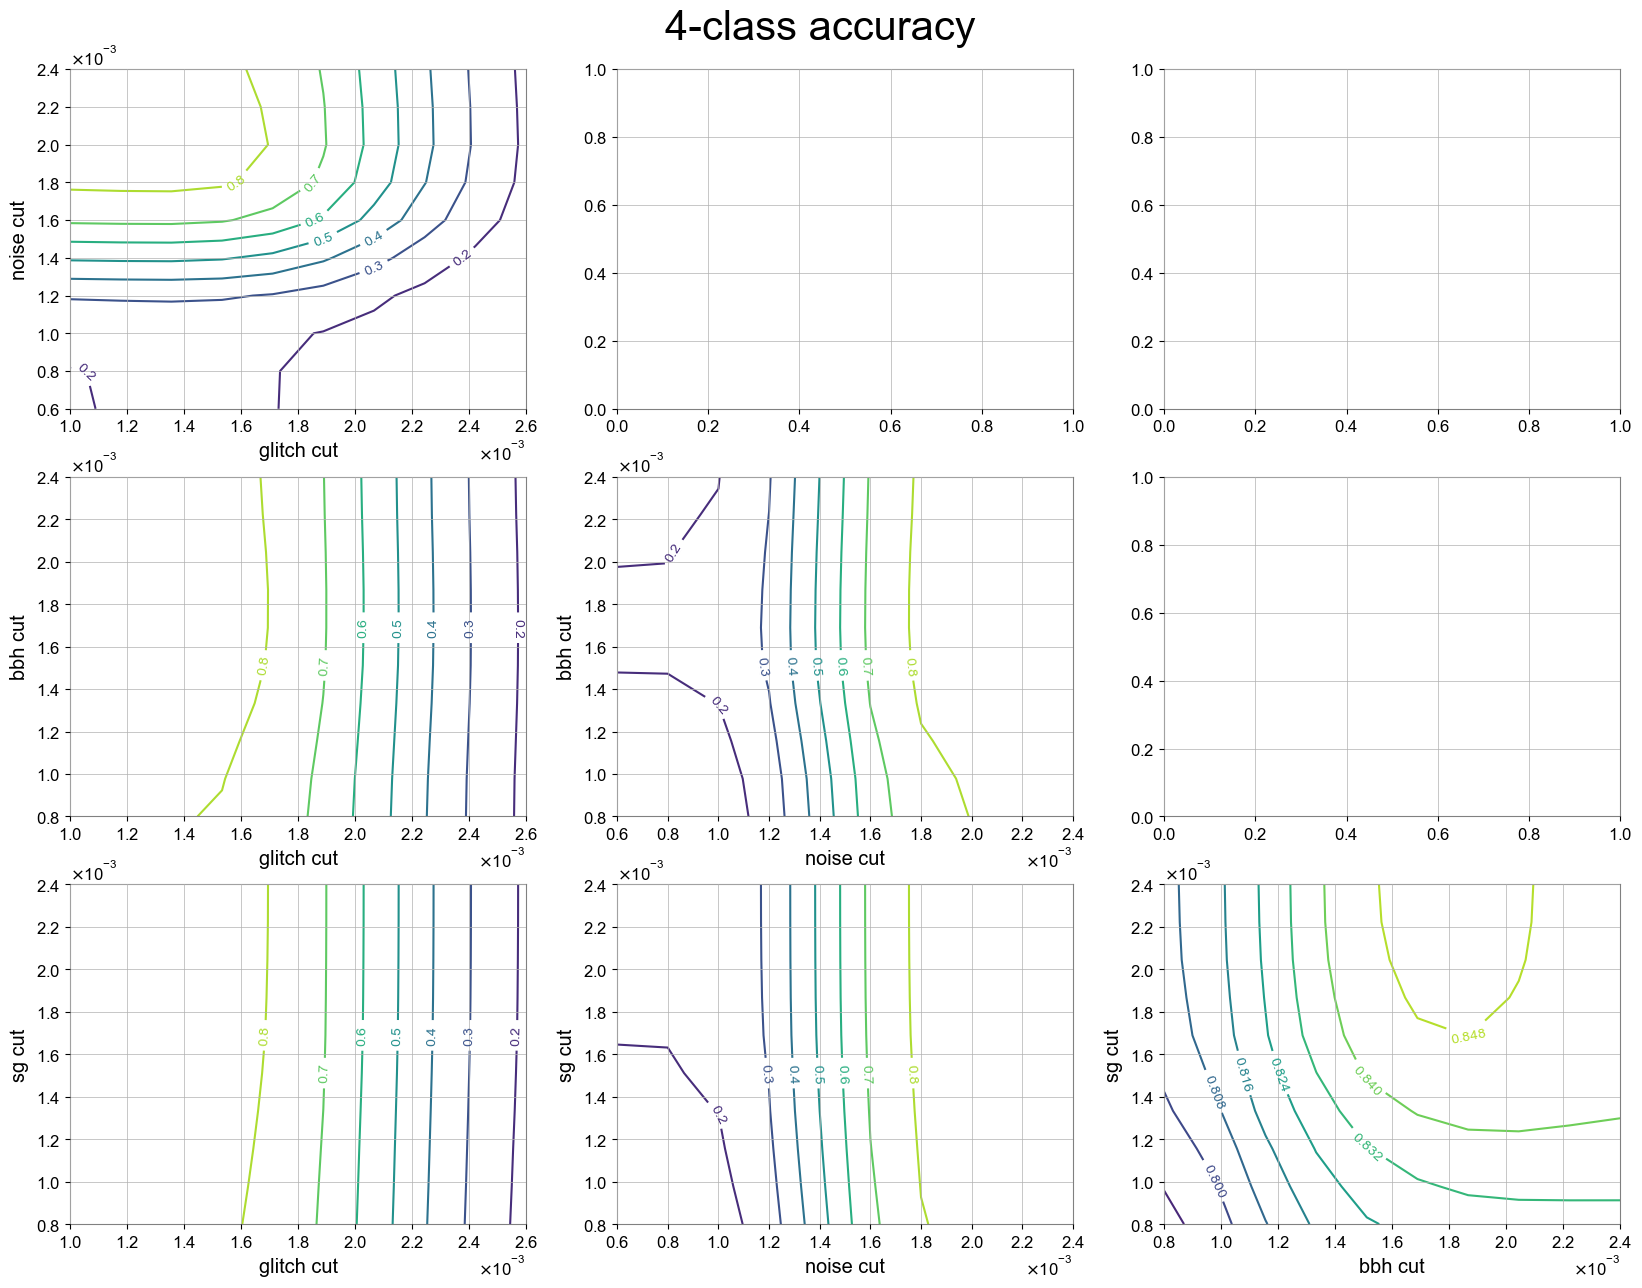

In [189]:
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
for i in range(len(list_datatype)):
    for j in range(i+1, len(list_datatype)):
        X, Y = np.meshgrid(cutList[ind2datatype[i]], cutList[ind2datatype[j]])
        Z = np.reshape([max(listResult["accuracy_4"][np.all(listResult["cut"][:, [i,j]]==cut, axis=1)]) for cut in np.array([X.flatten(), Y.flatten()]).T], (len(Y), len(X)))
        CS = ax[j-1, i].contour(X, Y, Z)

        ax[j-1,i].clabel(CS, inline=True, fontsize=10)
        ax[j-1,i].set_xlabel(ind2datatype[i]+" cut")
        ax[j-1,i].set_ylabel(ind2datatype[j]+" cut")

fig.suptitle("4-class accuracy", fontsize=30, y=0.92)
plt.savefig("../results/contours_4-class.pdf")

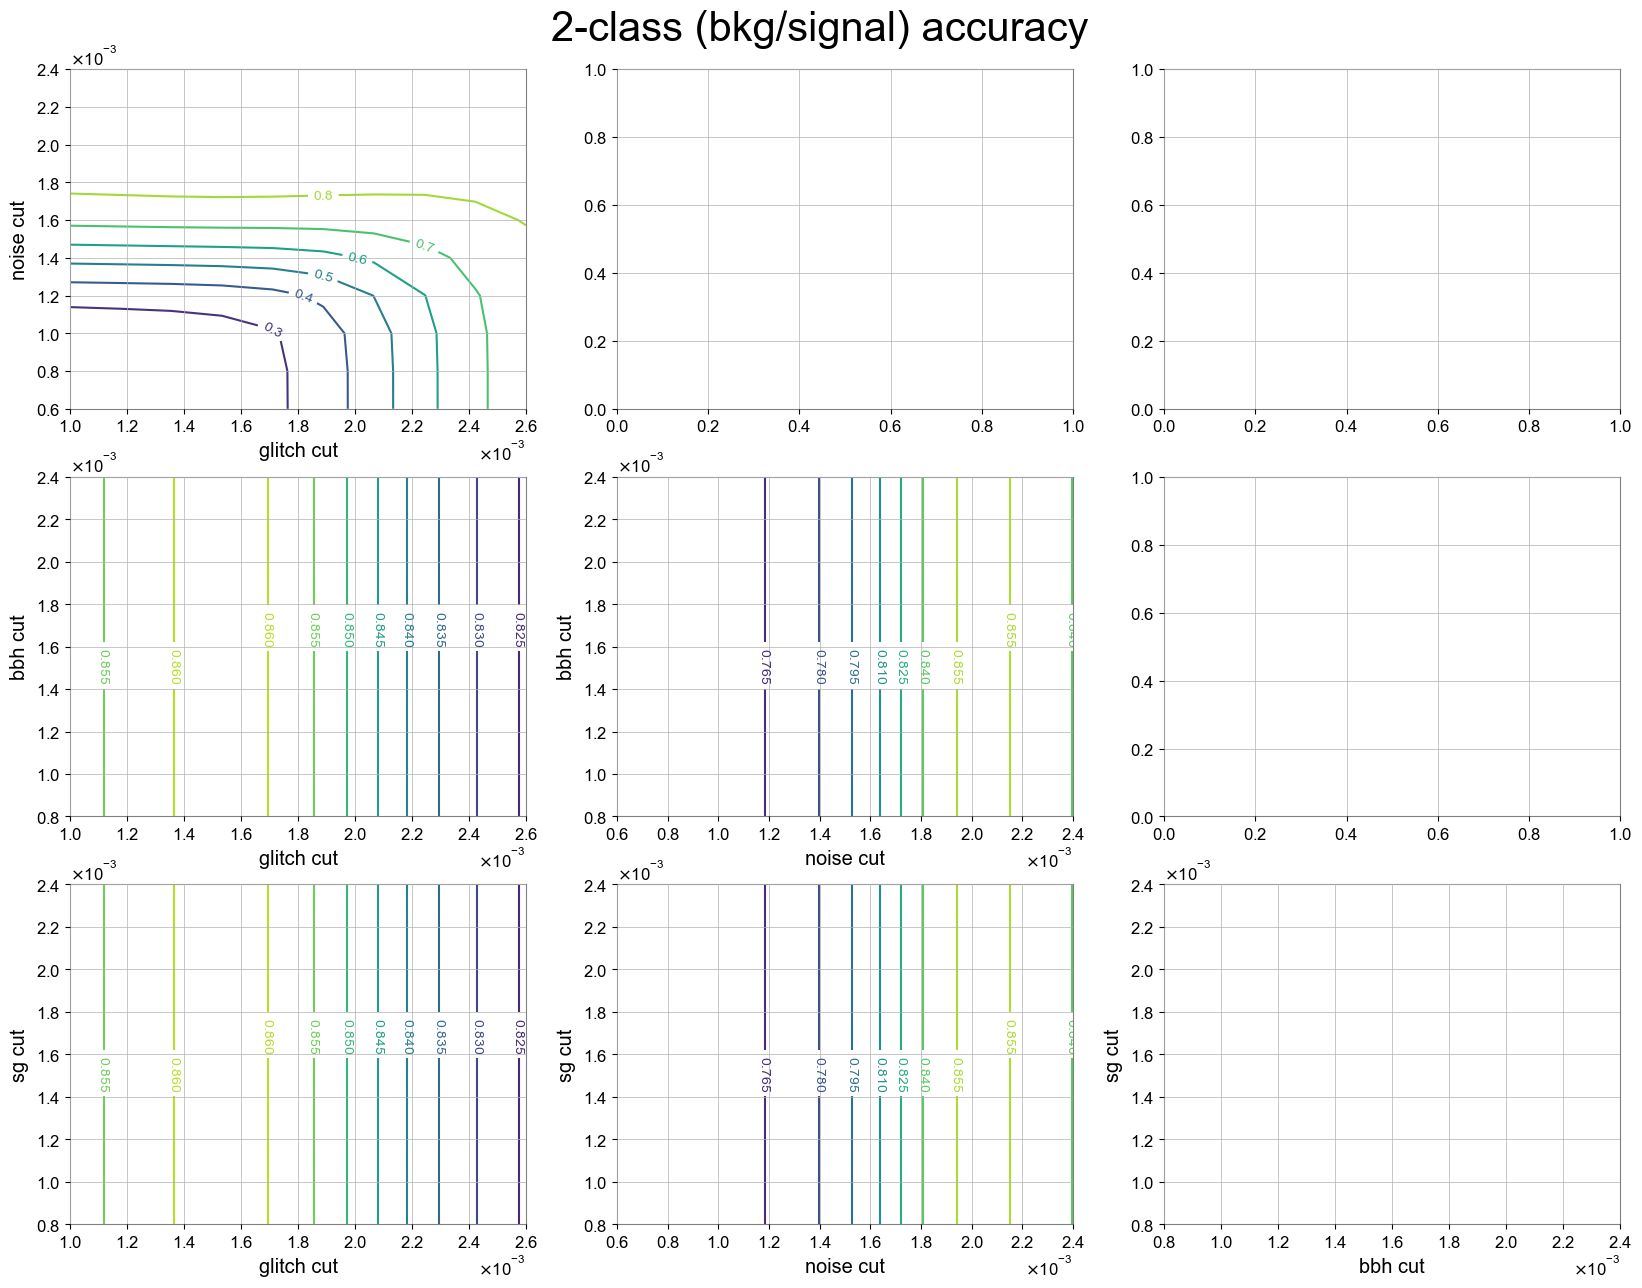

In [190]:
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
for i in range(len(list_datatype)):
    for j in range(i+1, len(list_datatype)):
        X, Y = np.meshgrid(cutList[ind2datatype[i]], cutList[ind2datatype[j]])
        Z = np.reshape([max(listResult["accuracy_2"][np.all(listResult["cut"][:, [i,j]]==cut, axis=1)]) for cut in np.array([X.flatten(), Y.flatten()]).T], (len(Y), len(X)))
        CS = ax[j-1, i].contour(X, Y, Z)

        ax[j-1,i].clabel(CS, inline=True, fontsize=10)
        ax[j-1,i].set_xlabel(ind2datatype[i]+" cut")
        ax[j-1,i].set_ylabel(ind2datatype[j]+" cut")
        
fig.suptitle("2-class (bkg/signal) accuracy", fontsize=30, y=0.92)
plt.savefig("../results/contours_2-class.pdf")

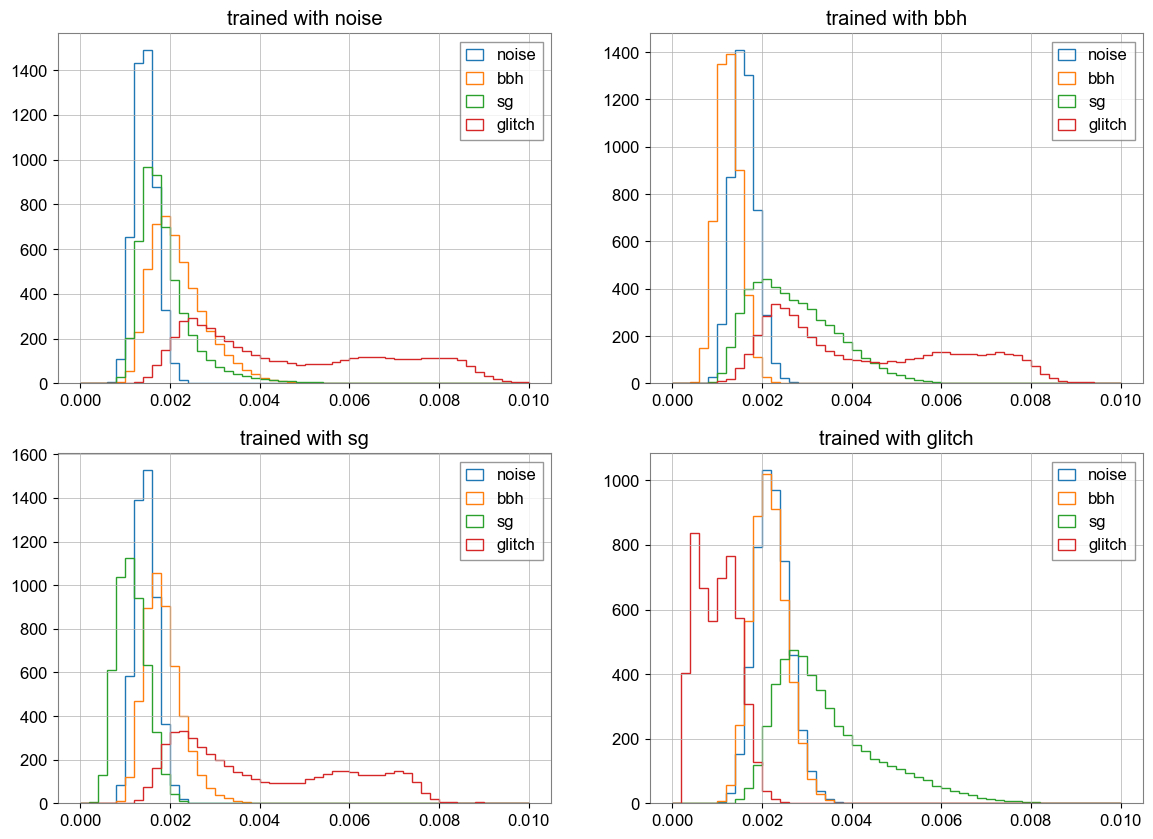

In [60]:
_, ax = plt.subplots(2, 2, figsize=(14, 10))

for index, datatype in enumerate(["noise", "bbh", "sg", "glitch"]):
    model = torch.load("../data/4ae_%d.pt" % (index,))
    model = model.cpu()
    model.eval()

    dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
    dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
    dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
    dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()
    
    foo = ax[index//2, index%2].hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    foo = ax[index//2, index%2].hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    foo = ax[index//2, index%2].hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    foo = ax[index//2, index%2].hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    ax[index//2, index%2].set_title("trained with "+datatype)
    ax[index//2, index%2].legend()

# Below trains with the bkg on detector 1

In [93]:
bkg_raw = np.load("../data/Datasets/background.npz")['data'][:, 1, :];
norm = np.transpose([np.linalg.norm(bkg_raw, axis = 1)]);
bkg = np.hstack((bkg_raw/norm, norm / renorm_factor))

nTotal = len(bkg);
# nTotal = len(fake_bkg);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

perm = np.random.permutation(nTotal)

X_train = bkg[perm[:nTrain]]
X_test = bkg[perm[-nTest:]]
X_validation = bkg[perm[nTrain:-nTest]]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

for wNorm in [0]:#[0, 0.1, 1, 10, 100, 1000]:

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    loss_train = np.zeros((epochs, 1))
    loss_validation = np.zeros((epochs, 1))
    t0 = time.time()

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, (x, _) in enumerate(trainDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            # weighted_lossTrain = loss_func(decoded, x)
            loss_overall = loss_func(decoded, x)
            loss_norm = loss_func(decoded[:, -1], x[:, -1])
            weighted_lossTrain = loss_overall + loss_norm * wNorm

            # output_norm = torch.norm(decoded[:, :100], dim=1) 
            # penalty_term = torch.mean((output_norm - 1) ** 2) 
            # weighted_lossTrain = lossTrain + coef_delta * penalty_term

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()

        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, _) in enumerate(validationDataLoader):
                x = x.cuda()
                encoded, decoded = autoencoder(x)
                lossVal_overall = loss_func(decoded, x)
                lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
                lossVal = lossVal_overall + lossVal_norm * wNorm
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch,0] = weighted_lossTrain.item()
        loss_validation[epoch,0] = val_loss
    #     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

    print(time.time() - t0)
    print("Norm weight %f done training" % (wNorm,))
    print(autoencoder.cuda())
    torch.save(autoencoder.cuda(), "../data/model_201-40_det_1_weight_%f_renorm.pt" % (wNorm,))
    np.savetxt("../data/loss_201-40_det_1_weight_%f_renorm.dat" % (wNorm,), [loss_train[:, 0], loss_validation[:, 0]])
    
np.savetxt("../data/perm_det_1_renorm.dat", perm)

1120.8076400756836
Norm weight 0.000000 done training
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=201, out_features=40, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=201, bias=True)
    (1): Tanh()
  )
)


# To avoid overfitting, try 101-dim (result: qualitatively similar)

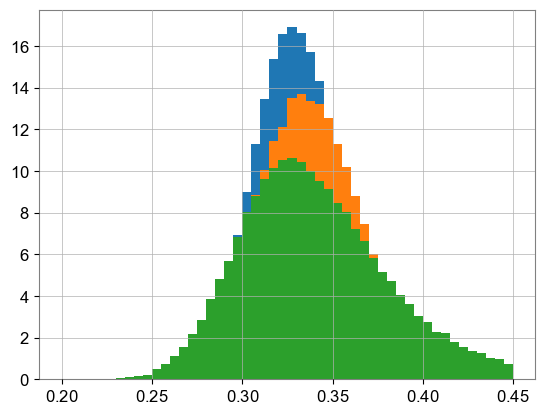

In [17]:
foo = plt.hist(norm_fakebkg, bins=50, range=(0.2, 0.45), density=True)

renorm_factor = 20;

bkg_raw = np.load("../data/Datasets/background.npz")['data'][:, 0, 50:150];
bbh_raw = np.load("../data/Datasets/bbh_for_challenge.npy")[:, 0, 50:150];

norm = np.transpose([np.linalg.norm(bkg_raw, axis = 1)]);
bkg = np.hstack((bkg_raw/norm, norm / renorm_factor))

foo = plt.hist(norm/renorm_factor, bins=50, range=(0.2, 0.45), density=True)

norm = np.transpose([np.linalg.norm(bbh_raw, axis = 1)]);
bbh = np.hstack((bbh_raw/norm, norm / renorm_factor))

foo = plt.hist(norm/renorm_factor, bins=50, range=(0.2, 0.45), density=True)

nTotal = len(bkg);
# nTotal = len(fake_bkg);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

perm = np.random.permutation(nTotal)

X_train = bkg[perm[:nTrain]]
X_test = bkg[perm[-nTest:]]
X_validation = bkg[perm[nTrain:-nTest]]

# X_train = fake_bkg[perm[:nTrain]]
# X_test = fake_bkg[perm[-nTest:]]
# X_validation = fake_bkg[perm[nTrain:-nTest]]

## test 101-20-101

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [18]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

wNorm = 0;

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))
t0 = time.time()

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        loss_norm = loss_func(decoded[:, -1], x[:, -1])
        weighted_lossTrain = loss_overall + loss_norm * wNorm

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall + lossVal_norm * wNorm
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
#     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

print(time.time() - t0)

# print("Norm weight %f done training" % (wNorm,))
# print(autoencoder.cuda())
# torch.save(autoencoder.cuda(), "../data/model_201-40_weight_%f_fakebkg.pt" % (wNorm,))
# np.savetxt("../data/loss_201-40_weight_%f_fakebkg.dat" % (wNorm,), [loss_train[:, 0], loss_validation[:, 0]])
    
# np.savetxt("../data/perm_fakebkg.dat", perm)

561.9412305355072


In [22]:
ae_cpu = autoencoder.to('cpu')

In [27]:
bkg.shape

(100000, 101)

In [28]:
decoded_bkg.shape

torch.Size([100000, 101])

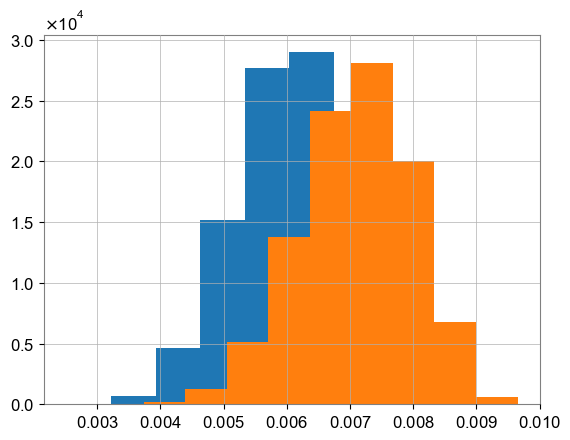

In [29]:
autoencoder.eval()

_, decoded_bkg = autoencoder(torch.FloatTensor(bkg))
_, decoded_bbh = autoencoder(torch.FloatTensor(bbh))

foo = plt.hist(np.linalg.norm(decoded_bkg.double().detach().numpy()[:, :100] - bkg[:, :100], axis = 1)**2 / 100)
foo = plt.hist(np.linalg.norm(decoded_bbh.double().detach().numpy()[:, :100] - bbh[:, :100], axis = 1)**2 / 100)

plt.show()

## try 20, 40, 60 for the latent space

In [75]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

wNorm = 10;

decoded_bkg = np.empty((3,)+bkg.shape)
decoded_bbh = np.empty((3,)+bbh.shape)

list_nLS = [20, 40, 60]

for i in range(3):
    nLatentSpace = list_nLS[i];
    
    class AEtest(nn.Module):
        def __init__(self):
            super(AEtest, self).__init__()
            self.encoder = nn.Sequential(
                nn.Linear(101, nLatentSpace),
                nn.ReLU()
            )
            self.decoder = nn.Sequential(
                nn.Linear(nLatentSpace, 101),
                nn.Tanh()
            )

        def forward(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return encoded, decoded
    
    autoencoder = AEtest().cuda()
    print(autoencoder)

#     autoencoder = listAE[iAE];
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    loss_train = np.zeros((epochs, 1))
    loss_validation = np.zeros((epochs, 1))
    
    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, (x, _) in enumerate(trainDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            # weighted_lossTrain = loss_func(decoded, x)
            loss_overall = loss_func(decoded, x)
            loss_norm = loss_func(decoded[:, -1], x[:, -1])
            weighted_lossTrain = loss_overall + loss_norm * wNorm

            # output_norm = torch.norm(decoded[:, :100], dim=1) 
            # penalty_term = torch.mean((output_norm - 1) ** 2) 
            # weighted_lossTrain = lossTrain + coef_delta * penalty_term

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()

        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, _) in enumerate(validationDataLoader):
                x = x.cuda()
                encoded, decoded = autoencoder(x)
                lossVal_overall = loss_func(decoded, x)
                lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
                lossVal = lossVal_overall + lossVal_norm * wNorm
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch,0] = weighted_lossTrain.item()
        loss_validation[epoch,0] = val_loss
        
    autoencoder.to("cpu")
    autoencoder.eval()

    decoded_bkg[i] = autoencoder(torch.FloatTensor(bkg))[1].double().detach().numpy()
    decoded_bbh[i] = autoencoder(torch.FloatTensor(bbh))[1].double().detach().numpy()


AEtest(
  (encoder): Sequential(
    (0): Linear(in_features=101, out_features=20, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=101, bias=True)
    (1): Tanh()
  )
)
AEtest(
  (encoder): Sequential(
    (0): Linear(in_features=101, out_features=40, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=101, bias=True)
    (1): Tanh()
  )
)
AEtest(
  (encoder): Sequential(
    (0): Linear(in_features=101, out_features=60, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=60, out_features=101, bias=True)
    (1): Tanh()
  )
)


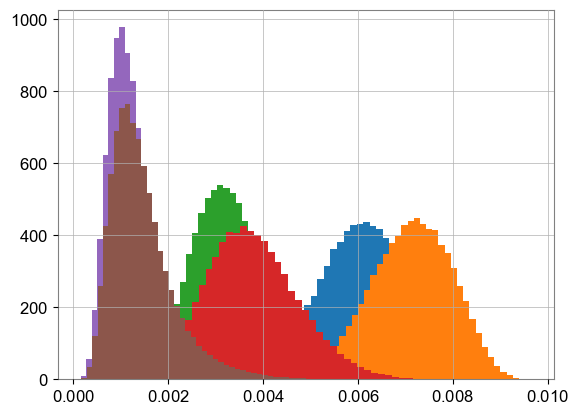

In [56]:
for i in range(3):
    foo = plt.hist(np.linalg.norm(decoded_bkg[i, :, :100] - bkg[:, :100], axis = 1)**2 / 100, bins=50, density=True)
    foo = plt.hist(np.linalg.norm(decoded_bbh[i, :, :100] - bbh[:, :100], axis = 1)**2 / 100, bins=50, density=True)
    
plt.show()

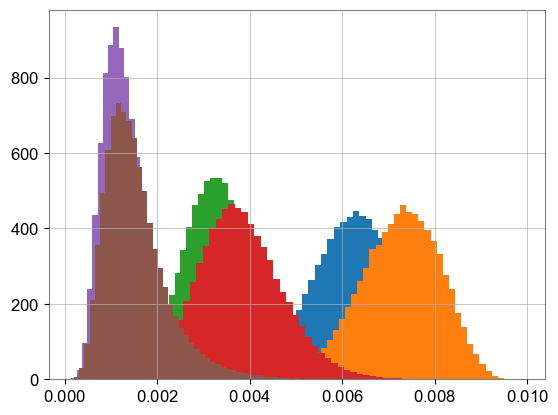

In [76]:
# wNorm = 10
for i in range(3):
    foo = plt.hist(np.linalg.norm(decoded_bkg[i, :, :100] - bkg[:, :100], axis = 1)**2 / 100, bins=50, density=True)
    foo = plt.hist(np.linalg.norm(decoded_bbh[i, :, :100] - bbh[:, :100], axis = 1)**2 / 100, bins=50, density=True)
    
plt.show()

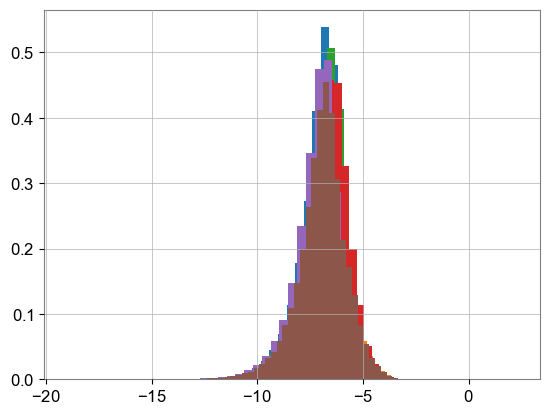

In [77]:
for i in range(3):
    foo = plt.hist(np.log10((decoded_bkg[i, :, -1] - bkg[:, -1])**2), bins=50, density=True)
    foo = plt.hist(np.log10((decoded_bbh[i, :, -1] - bbh[:, -1])**2), bins=50, density=True)
    
plt.show()

# Below starts the training of 200-40-200

### Note that in this case there's no need to impose the norm weight

In [75]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(200, 40),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(40, 200),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [76]:
fake_bkg = np.load("../data/4000Hz25msnoisesample1e6.npy")[100:2*10**5].reshape((10**5-50, 200)) * 1e21

In [77]:
nTotal = len(bkg);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

perm = np.random.permutation(nTotal)

# X_train = bkg[perm[:nTrain]]
# X_test = bkg[perm[-nTest:]]
# X_validation = bkg[perm[nTrain:-nTest]]

X_train = bkg_raw[perm[:nTrain]]
X_test = bkg_raw[perm[-nTest:]]
X_validation = bkg_raw[perm[nTrain:-nTest]]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))
t0 = time.time()

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        loss_norm = loss_func(decoded[:, -1], x[:, -1])
        weighted_lossTrain = loss_overall #+ loss_norm * wNorm

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall #+ lossVal_norm * coef_delta
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
#     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

print(time.time() - t0)
print(autoencoder.cuda())
torch.save(autoencoder.cuda(), "../data/model_200-40_raw.pt")
np.savetxt("../data/loss_200-40_raw.dat", [loss_train[:, 0], loss_validation[:, 0]])
    
np.savetxt("../data/perm_200-40_raw.dat", perm)

992.5381164550781
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=40, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=200, bias=True)
    (1): Tanh()
  )
)


In [79]:
renorm_factor

20

In [80]:
nTotal = len(bkg);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

perm = np.random.permutation(nTotal)

# X_train = bkg[perm[:nTrain]]
# X_test = bkg[perm[-nTest:]]
# X_validation = bkg[perm[nTrain:-nTest]]

X_train = bkg_raw[perm[:nTrain]] / renorm_factor
X_test = bkg_raw[perm[-nTest:]] / renorm_factor
X_validation = bkg_raw[perm[nTrain:-nTest]] / renorm_factor

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))
t0 = time.time()

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        loss_norm = loss_func(decoded[:, -1], x[:, -1])
        weighted_lossTrain = loss_overall #+ loss_norm * wNorm

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall #+ lossVal_norm * coef_delta
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
#     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

print(time.time() - t0)
print(autoencoder.cuda())
torch.save(autoencoder.cuda(), "../data/model_200-40_renorm.pt")
np.savetxt("../data/loss_200-40_renorm.dat", [loss_train[:, 0], loss_validation[:, 0]])
    
np.savetxt("../data/perm_200-40_renorm.dat", perm)

939.0159349441528
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=40, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=200, bias=True)
    (1): Tanh()
  )
)


In [81]:
nTotal = len(fake_bkg);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

perm = np.random.permutation(nTotal)

# X_train = bkg[perm[:nTrain]]
# X_test = bkg[perm[-nTest:]]
# X_validation = bkg[perm[nTrain:-nTest]]

X_train = fake_bkg[perm[:nTrain], :200]
X_test = fake_bkg[perm[-nTest:], :200]
X_validation = fake_bkg[perm[nTrain:-nTest], :200]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))
t0 = time.time()

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        loss_norm = loss_func(decoded[:, -1], x[:, -1])
        weighted_lossTrain = loss_overall #+ loss_norm * wNorm

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall #+ lossVal_norm * coef_delta
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
#     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

print(time.time() - t0)
print(autoencoder.cuda())
torch.save(autoencoder.cuda(), "../data/model_200-40_fakebkg.pt")
np.savetxt("../data/loss_200-40_fakebkg.dat", [loss_train[:, 0], loss_validation[:, 0]])
    
np.savetxt("../data/perm_200-40_fakebkg.dat", perm)

KeyboardInterrupt: 

In [8]:
def TPR_calculation(noise_distribution, signal_distribution, FPR):
    threshold_rank = len(noise_distribution) * FPR
    threshold = np.partition(noise_distribution, -threshold_rank)[-threshold_rank]
    
    TPR = np.argwhere(signal_distribution > threshold).shape[0] / len(signal_distribution)
    
    return TPR

In [30]:
data_for_training_and_testing = np.load("../data/4000Hz25msnoisesample.npy") * 1e21

In [19]:
# data_for_training_and_testing = np.load("../data/4000Hz25msnoisesample1e6.npy") * 1e21

In [9]:
# data_injected = np.delete(np.load("../Data_cached/4000Hz25msdatasampleBBH.npy") * 1e21, 47, axis = 0)

In [10]:
data_injected = np.load("../data/4000Hz25msdatasampleBBH3346.npy") * 1e21

In [31]:
data_for_training_and_testing.shape

(10000, 100)

In [32]:
total_sample_number = data_for_training_and_testing.shape[0]
test_sample_number = int(test_sample_ratio * total_sample_number)
validation_sample_number = int(validation_sample_ratio * total_sample_number)
train_sample_number = total_sample_number - test_sample_number - validation_sample_number


X_train_ini = data_for_training_and_testing[0:train_sample_number].copy()
X_test_ini = data_for_training_and_testing[-test_sample_number:].copy()
X_validation_ini = data_for_training_and_testing[train_sample_number:-test_sample_number].copy()

In [33]:
bkg_normed, _, bkg_norm = bunch_normalization(data_for_training_and_testing)
bkg_with_norm = np.hstack((bkg_normed, np.array([bkg_norm]).transpose()))

In [34]:
perm = np.random.permutation(total_sample_number)

X_train = bkg_with_norm[:train_sample_number]
X_test = bkg_with_norm[-test_sample_number:]
X_validation = bkg_with_norm[train_sample_number:-test_sample_number]

In [35]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

In [36]:
train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)


autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))

for epoch in range(epochs):
    t0 = time.time()
    # 训练阶段
    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        loss_norm = loss_func(decoded[:, -1], x[:, -1])
        weighted_lossTrain = loss_overall + loss_norm * coef_delta
        
        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term
        
        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    # 验证阶段
    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall + lossVal_norm * coef_delta
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)
    
    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
    print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))
    
    print(time.time() - t0)

Epoch: 0001, Training loss=0.02217066, Validation loss=0.02270779
0.7844910621643066
Epoch: 0002, Training loss=0.01996162, Validation loss=0.02012685
0.7868080139160156
Epoch: 0003, Training loss=0.01721187, Validation loss=0.01762725
0.6508562564849854
Epoch: 0004, Training loss=0.01492085, Validation loss=0.01521217
0.6487612724304199
Epoch: 0005, Training loss=0.01295313, Validation loss=0.01318835
0.6243758201599121
Epoch: 0006, Training loss=0.01165853, Validation loss=0.01172066
0.4592752456665039
Epoch: 0007, Training loss=0.01116580, Validation loss=0.01072881
0.6943004131317139
Epoch: 0008, Training loss=0.01011062, Validation loss=0.01011174
0.6722371578216553
Epoch: 0009, Training loss=0.00961590, Validation loss=0.00972080
0.5509111881256104
Epoch: 0010, Training loss=0.00960462, Validation loss=0.00946460
0.5597512722015381
Epoch: 0011, Training loss=0.00906902, Validation loss=0.00926920
0.5272517204284668
Epoch: 0012, Training loss=0.00911178, Validation loss=0.00911032

Epoch: 0098, Training loss=0.00793480, Validation loss=0.00793177
0.6712296009063721
Epoch: 0099, Training loss=0.00787653, Validation loss=0.00791813
0.6022076606750488
Epoch: 0100, Training loss=0.00760934, Validation loss=0.00792396
0.6179549694061279
Epoch: 0101, Training loss=0.00773727, Validation loss=0.00792648
0.5620782375335693
Epoch: 0102, Training loss=0.00787002, Validation loss=0.00792568
0.5542678833007812
Epoch: 0103, Training loss=0.00774764, Validation loss=0.00792061
0.5499720573425293
Epoch: 0104, Training loss=0.00786893, Validation loss=0.00791904
0.5498592853546143
Epoch: 0105, Training loss=0.00779923, Validation loss=0.00792979
0.5548520088195801
Epoch: 0106, Training loss=0.00781604, Validation loss=0.00792018
0.5489993095397949
Epoch: 0107, Training loss=0.00777602, Validation loss=0.00792749
0.640080451965332
Epoch: 0108, Training loss=0.00763654, Validation loss=0.00792203
0.5939502716064453
Epoch: 0109, Training loss=0.00783708, Validation loss=0.00792725


Epoch: 0195, Training loss=0.00784629, Validation loss=0.00790866
0.4901440143585205
Epoch: 0196, Training loss=0.00772006, Validation loss=0.00791074
0.5092020034790039
Epoch: 0197, Training loss=0.00782944, Validation loss=0.00791173
0.5314247608184814
Epoch: 0198, Training loss=0.00778346, Validation loss=0.00791092
0.5661709308624268
Epoch: 0199, Training loss=0.00772742, Validation loss=0.00790552
0.5188450813293457
Epoch: 0200, Training loss=0.00754397, Validation loss=0.00791170
0.43898749351501465


In [38]:
data_real_bkg = np.load("../data/Datasets/background.npz")
data_real_bbh = np.load("../data/Datasets/bbh_for_challenge.npy")
data_real_sg = np.load("../data/Datasets/sglf_for_challenge.npy")

In [43]:
data_real_bkg.items()

ItemsView(<numpy.lib.npyio.NpzFile object at 0x00000223D2B8B410>)

In [23]:
max(np.linalg.norm(train_glitch_sample, axis = 1))

0.9999999999999999

In [111]:
max(train_glitch_sample.flatten())

0.6628917094251212

In [24]:
random_integers = np.random.choice(range(7000), size=350, replace=False)

In [25]:
random_integers_2 = np.random.choice(range(2000), size=100, replace=False)

In [26]:
random_integers_3 = np.random.choice(range(1000), size=50, replace=False)

In [27]:
random_integers_3

array([474, 957, 741, 254, 512, 481, 108, 892, 893,  23, 538,
       417, 477, 734, 756, 297, 143, 913, 786, 766, 574, 612,
       506, 408, 817, 346, 583, 899,  29, 528,  15, 310, 166,
       904, 221, 156, 211, 594, 854, 792, 947, 547, 781, 729,
        93, 690, 490, 407, 862, 412])

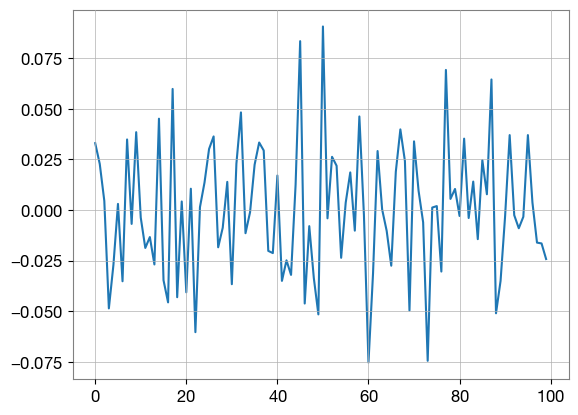

In [124]:
plt.plot(X_validation_ini[181])

In [128]:
random_integers_3.shape

(500,)

In [28]:
X_train_replaced = X_train_ini.copy()
X_train_replaced[random_integers] = train_glitch_sample[0:350]

In [29]:
X_test_replaced = X_test_ini.copy()
X_test_replaced[random_integers_2] = train_glitch_sample[400:500]

In [30]:
X_validation_replaced = X_validation_ini.copy()
X_validation_replaced[random_integers_3] = train_glitch_sample[350:400]

In [31]:
X_validation_replaced.shape

(1000, 100)

In [75]:
# X_train_replaced = train_glitch_sample

In [79]:
# X_train, X_train_recover_min, X_train_recover_coef = bunch_normalization(X_train_replaced)
# X_test, X_test_recover_min, X_test_recover_coef = bunch_normalization(X_test_replaced)
# X_validation, X_validation_recover_min, X_validation_recover_coef = bunch_normalization(X_validation_replaced)
# data_injected_normalized, junk1, junk2 = bunch_normalization(data_injected.copy())

In [78]:
# X_train.shape

(500, 100)

In [32]:
# X_train, X_train_recover_min, X_train_recover_coef = bunch_normalization(X_train_replaced)
# X_test, X_test_recover_min, X_test_recover_coef = bunch_normalization(X_test_replaced)
# X_validation, X_validation_recover_min, X_validation_recover_coef = bunch_normalization(X_validation_replaced)
# data_injected_normalized, junk1, junk2 = bunch_normalization(data_injected.copy())

In [19]:
X_train, X_train_recover_min, X_train_recover_coef = bunch_normalization(X_train_ini)
X_test, X_test_recover_min, X_test_recover_coef = bunch_normalization(X_test_ini)
X_validation, X_validation_recover_min, X_validation_recover_coef = bunch_normalization(X_validation_ini)
data_injected_normalized, junk1, junk2 = bunch_normalization(data_injected.copy())

In [81]:
X_train = np.hstack((X_train, np.array(X_train_recover_coef).reshape(train_sample_number,1)))
X_validation = np.hstack((X_validation, np.array(X_validation_recover_coef).reshape(validation_sample_number,1)))
X_test = np.hstack((X_test, np.array(X_test_recover_coef).reshape(test_sample_number,1)))
data_injected_normalized = np.hstack((data_injected_normalized, np.array(junk2).reshape(len(data_injected),1)))

In [20]:
# X_train = np.hstack((X_train, np.array(X_train_recover_coef).reshape(train_sample_number,1)))
# X_validation = np.hstack((X_validation, np.array(X_validation_recover_coef).reshape(validation_sample_number,1)))
# X_test = np.hstack((X_test, np.array(X_test_recover_coef).reshape(test_sample_number,1)))
# data_injected_normalized = np.hstack((data_injected_normalized, np.array(X_train_recover_coef)[0:len(data_injected)].reshape(len(data_injected),1)))

In [45]:
# X_train = np.hstack((X_train, np.ones((train_sample_number, 1))))
# X_validation = np.hstack((X_validation, np.ones((validation_sample_number, 1))))
# X_test = np.hstack((X_test, np.ones((test_sample_number, 1))))
# data_injected_normalized = np.hstack((data_injected_normalized, np.ones((len(data_injected), 1))))

In [165]:
np.savez('../Data_cached/uninorm_dataset_cached.npz', train = X_train, validation = X_validation, test = X_test, BBH = data_injected_normalized, SG = data_sinegaussian_normalized, simulated_glitches = data_glitches_normalized, real_glitches = data_glitches_real_normalized)

In [430]:
data_file = np.load('../Data_cached/uninorm_dataset_cached.npz')

In [431]:
X_train, X_test, data_injected_normalized, data_sinegaussian_normalized, data_glitches_normalized, data_glitches_real_normalized = data_file['train'], data_file['test'], data_file['BBH'], data_file['SG'], data_file['simulated_glitches'], data_file['real_glitches']

In [432]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

In [22]:
train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)


autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))


for epoch in range(epochs):
    # 训练阶段
    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        loss_norm = loss_func(decoded[:, -1], x[:, -1])
        weighted_lossTrain = loss_overall + loss_norm * coef_delta
        
        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term
        
        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    # 验证阶段
    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall + lossVal_norm * coef_delta
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)
    
    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
    print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

Epoch: 0001, Training loss=0.00791089, Validation loss=0.00789967
Epoch: 0002, Training loss=0.00779289, Validation loss=0.00789402
Epoch: 0003, Training loss=0.00787645, Validation loss=0.00789183
Epoch: 0004, Training loss=0.00779505, Validation loss=0.00788969
Epoch: 0005, Training loss=0.00794173, Validation loss=0.00788823
Epoch: 0006, Training loss=0.00796271, Validation loss=0.00788735
Epoch: 0007, Training loss=0.00776560, Validation loss=0.00788669
Epoch: 0008, Training loss=0.00787914, Validation loss=0.00788613
Epoch: 0009, Training loss=0.00781101, Validation loss=0.00788495
Epoch: 0010, Training loss=0.00785976, Validation loss=0.00788512
Epoch: 0011, Training loss=0.00786832, Validation loss=0.00788368
Epoch: 0012, Training loss=0.00800549, Validation loss=0.00788378
Epoch: 0013, Training loss=0.00767947, Validation loss=0.00788358
Epoch: 0014, Training loss=0.00798490, Validation loss=0.00788337
Epoch: 0015, Training loss=0.00807306, Validation loss=0.00788296
Epoch: 001

In [25]:
torch.save(autoencoder.cpu(), '../Model_cached/model_101_20_101_uninorm.pt')

In [215]:
autoencoder = torch.load('../Model_cached/model_101_20_101_uninorm.pt')

In [42]:
autoencoder = autoencoder.cpu()

In [ ]:
loss_func()

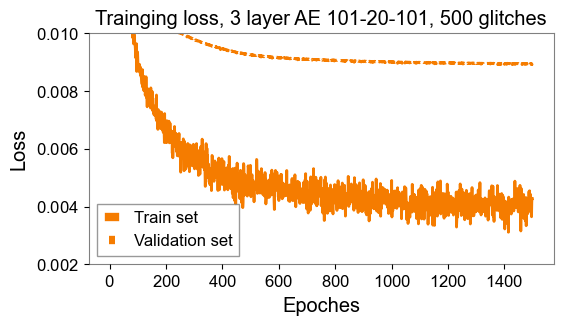

In [94]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 3 layer AE 101-20-101, 500 glitches')
plt.ylim(0.002,0.01)
plt.legend()
plt.show()